In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
import os
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
import imageio
from ImageDataset import FolderImageDataset

#[x] TODO: import the dataset from ImageDataset.py and adapt the api
#[ ] TODO: maybe switch to torch.datasets.ImageFolder?

In [12]:
BATCH=10
# path = r'C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\img'
# path2 = r"C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\img3_stripes"
path = Path("img4_stripes")


# Dataset resized

In [13]:
# TODO: use transforms for 1) resizing image and 2) taking only green channel
# https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize


In [14]:
def condition(a):
    # based on dataset inspection plots
    return (0.120 > a) & (a > 0.105)

In [15]:
# TODO: random sample test data instead of from the end
import skimage
from skimage.transform import resize
class Resize:
    def __init__(self, size):
        if isinstance(size, int):
            self._size = (size, size)
        else:
            self._size = size

    def __call__(self, img: np.ndarray):
        resize_image = resize(img, self._size)
        # the resize will return a float64 array
        return skimage.util.img_as_ubyte(resize_image)
    

train_loader_1 = FolderImageDataset(path, transform=transforms.Compose([
                                Resize((144/2, 192/2)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),

]), 
                                    start =  0.3, end = 0.8,
                                   filtered=condition)
test_loader_1 = FolderImageDataset(path, transform=transforms.Compose([
                                Resize((144/2, 192/2)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),


]), start = 0.8, end = 1,
                                  filtered=condition)

TypeError: __init__() got an unexpected keyword argument 'start'

In [16]:
train_loader_1.print_target_statistic()

NameError: name 'train_loader_1' is not defined

In [24]:
train_loader = torch.utils.data.DataLoader(
        train_loader_1,
     batch_size=BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        test_loader_1,
batch_size=BATCH, shuffle=True)

In [25]:
len(train_loader_1)

2030

In [17]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #self.conv3 = nn.Conv2d(50, 60, 5, 1)

        self.fc1 = nn.Linear(14*19*50, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        #x = F.relu(self.conv3(x))
        #print(x.shape)

        #x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 14*19*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class Net05(nn.Module):
    def __init__(self):
        super(Net05, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #self.conv3 = nn.Conv2d(50, 60, 5, 1)

        self.fc1 = nn.Linear(6*8*50, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        #x = F.relu(self.conv3(x))
        #print(x.shape)

        #x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 6*8*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t mse: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss, target.std()**2))
    return train_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.7f}\n'.format(
        test_loss))
    return test_loss

In [18]:
model = Net05()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
optimizer = optim.Adam(model.parameters(), lr=0.002)


/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Train Epoch: 1 [0/2030 (0%)]	Loss: 0.004659	 mse: 2.222475995949935e-05
Train Epoch: 1 [100/2030 (5%)]	Loss: 0.001305	 mse: 2.1415395167423412e-05
Train Epoch: 1 [200/2030 (10%)]	Loss: 0.000686	 mse: 2.8464082788559608e-05
Train Epoch: 1 [300/2030 (15%)]	Loss: 0.000275	 mse: 1.3072718502371572e-05
Train Epoch: 1 [400/2030 (20%)]	Loss: 0.000228	 mse: 1.3741987459070515e-05
Train Epoch: 1 [500/2030 (25%)]	Loss: 0.000087	 mse: 1.65282344823936e-05
Train Epoch: 1 [600/2030 (30%)]	Loss: 0.000037	 mse: 2.3791644707671367e-05
Train Epoch: 1 [700/2030 (34%)]	Loss: 0.000022	 mse: 1.8757731595542282e-05
Train Epoch: 1 [800/2030 (39%)]	Loss: 0.000035	 mse: 1.280434662476182e-05
Train Epoch: 1 [900/2030 (44%)]	Loss: 0.000021	 mse: 2.1333207769203e-05
Train Epoch: 1 [1000/2030 (49%)]	Loss: 0.000047	 mse: 1.466780395276146e-05
Train Epoch: 1 [1100/2030 (54%)]	Loss: 0.000046	 mse: 2.370793663430959e-05
Train Epoch: 1 [1200/2030 (59%)]	Loss: 0.000018	 mse: 2.472203050274402e-05
Train Epoch: 1 [1300/20

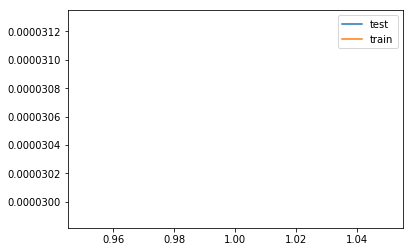

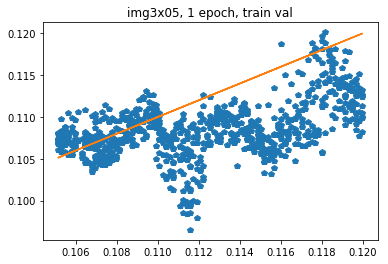

Train Epoch: 2 [0/2030 (0%)]	Loss: 0.000025	 mse: 1.1995280146948062e-05
Train Epoch: 2 [100/2030 (5%)]	Loss: 0.000012	 mse: 1.5379535398096777e-05
Train Epoch: 2 [200/2030 (10%)]	Loss: 0.000027	 mse: 2.162432429031469e-05
Train Epoch: 2 [300/2030 (15%)]	Loss: 0.000029	 mse: 2.6632762455847114e-05
Train Epoch: 2 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.3966396181785967e-05
Train Epoch: 2 [500/2030 (25%)]	Loss: 0.000044	 mse: 2.250585748697631e-05
Train Epoch: 2 [600/2030 (30%)]	Loss: 0.000009	 mse: 2.0143254005233757e-05
Train Epoch: 2 [700/2030 (34%)]	Loss: 0.000031	 mse: 1.6167989087989554e-05
Train Epoch: 2 [800/2030 (39%)]	Loss: 0.000009	 mse: 1.863916259026155e-05
Train Epoch: 2 [900/2030 (44%)]	Loss: 0.000045	 mse: 2.3859569409978576e-05
Train Epoch: 2 [1000/2030 (49%)]	Loss: 0.000027	 mse: 2.1756241039838642e-05
Train Epoch: 2 [1100/2030 (54%)]	Loss: 0.000014	 mse: 1.8255845134262927e-05
Train Epoch: 2 [1200/2030 (59%)]	Loss: 0.000016	 mse: 1.5676709153922275e-05
Train Epoch: 2 [

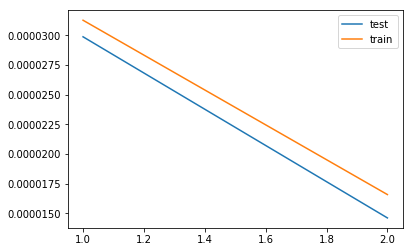

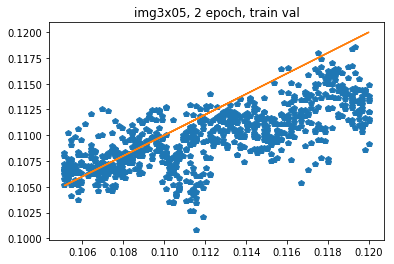

Train Epoch: 3 [0/2030 (0%)]	Loss: 0.000006	 mse: 1.2414978300512303e-05
Train Epoch: 3 [100/2030 (5%)]	Loss: 0.000020	 mse: 2.1465117242769338e-05
Train Epoch: 3 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.0796843525895383e-05
Train Epoch: 3 [300/2030 (15%)]	Loss: 0.000035	 mse: 9.632373803469818e-06
Train Epoch: 3 [400/2030 (20%)]	Loss: 0.000015	 mse: 8.467002771794796e-06
Train Epoch: 3 [500/2030 (25%)]	Loss: 0.000009	 mse: 1.3232544006314129e-05
Train Epoch: 3 [600/2030 (30%)]	Loss: 0.000019	 mse: 1.4204443687049206e-05
Train Epoch: 3 [700/2030 (34%)]	Loss: 0.000024	 mse: 1.7024662156472914e-05
Train Epoch: 3 [800/2030 (39%)]	Loss: 0.000019	 mse: 1.839171272877138e-05
Train Epoch: 3 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.3769825929775834e-05
Train Epoch: 3 [1000/2030 (49%)]	Loss: 0.000003	 mse: 2.495398439350538e-05
Train Epoch: 3 [1100/2030 (54%)]	Loss: 0.000008	 mse: 1.0402627594885416e-05
Train Epoch: 3 [1200/2030 (59%)]	Loss: 0.000017	 mse: 1.8037506379187107e-05
Train Epoch: 3 [1

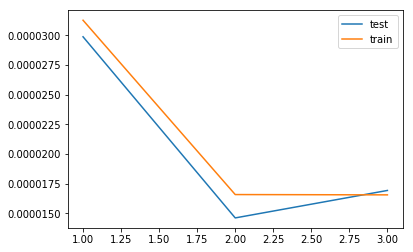

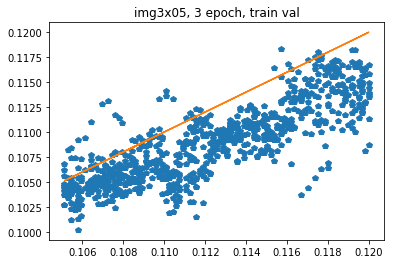

Train Epoch: 4 [0/2030 (0%)]	Loss: 0.000029	 mse: 3.0347868232638575e-05
Train Epoch: 4 [100/2030 (5%)]	Loss: 0.000018	 mse: 1.526096457382664e-05
Train Epoch: 4 [200/2030 (10%)]	Loss: 0.000005	 mse: 1.1887632354046218e-05
Train Epoch: 4 [300/2030 (15%)]	Loss: 0.000017	 mse: 2.2843392798677087e-05
Train Epoch: 4 [400/2030 (20%)]	Loss: 0.000005	 mse: 2.387290987826418e-05
Train Epoch: 4 [500/2030 (25%)]	Loss: 0.000002	 mse: 2.4188282623072155e-05
Train Epoch: 4 [600/2030 (30%)]	Loss: 0.000005	 mse: 3.351166014908813e-05
Train Epoch: 4 [700/2030 (34%)]	Loss: 0.000039	 mse: 1.8049631762551144e-05
Train Epoch: 4 [800/2030 (39%)]	Loss: 0.000016	 mse: 2.2786363842897117e-05
Train Epoch: 4 [900/2030 (44%)]	Loss: 0.000007	 mse: 2.938505531346891e-05
Train Epoch: 4 [1000/2030 (49%)]	Loss: 0.000011	 mse: 2.436933573335409e-05
Train Epoch: 4 [1100/2030 (54%)]	Loss: 0.000006	 mse: 1.6757800040068105e-05
Train Epoch: 4 [1200/2030 (59%)]	Loss: 0.000005	 mse: 1.6296851754304953e-05
Train Epoch: 4 [13

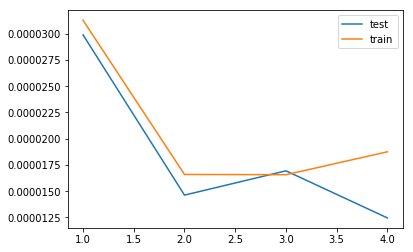

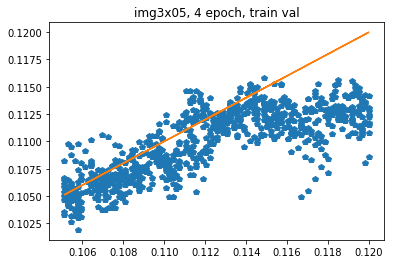

Train Epoch: 5 [0/2030 (0%)]	Loss: 0.000018	 mse: 2.7468224288895726e-05
Train Epoch: 5 [100/2030 (5%)]	Loss: 0.000010	 mse: 5.885739483346697e-06
Train Epoch: 5 [200/2030 (10%)]	Loss: 0.000015	 mse: 2.7147993023390882e-05
Train Epoch: 5 [300/2030 (15%)]	Loss: 0.000021	 mse: 1.9407874788157642e-05
Train Epoch: 5 [400/2030 (20%)]	Loss: 0.000004	 mse: 1.75583700183779e-05
Train Epoch: 5 [500/2030 (25%)]	Loss: 0.000013	 mse: 2.5875871870084666e-05
Train Epoch: 5 [600/2030 (30%)]	Loss: 0.000024	 mse: 9.81341963779414e-06
Train Epoch: 5 [700/2030 (34%)]	Loss: 0.000006	 mse: 1.8716777049121447e-05
Train Epoch: 5 [800/2030 (39%)]	Loss: 0.000007	 mse: 2.0098073946428485e-05
Train Epoch: 5 [900/2030 (44%)]	Loss: 0.000017	 mse: 1.6352354577975348e-05
Train Epoch: 5 [1000/2030 (49%)]	Loss: 0.000008	 mse: 2.1210698832874186e-05
Train Epoch: 5 [1100/2030 (54%)]	Loss: 0.000005	 mse: 1.610521212569438e-05
Train Epoch: 5 [1200/2030 (59%)]	Loss: 0.000016	 mse: 1.3657090676133521e-05
Train Epoch: 5 [130

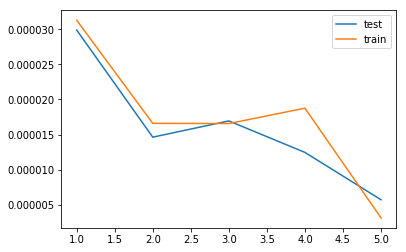

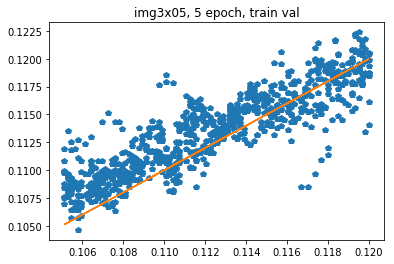

Train Epoch: 6 [0/2030 (0%)]	Loss: 0.000006	 mse: 9.99627445708029e-06
Train Epoch: 6 [100/2030 (5%)]	Loss: 0.000013	 mse: 1.285044436372118e-05
Train Epoch: 6 [200/2030 (10%)]	Loss: 0.000018	 mse: 1.6206800864893012e-05
Train Epoch: 6 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.765025626809802e-05
Train Epoch: 6 [400/2030 (20%)]	Loss: 0.000008	 mse: 2.379559191467706e-05
Train Epoch: 6 [500/2030 (25%)]	Loss: 0.000028	 mse: 1.5714635082986206e-05
Train Epoch: 6 [600/2030 (30%)]	Loss: 0.000003	 mse: 2.361695806030184e-05
Train Epoch: 6 [700/2030 (34%)]	Loss: 0.000031	 mse: 1.647243698243983e-05
Train Epoch: 6 [800/2030 (39%)]	Loss: 0.000005	 mse: 2.3386495740851387e-05
Train Epoch: 6 [900/2030 (44%)]	Loss: 0.000013	 mse: 2.5672994524938986e-05
Train Epoch: 6 [1000/2030 (49%)]	Loss: 0.000004	 mse: 1.582986442372203e-05
Train Epoch: 6 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.0138404579483904e-05
Train Epoch: 6 [1200/2030 (59%)]	Loss: 0.000014	 mse: 1.1106162673968356e-05
Train Epoch: 6 [1300/

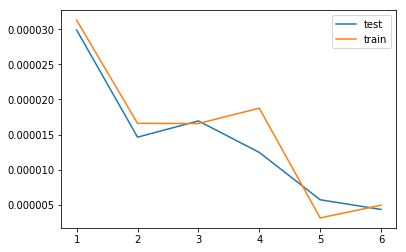

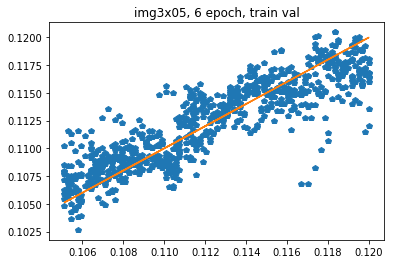

Train Epoch: 7 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.0795948583108839e-05
Train Epoch: 7 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.7685742932371795e-05
Train Epoch: 7 [200/2030 (10%)]	Loss: 0.000018	 mse: 2.8985976314288564e-05
Train Epoch: 7 [300/2030 (15%)]	Loss: 0.000007	 mse: 2.7739937650039792e-05
Train Epoch: 7 [400/2030 (20%)]	Loss: 0.000012	 mse: 1.6808735381346196e-05
Train Epoch: 7 [500/2030 (25%)]	Loss: 0.000008	 mse: 1.062248156813439e-05
Train Epoch: 7 [600/2030 (30%)]	Loss: 0.000010	 mse: 2.2804568288847804e-05
Train Epoch: 7 [700/2030 (34%)]	Loss: 0.000011	 mse: 2.431566099403426e-05
Train Epoch: 7 [800/2030 (39%)]	Loss: 0.000009	 mse: 1.7504704374005087e-05
Train Epoch: 7 [900/2030 (44%)]	Loss: 0.000054	 mse: 2.9865104806958698e-05
Train Epoch: 7 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.602242082299199e-05
Train Epoch: 7 [1100/2030 (54%)]	Loss: 0.000010	 mse: 1.4776990610698704e-05
Train Epoch: 7 [1200/2030 (59%)]	Loss: 0.000004	 mse: 1.7461032257415354e-05
Train Epoch: 7 [

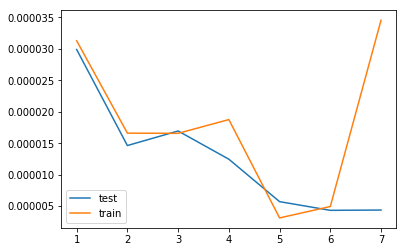

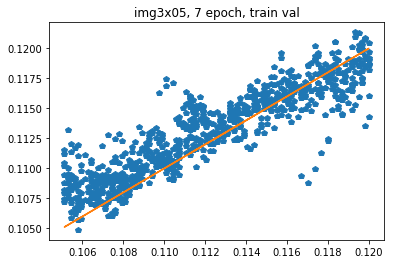

Train Epoch: 8 [0/2030 (0%)]	Loss: 0.000009	 mse: 2.2270849513006397e-05
Train Epoch: 8 [100/2030 (5%)]	Loss: 0.000002	 mse: 4.308857569412794e-06
Train Epoch: 8 [200/2030 (10%)]	Loss: 0.000008	 mse: 3.112535296168062e-06
Train Epoch: 8 [300/2030 (15%)]	Loss: 0.000011	 mse: 1.6190120732062496e-05
Train Epoch: 8 [400/2030 (20%)]	Loss: 0.000038	 mse: 3.2418454793514684e-05
Train Epoch: 8 [500/2030 (25%)]	Loss: 0.000021	 mse: 1.290169711865019e-05
Train Epoch: 8 [600/2030 (30%)]	Loss: 0.000010	 mse: 2.185690937039908e-05
Train Epoch: 8 [700/2030 (34%)]	Loss: 0.000006	 mse: 1.9758439520956017e-05
Train Epoch: 8 [800/2030 (39%)]	Loss: 0.000004	 mse: 1.3077573385089636e-05
Train Epoch: 8 [900/2030 (44%)]	Loss: 0.000007	 mse: 3.2835716410772875e-05
Train Epoch: 8 [1000/2030 (49%)]	Loss: 0.000012	 mse: 1.090753448806936e-05
Train Epoch: 8 [1100/2030 (54%)]	Loss: 0.000010	 mse: 2.144843529094942e-05
Train Epoch: 8 [1200/2030 (59%)]	Loss: 0.000010	 mse: 2.6840200007427484e-05
Train Epoch: 8 [130

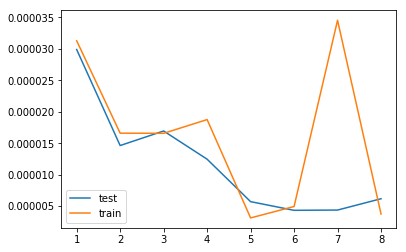

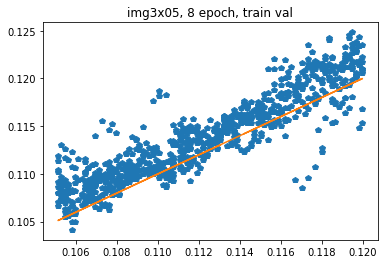

Train Epoch: 9 [0/2030 (0%)]	Loss: 0.000003	 mse: 1.0390500392531976e-05
Train Epoch: 9 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.7354583178530447e-05
Train Epoch: 9 [200/2030 (10%)]	Loss: 0.000005	 mse: 1.7577476683072746e-05
Train Epoch: 9 [300/2030 (15%)]	Loss: 0.000005	 mse: 2.2342106603900902e-05
Train Epoch: 9 [400/2030 (20%)]	Loss: 0.000006	 mse: 6.90678143655532e-06
Train Epoch: 9 [500/2030 (25%)]	Loss: 0.000002	 mse: 6.6108123064623214e-06
Train Epoch: 9 [600/2030 (30%)]	Loss: 0.000011	 mse: 6.227495759958401e-06
Train Epoch: 9 [700/2030 (34%)]	Loss: 0.000013	 mse: 1.6520958524779417e-05
Train Epoch: 9 [800/2030 (39%)]	Loss: 0.000018	 mse: 1.9790270016528666e-05
Train Epoch: 9 [900/2030 (44%)]	Loss: 0.000002	 mse: 7.999987246876117e-06
Train Epoch: 9 [1000/2030 (49%)]	Loss: 0.000002	 mse: 1.561849785503e-05
Train Epoch: 9 [1100/2030 (54%)]	Loss: 0.000006	 mse: 3.5007280530408025e-05
Train Epoch: 9 [1200/2030 (59%)]	Loss: 0.000063	 mse: 2.559687891334761e-05
Train Epoch: 9 [1300/2

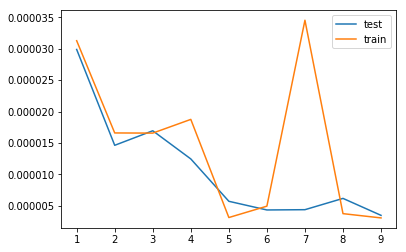

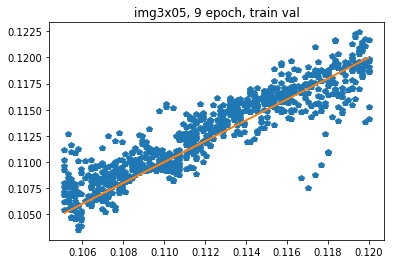

Train Epoch: 10 [0/2030 (0%)]	Loss: 0.000002	 mse: 1.9844856069539674e-05
Train Epoch: 10 [100/2030 (5%)]	Loss: 0.000009	 mse: 2.6220053769066e-05
Train Epoch: 10 [200/2030 (10%)]	Loss: 0.000010	 mse: 4.044998058816418e-05
Train Epoch: 10 [300/2030 (15%)]	Loss: 0.000006	 mse: 2.363668318139389e-05
Train Epoch: 10 [400/2030 (20%)]	Loss: 0.000012	 mse: 1.6598598449490964e-05
Train Epoch: 10 [500/2030 (25%)]	Loss: 0.000007	 mse: 2.3664273612666875e-05
Train Epoch: 10 [600/2030 (30%)]	Loss: 0.000008	 mse: 2.1004185327910818e-05
Train Epoch: 10 [700/2030 (34%)]	Loss: 0.000017	 mse: 2.209951708209701e-05
Train Epoch: 10 [800/2030 (39%)]	Loss: 0.000008	 mse: 2.7410305847297423e-05
Train Epoch: 10 [900/2030 (44%)]	Loss: 0.000019	 mse: 3.0105275072855875e-05
Train Epoch: 10 [1000/2030 (49%)]	Loss: 0.000021	 mse: 2.0393135855556466e-05
Train Epoch: 10 [1100/2030 (54%)]	Loss: 0.000005	 mse: 2.633437361510005e-05
Train Epoch: 10 [1200/2030 (59%)]	Loss: 0.000005	 mse: 1.3414484783424996e-05
Train E

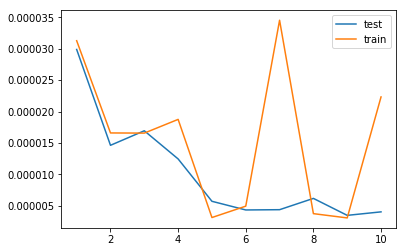

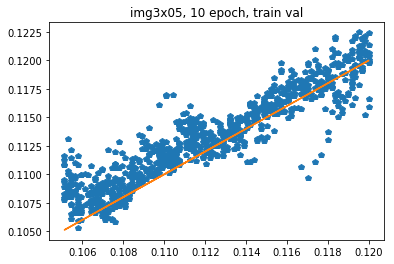

Train Epoch: 11 [0/2030 (0%)]	Loss: 0.000003	 mse: 1.4957414350647014e-05
Train Epoch: 11 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.9687184249050915e-05
Train Epoch: 11 [200/2030 (10%)]	Loss: 0.000001	 mse: 2.107090040226467e-05
Train Epoch: 11 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.9022059607086703e-05
Train Epoch: 11 [400/2030 (20%)]	Loss: 0.000001	 mse: 9.026177394844126e-06
Train Epoch: 11 [500/2030 (25%)]	Loss: 0.000005	 mse: 2.7159203455084935e-05
Train Epoch: 11 [600/2030 (30%)]	Loss: 0.000007	 mse: 1.3287120054883417e-05
Train Epoch: 11 [700/2030 (34%)]	Loss: 0.000011	 mse: 1.641058042878285e-05
Train Epoch: 11 [800/2030 (39%)]	Loss: 0.000004	 mse: 1.6957948901108466e-05
Train Epoch: 11 [900/2030 (44%)]	Loss: 0.000017	 mse: 2.578215026005637e-05
Train Epoch: 11 [1000/2030 (49%)]	Loss: 0.000002	 mse: 2.053717616945505e-05
Train Epoch: 11 [1100/2030 (54%)]	Loss: 0.000041	 mse: 1.4334241313918028e-05
Train Epoch: 11 [1200/2030 (59%)]	Loss: 0.000013	 mse: 1.3720166862185579e-05
Train

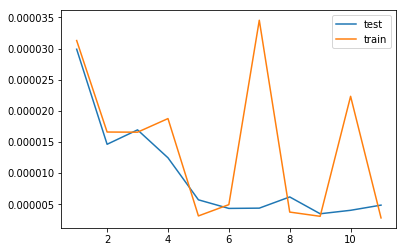

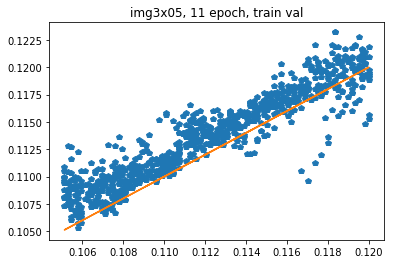

Train Epoch: 12 [0/2030 (0%)]	Loss: 0.000007	 mse: 2.576426777523011e-05
Train Epoch: 12 [100/2030 (5%)]	Loss: 0.000012	 mse: 2.667249646037817e-05
Train Epoch: 12 [200/2030 (10%)]	Loss: 0.000025	 mse: 2.720773045439273e-05
Train Epoch: 12 [300/2030 (15%)]	Loss: 0.000005	 mse: 1.393759794154903e-05
Train Epoch: 12 [400/2030 (20%)]	Loss: 0.000025	 mse: 1.4278135495260358e-05
Train Epoch: 12 [500/2030 (25%)]	Loss: 0.000005	 mse: 9.97565257421229e-06
Train Epoch: 12 [600/2030 (30%)]	Loss: 0.000001	 mse: 1.6004229109967127e-05
Train Epoch: 12 [700/2030 (34%)]	Loss: 0.000012	 mse: 1.922138653753791e-05
Train Epoch: 12 [800/2030 (39%)]	Loss: 0.000010	 mse: 2.4267133994726464e-05
Train Epoch: 12 [900/2030 (44%)]	Loss: 0.000009	 mse: 1.465447166992817e-05
Train Epoch: 12 [1000/2030 (49%)]	Loss: 0.000005	 mse: 2.509561090846546e-05
Train Epoch: 12 [1100/2030 (54%)]	Loss: 0.000007	 mse: 2.423438309051562e-05
Train Epoch: 12 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.6503972801729105e-05
Train Epoc

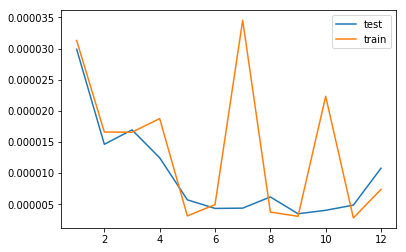

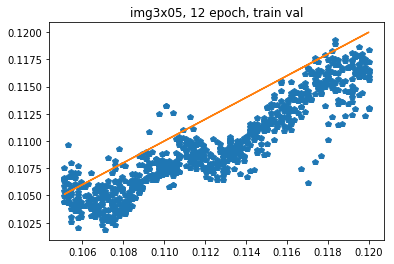

Train Epoch: 13 [0/2030 (0%)]	Loss: 0.000012	 mse: 1.540380071674008e-05
Train Epoch: 13 [100/2030 (5%)]	Loss: 0.000013	 mse: 1.0028108590631746e-05
Train Epoch: 13 [200/2030 (10%)]	Loss: 0.000006	 mse: 1.2911095836898312e-05
Train Epoch: 13 [300/2030 (15%)]	Loss: 0.000011	 mse: 9.983225936593954e-06
Train Epoch: 13 [400/2030 (20%)]	Loss: 0.000007	 mse: 1.778277692210395e-05
Train Epoch: 13 [500/2030 (25%)]	Loss: 0.000009	 mse: 1.1324494153086562e-05
Train Epoch: 13 [600/2030 (30%)]	Loss: 0.000004	 mse: 2.7014566512661986e-05
Train Epoch: 13 [700/2030 (34%)]	Loss: 0.000002	 mse: 1.7787324395612814e-05
Train Epoch: 13 [800/2030 (39%)]	Loss: 0.000004	 mse: 2.5903455025400035e-05
Train Epoch: 13 [900/2030 (44%)]	Loss: 0.000005	 mse: 1.848479951149784e-05
Train Epoch: 13 [1000/2030 (49%)]	Loss: 0.000003	 mse: 2.258866334159393e-05
Train Epoch: 13 [1100/2030 (54%)]	Loss: 0.000007	 mse: 1.5731297025922686e-05
Train Epoch: 13 [1200/2030 (59%)]	Loss: 0.000007	 mse: 1.3823269000567961e-05
Train

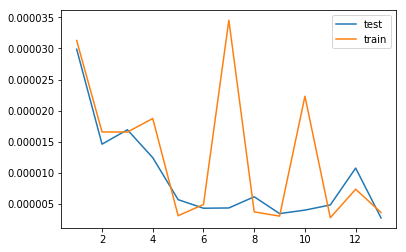

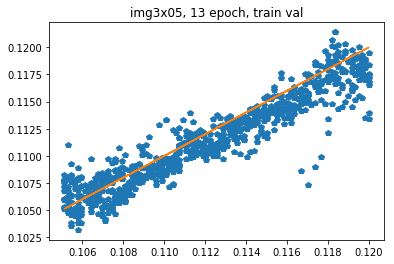

Train Epoch: 14 [0/2030 (0%)]	Loss: 0.000003	 mse: 1.4188672139425762e-05
Train Epoch: 14 [100/2030 (5%)]	Loss: 0.000005	 mse: 2.7275642423774116e-05
Train Epoch: 14 [200/2030 (10%)]	Loss: 0.000006	 mse: 2.150302316294983e-05
Train Epoch: 14 [300/2030 (15%)]	Loss: 0.000013	 mse: 1.6780546502559446e-05
Train Epoch: 14 [400/2030 (20%)]	Loss: 0.000001	 mse: 1.3658302123076282e-05
Train Epoch: 14 [500/2030 (25%)]	Loss: 0.000003	 mse: 1.8603974240249954e-05
Train Epoch: 14 [600/2030 (30%)]	Loss: 0.000001	 mse: 2.2223552150535397e-05
Train Epoch: 14 [700/2030 (34%)]	Loss: 0.000002	 mse: 1.2134785720263608e-05
Train Epoch: 14 [800/2030 (39%)]	Loss: 0.000010	 mse: 2.3533275452791713e-05
Train Epoch: 14 [900/2030 (44%)]	Loss: 0.000002	 mse: 2.6063877157866955e-05
Train Epoch: 14 [1000/2030 (49%)]	Loss: 0.000008	 mse: 2.090107591357082e-05
Train Epoch: 14 [1100/2030 (54%)]	Loss: 0.000002	 mse: 1.2834979315812234e-05
Train Epoch: 14 [1200/2030 (59%)]	Loss: 0.000003	 mse: 2.3425614926964045e-05
Tr

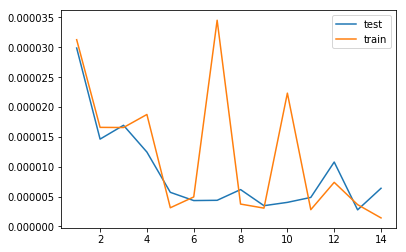

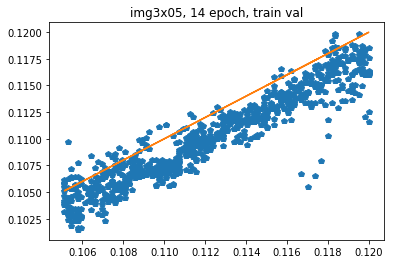

Train Epoch: 15 [0/2030 (0%)]	Loss: 0.000007	 mse: 1.8537255527917296e-05
Train Epoch: 15 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.80071856448194e-05
Train Epoch: 15 [200/2030 (10%)]	Loss: 0.000001	 mse: 9.597503776603844e-06
Train Epoch: 15 [300/2030 (15%)]	Loss: 0.000007	 mse: 2.2017035007593222e-05
Train Epoch: 15 [400/2030 (20%)]	Loss: 0.000001	 mse: 1.80823899427196e-05
Train Epoch: 15 [500/2030 (25%)]	Loss: 0.000018	 mse: 2.0995688828406855e-05
Train Epoch: 15 [600/2030 (30%)]	Loss: 0.000009	 mse: 1.7827655028668232e-05
Train Epoch: 15 [700/2030 (34%)]	Loss: 0.000009	 mse: 2.0628165657399222e-05
Train Epoch: 15 [800/2030 (39%)]	Loss: 0.000004	 mse: 3.390589699847624e-05
Train Epoch: 15 [900/2030 (44%)]	Loss: 0.000011	 mse: 2.2485555746243335e-05
Train Epoch: 15 [1000/2030 (49%)]	Loss: 0.000004	 mse: 3.586364982766099e-05
Train Epoch: 15 [1100/2030 (54%)]	Loss: 0.000002	 mse: 9.31851172936149e-06
Train Epoch: 15 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.1421539966249838e-05
Train Epo

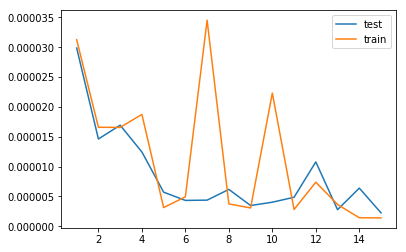

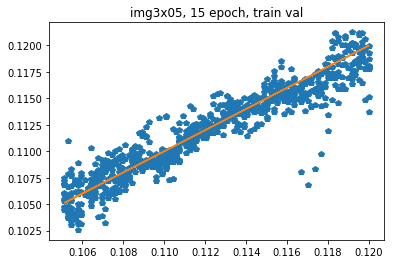

Train Epoch: 16 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.1805151189037133e-05
Train Epoch: 16 [100/2030 (5%)]	Loss: 0.000001	 mse: 1.8844140868168324e-05
Train Epoch: 16 [200/2030 (10%)]	Loss: 0.000003	 mse: 3.591792119550519e-05
Train Epoch: 16 [300/2030 (15%)]	Loss: 0.000002	 mse: 1.734094439598266e-05
Train Epoch: 16 [400/2030 (20%)]	Loss: 0.000002	 mse: 2.4224678782047704e-05
Train Epoch: 16 [500/2030 (25%)]	Loss: 0.000003	 mse: 2.5160205041174777e-05
Train Epoch: 16 [600/2030 (30%)]	Loss: 0.000001	 mse: 1.8552727851783857e-05
Train Epoch: 16 [700/2030 (34%)]	Loss: 0.000005	 mse: 2.2048876417102292e-05
Train Epoch: 16 [800/2030 (39%)]	Loss: 0.000013	 mse: 1.9456709196674637e-05
Train Epoch: 16 [900/2030 (44%)]	Loss: 0.000001	 mse: 2.2604410332860425e-05
Train Epoch: 16 [1000/2030 (49%)]	Loss: 0.000004	 mse: 2.6724968847702257e-05
Train Epoch: 16 [1100/2030 (54%)]	Loss: 0.000006	 mse: 1.3150048289389815e-05
Train Epoch: 16 [1200/2030 (59%)]	Loss: 0.000003	 mse: 2.1628871763823554e-05
Tr

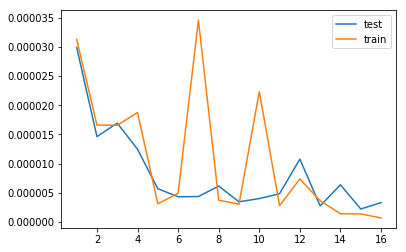

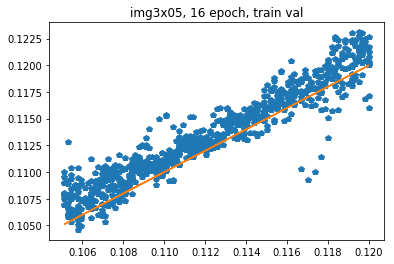

Train Epoch: 17 [0/2030 (0%)]	Loss: 0.000010	 mse: 2.422830948489718e-05
Train Epoch: 17 [100/2030 (5%)]	Loss: 0.000001	 mse: 1.701981273072306e-05
Train Epoch: 17 [200/2030 (10%)]	Loss: 0.000002	 mse: 7.0426331149064936e-06
Train Epoch: 17 [300/2030 (15%)]	Loss: 0.000011	 mse: 1.914254426083062e-05
Train Epoch: 17 [400/2030 (20%)]	Loss: 0.000004	 mse: 2.1209185433690436e-05
Train Epoch: 17 [500/2030 (25%)]	Loss: 0.000003	 mse: 2.5530151106067933e-05
Train Epoch: 17 [600/2030 (30%)]	Loss: 0.000003	 mse: 1.1347855433996301e-05
Train Epoch: 17 [700/2030 (34%)]	Loss: 0.000002	 mse: 2.437781949993223e-05
Train Epoch: 17 [800/2030 (39%)]	Loss: 0.000002	 mse: 1.749288094288204e-05
Train Epoch: 17 [900/2030 (44%)]	Loss: 0.000001	 mse: 2.839495391526725e-05
Train Epoch: 17 [1000/2030 (49%)]	Loss: 0.000002	 mse: 1.975236773432698e-05
Train Epoch: 17 [1100/2030 (54%)]	Loss: 0.000003	 mse: 2.500736627553124e-05
Train Epoch: 17 [1200/2030 (59%)]	Loss: 0.000002	 mse: 2.4599803509772755e-05
Train Ep

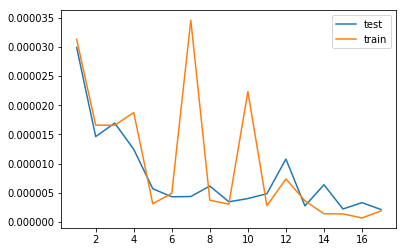

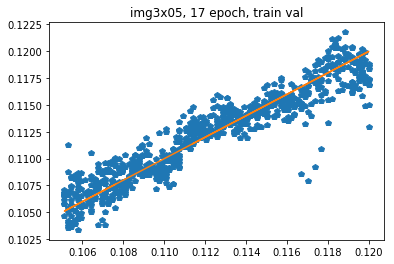

Train Epoch: 18 [0/2030 (0%)]	Loss: 0.000002	 mse: 1.4387304872798268e-05
Train Epoch: 18 [100/2030 (5%)]	Loss: 0.000007	 mse: 1.3356270756048616e-05
Train Epoch: 18 [200/2030 (10%)]	Loss: 0.000001	 mse: 9.767313713382464e-06
Train Epoch: 18 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.7517051421455108e-05
Train Epoch: 18 [400/2030 (20%)]	Loss: 0.000001	 mse: 2.8275166187086143e-05
Train Epoch: 18 [500/2030 (25%)]	Loss: 0.000001	 mse: 1.889508348540403e-05
Train Epoch: 18 [600/2030 (30%)]	Loss: 0.000003	 mse: 6.486179700004868e-06
Train Epoch: 18 [700/2030 (34%)]	Loss: 0.000001	 mse: 1.36913477035705e-05
Train Epoch: 18 [800/2030 (39%)]	Loss: 0.000004	 mse: 2.9489061489584856e-05
Train Epoch: 18 [900/2030 (44%)]	Loss: 0.000001	 mse: 2.719651092775166e-05
Train Epoch: 18 [1000/2030 (49%)]	Loss: 0.000005	 mse: 1.2991460607736371e-05
Train Epoch: 18 [1100/2030 (54%)]	Loss: 0.000007	 mse: 2.8880151148769073e-05
Train Epoch: 18 [1200/2030 (59%)]	Loss: 0.000003	 mse: 1.7915906937560067e-05
Train 

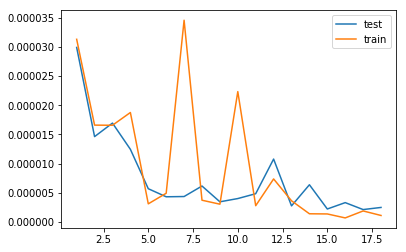

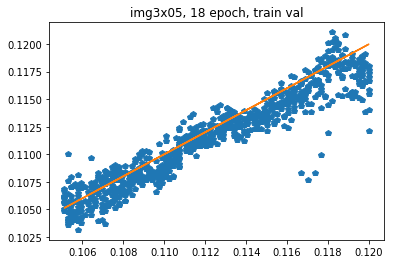

Train Epoch: 19 [0/2030 (0%)]	Loss: 0.000002	 mse: 1.2894111023342703e-05
Train Epoch: 19 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.3460880836646538e-05
Train Epoch: 19 [200/2030 (10%)]	Loss: 0.000001	 mse: 9.745182978804223e-06
Train Epoch: 19 [300/2030 (15%)]	Loss: 0.000002	 mse: 1.8608525351737626e-05
Train Epoch: 19 [400/2030 (20%)]	Loss: 0.000003	 mse: 9.729712473927066e-06
Train Epoch: 19 [500/2030 (25%)]	Loss: 0.000002	 mse: 1.573130975884851e-05
Train Epoch: 19 [600/2030 (30%)]	Loss: 0.000001	 mse: 2.4291695808642544e-05
Train Epoch: 19 [700/2030 (34%)]	Loss: 0.000003	 mse: 2.26468728214968e-05
Train Epoch: 19 [800/2030 (39%)]	Loss: 0.000007	 mse: 1.9688088286784478e-05
Train Epoch: 19 [900/2030 (44%)]	Loss: 0.000004	 mse: 2.5564128009136766e-05
Train Epoch: 19 [1000/2030 (49%)]	Loss: 0.000003	 mse: 1.9377857825020328e-05
Train Epoch: 19 [1100/2030 (54%)]	Loss: 0.000004	 mse: 2.243308517790865e-05
Train Epoch: 19 [1200/2030 (59%)]	Loss: 0.000011	 mse: 2.2319376512314193e-05
Train 

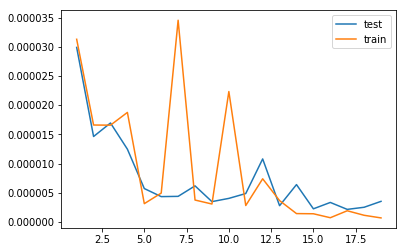

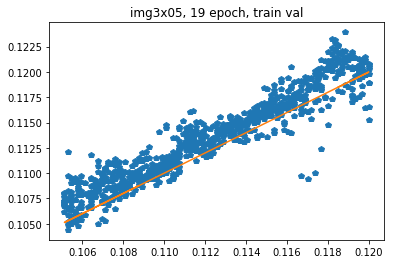

Train Epoch: 20 [0/2030 (0%)]	Loss: 0.000004	 mse: 1.636963861528784e-05
Train Epoch: 20 [100/2030 (5%)]	Loss: 0.000003	 mse: 1.1190160876139998e-05
Train Epoch: 20 [200/2030 (10%)]	Loss: 0.000009	 mse: 1.8136963262804784e-05
Train Epoch: 20 [300/2030 (15%)]	Loss: 0.000006	 mse: 9.150810910796281e-06
Train Epoch: 20 [400/2030 (20%)]	Loss: 0.000001	 mse: 2.042679989244789e-05
Train Epoch: 20 [500/2030 (25%)]	Loss: 0.000003	 mse: 1.5368927051895298e-05
Train Epoch: 20 [600/2030 (30%)]	Loss: 0.000003	 mse: 1.8061766240862198e-05
Train Epoch: 20 [700/2030 (34%)]	Loss: 0.000003	 mse: 2.6031133529613726e-05
Train Epoch: 20 [800/2030 (39%)]	Loss: 0.000001	 mse: 1.2294902262510732e-05
Train Epoch: 20 [900/2030 (44%)]	Loss: 0.000001	 mse: 1.7287879018113017e-05
Train Epoch: 20 [1000/2030 (49%)]	Loss: 0.000001	 mse: 2.1693163944291882e-05
Train Epoch: 20 [1100/2030 (54%)]	Loss: 0.000001	 mse: 1.3283482985571027e-05
Train Epoch: 20 [1200/2030 (59%)]	Loss: 0.000002	 mse: 1.5151793377299327e-05
Tra

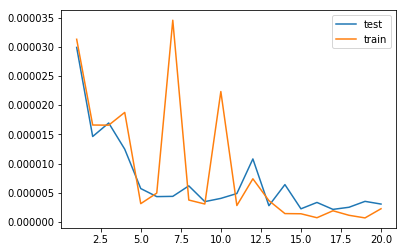

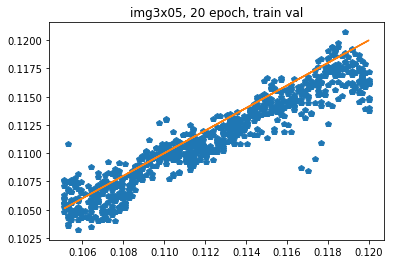

Train Epoch: 21 [0/2030 (0%)]	Loss: 0.000003	 mse: 1.5048693057906348e-05
Train Epoch: 21 [100/2030 (5%)]	Loss: 0.000003	 mse: 2.2320276912068948e-05
Train Epoch: 21 [200/2030 (10%)]	Loss: 0.000004	 mse: 1.3040893463767134e-05
Train Epoch: 21 [300/2030 (15%)]	Loss: 0.000001	 mse: 2.0245153791620396e-05
Train Epoch: 21 [400/2030 (20%)]	Loss: 0.000004	 mse: 1.9354509277036414e-05
Train Epoch: 21 [500/2030 (25%)]	Loss: 0.000001	 mse: 2.8068954634363763e-05
Train Epoch: 21 [600/2030 (30%)]	Loss: 0.000002	 mse: 1.1905825886060484e-05
Train Epoch: 21 [700/2030 (34%)]	Loss: 0.000004	 mse: 3.07678674289491e-05
Train Epoch: 21 [800/2030 (39%)]	Loss: 0.000002	 mse: 1.9525847164914012e-05
Train Epoch: 21 [900/2030 (44%)]	Loss: 0.000001	 mse: 1.743070242810063e-05
Train Epoch: 21 [1000/2030 (49%)]	Loss: 0.000004	 mse: 1.8037511836155318e-05
Train Epoch: 21 [1100/2030 (54%)]	Loss: 0.000002	 mse: 1.7996260794461705e-05
Train Epoch: 21 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.7905293134390377e-05
Tra

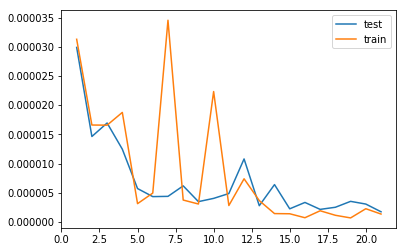

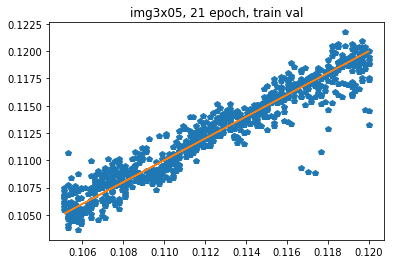

Train Epoch: 22 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.5167254787229467e-05
Train Epoch: 22 [100/2030 (5%)]	Loss: 0.000009	 mse: 1.8910866856458597e-05
Train Epoch: 22 [200/2030 (10%)]	Loss: 0.000001	 mse: 1.7595990357222036e-05
Train Epoch: 22 [300/2030 (15%)]	Loss: 0.000004	 mse: 3.0270241040852852e-05
Train Epoch: 22 [400/2030 (20%)]	Loss: 0.000006	 mse: 2.1137613657629117e-05
Train Epoch: 22 [500/2030 (25%)]	Loss: 0.000002	 mse: 1.2786154002242256e-05
Train Epoch: 22 [600/2030 (30%)]	Loss: 0.000003	 mse: 2.671009315236006e-05
Train Epoch: 22 [700/2030 (34%)]	Loss: 0.000002	 mse: 2.3842891096137464e-05
Train Epoch: 22 [800/2030 (39%)]	Loss: 0.000003	 mse: 2.294527439516969e-05
Train Epoch: 22 [900/2030 (44%)]	Loss: 0.000002	 mse: 2.2344862372847274e-05
Train Epoch: 22 [1000/2030 (49%)]	Loss: 0.000002	 mse: 7.013824870227836e-06
Train Epoch: 22 [1100/2030 (54%)]	Loss: 0.000001	 mse: 1.8123329937225208e-05
Train Epoch: 22 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.732790406094864e-05
Trai

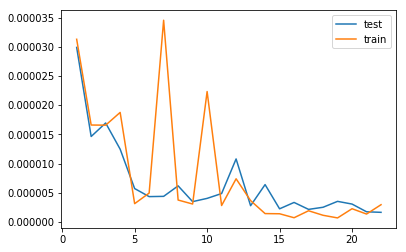

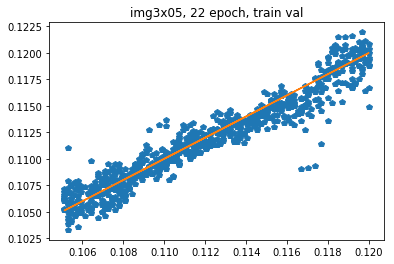

Train Epoch: 23 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.8219452613266185e-05
Train Epoch: 23 [100/2030 (5%)]	Loss: 0.000001	 mse: 2.5554420062690042e-05
Train Epoch: 23 [200/2030 (10%)]	Loss: 0.000001	 mse: 2.231332109658979e-05
Train Epoch: 23 [300/2030 (15%)]	Loss: 0.000003	 mse: 1.661920759943314e-05
Train Epoch: 23 [400/2030 (20%)]	Loss: 0.000003	 mse: 2.3057775251800194e-05
Train Epoch: 23 [500/2030 (25%)]	Loss: 0.000002	 mse: 2.8506530725280754e-05
Train Epoch: 23 [600/2030 (30%)]	Loss: 0.000003	 mse: 1.6655607396387495e-05
Train Epoch: 23 [700/2030 (34%)]	Loss: 0.000001	 mse: 2.0432862584129907e-05
Train Epoch: 23 [800/2030 (39%)]	Loss: 0.000003	 mse: 2.293314719281625e-05
Train Epoch: 23 [900/2030 (44%)]	Loss: 0.000001	 mse: 1.3361417586565949e-05
Train Epoch: 23 [1000/2030 (49%)]	Loss: 0.000000	 mse: 2.228145967819728e-05
Train Epoch: 23 [1100/2030 (54%)]	Loss: 0.000002	 mse: 2.6413219529786147e-05
Train Epoch: 23 [1200/2030 (59%)]	Loss: 0.000000	 mse: 1.6800264347693883e-05
Trai

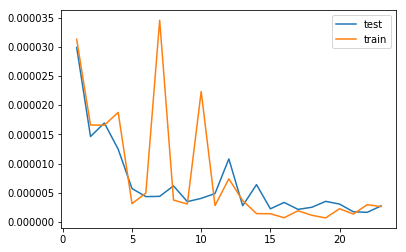

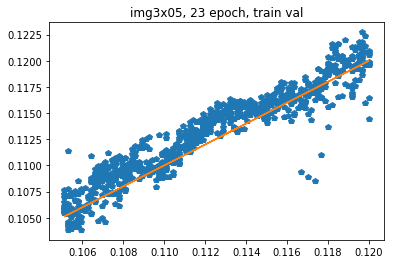

Train Epoch: 24 [0/2030 (0%)]	Loss: 0.000003	 mse: 2.7906127797905356e-05
Train Epoch: 24 [100/2030 (5%)]	Loss: 0.000002	 mse: 2.799103458528407e-05
Train Epoch: 24 [200/2030 (10%)]	Loss: 0.000002	 mse: 2.8985665267100558e-05
Train Epoch: 24 [300/2030 (15%)]	Loss: 0.000002	 mse: 1.9291437638457865e-05
Train Epoch: 24 [400/2030 (20%)]	Loss: 0.000003	 mse: 1.595236790308263e-05
Train Epoch: 24 [500/2030 (25%)]	Loss: 0.000002	 mse: 1.4803355043113697e-05
Train Epoch: 24 [600/2030 (30%)]	Loss: 0.000006	 mse: 1.660737871134188e-05
Train Epoch: 24 [700/2030 (34%)]	Loss: 0.000001	 mse: 1.1662930774036795e-05
Train Epoch: 24 [800/2030 (39%)]	Loss: 0.000009	 mse: 2.17880769923795e-05
Train Epoch: 24 [900/2030 (44%)]	Loss: 0.000004	 mse: 1.3570047485700343e-05
Train Epoch: 24 [1000/2030 (49%)]	Loss: 0.000005	 mse: 1.718355815683026e-05
Train Epoch: 24 [1100/2030 (54%)]	Loss: 0.000007	 mse: 2.3170890926849097e-05
Train Epoch: 24 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.4798815755057149e-05
Train 

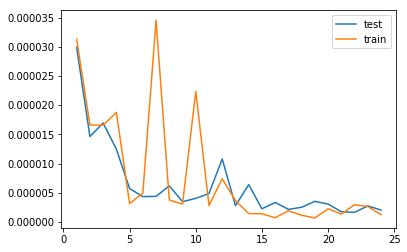

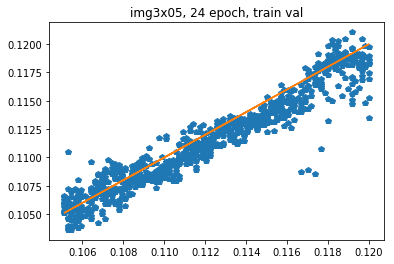

Train Epoch: 25 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.3520010725187603e-05
Train Epoch: 25 [100/2030 (5%)]	Loss: 0.000001	 mse: 1.9312061340315267e-05
Train Epoch: 25 [200/2030 (10%)]	Loss: 0.000002	 mse: 2.539522756705992e-05
Train Epoch: 25 [300/2030 (15%)]	Loss: 0.000001	 mse: 1.960348708962556e-05
Train Epoch: 25 [400/2030 (20%)]	Loss: 0.000002	 mse: 1.260420322068967e-05
Train Epoch: 25 [500/2030 (25%)]	Loss: 0.000001	 mse: 1.5169681319093797e-05
Train Epoch: 25 [600/2030 (30%)]	Loss: 0.000004	 mse: 2.196608875237871e-05
Train Epoch: 25 [700/2030 (34%)]	Loss: 0.000000	 mse: 1.785797758202534e-05
Train Epoch: 25 [800/2030 (39%)]	Loss: 0.000002	 mse: 2.2525569875142537e-05
Train Epoch: 25 [900/2030 (44%)]	Loss: 0.000008	 mse: 1.589293788128998e-05
Train Epoch: 25 [1000/2030 (49%)]	Loss: 0.000003	 mse: 1.4440674931393005e-05
Train Epoch: 25 [1100/2030 (54%)]	Loss: 0.000000	 mse: 6.237514753593132e-06
Train Epoch: 25 [1200/2030 (59%)]	Loss: 0.000000	 mse: 1.666652133280877e-05
Train Ep

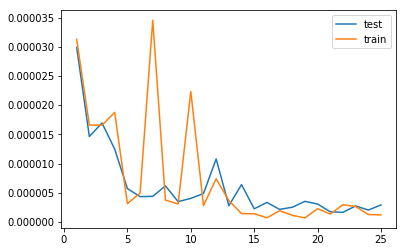

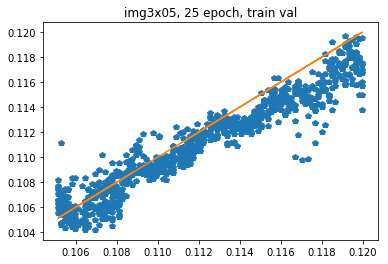

Train Epoch: 26 [0/2030 (0%)]	Loss: 0.000003	 mse: 2.5219633243978024e-05
Train Epoch: 26 [100/2030 (5%)]	Loss: 0.000003	 mse: 2.5311817807960324e-05
Train Epoch: 26 [200/2030 (10%)]	Loss: 0.000001	 mse: 1.4776972420804668e-05
Train Epoch: 26 [300/2030 (15%)]	Loss: 0.000003	 mse: 3.210914655937813e-05
Train Epoch: 26 [400/2030 (20%)]	Loss: 0.000011	 mse: 1.0197933988820296e-05
Train Epoch: 26 [500/2030 (25%)]	Loss: 0.000003	 mse: 1.8458413251210004e-05
Train Epoch: 26 [600/2030 (30%)]	Loss: 0.000003	 mse: 2.5268152967328206e-05
Train Epoch: 26 [700/2030 (34%)]	Loss: 0.000001	 mse: 1.5737370631541125e-05
Train Epoch: 26 [800/2030 (39%)]	Loss: 0.000003	 mse: 1.7942888007382862e-05
Train Epoch: 26 [900/2030 (44%)]	Loss: 0.000002	 mse: 1.8814736904460005e-05
Train Epoch: 26 [1000/2030 (49%)]	Loss: 0.000002	 mse: 1.4557134818460327e-05
Train Epoch: 26 [1100/2030 (54%)]	Loss: 0.000005	 mse: 2.6679768780013546e-05
Train Epoch: 26 [1200/2030 (59%)]	Loss: 0.000007	 mse: 1.7685726561467163e-05
T

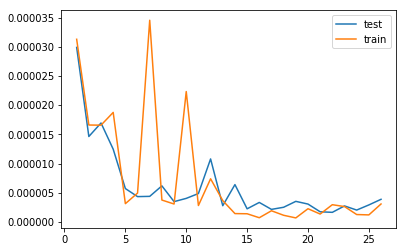

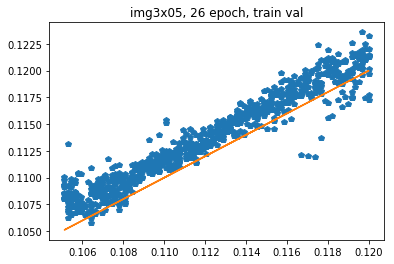

Train Epoch: 27 [0/2030 (0%)]	Loss: 0.000002	 mse: 2.015507925534621e-05
Train Epoch: 27 [100/2030 (5%)]	Loss: 0.000001	 mse: 1.0786226994241588e-05
Train Epoch: 27 [200/2030 (10%)]	Loss: 0.000002	 mse: 9.827966096054297e-06
Train Epoch: 27 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.0468038201215677e-05
Train Epoch: 27 [400/2030 (20%)]	Loss: 0.000001	 mse: 1.6357515050913207e-05
Train Epoch: 27 [500/2030 (25%)]	Loss: 0.000003	 mse: 1.028890983434394e-05
Train Epoch: 27 [600/2030 (30%)]	Loss: 0.000002	 mse: 2.2889174942974932e-05
Train Epoch: 27 [700/2030 (34%)]	Loss: 0.000001	 mse: 8.079749932221603e-06
Train Epoch: 27 [800/2030 (39%)]	Loss: 0.000005	 mse: 1.647274439164903e-05
Train Epoch: 27 [900/2030 (44%)]	Loss: 0.000001	 mse: 2.3051710741128772e-05
Train Epoch: 27 [1000/2030 (49%)]	Loss: 0.000005	 mse: 2.513958497729618e-05
Train Epoch: 27 [1100/2030 (54%)]	Loss: 0.000002	 mse: 9.467712516197935e-06
Train Epoch: 27 [1200/2030 (59%)]	Loss: 0.000005	 mse: 2.288917858095374e-05
Train Ep

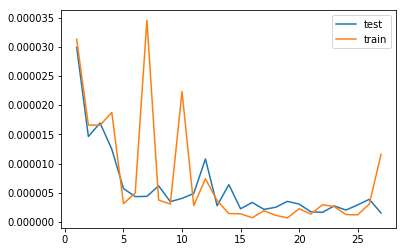

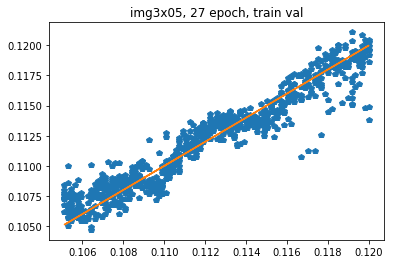

Train Epoch: 28 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.7245421986444853e-05
Train Epoch: 28 [100/2030 (5%)]	Loss: 0.000006	 mse: 1.9653214621939696e-05
Train Epoch: 28 [200/2030 (10%)]	Loss: 0.000003	 mse: 2.1597636077785864e-05
Train Epoch: 28 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.5667228328529745e-05
Train Epoch: 28 [400/2030 (20%)]	Loss: 0.000003	 mse: 2.1598540115519427e-05
Train Epoch: 28 [500/2030 (25%)]	Loss: 0.000003	 mse: 1.733397220959887e-05
Train Epoch: 28 [600/2030 (30%)]	Loss: 0.000003	 mse: 2.8232710974407382e-05
Train Epoch: 28 [700/2030 (34%)]	Loss: 0.000002	 mse: 1.0246455531159882e-05
Train Epoch: 28 [800/2030 (39%)]	Loss: 0.000004	 mse: 3.27110719808843e-05
Train Epoch: 28 [900/2030 (44%)]	Loss: 0.000002	 mse: 2.4261367798317224e-05
Train Epoch: 28 [1000/2030 (49%)]	Loss: 0.000000	 mse: 2.1405983716249466e-05
Train Epoch: 28 [1100/2030 (54%)]	Loss: 0.000002	 mse: 2.982749356306158e-05
Train Epoch: 28 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.61452353495406e-05
Train 

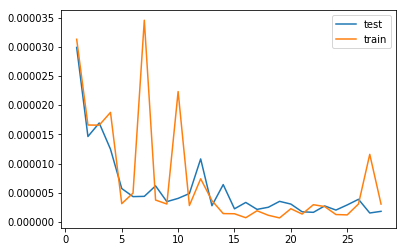

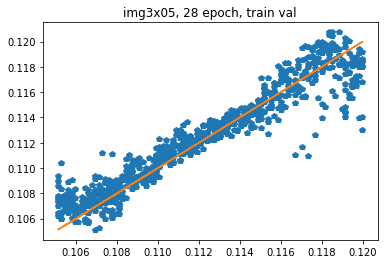

Train Epoch: 29 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.259965847566491e-05
Train Epoch: 29 [100/2030 (5%)]	Loss: 0.000001	 mse: 2.0599332856363617e-05
Train Epoch: 29 [200/2030 (10%)]	Loss: 0.000001	 mse: 1.8998196537722833e-05
Train Epoch: 29 [300/2030 (15%)]	Loss: 0.000001	 mse: 1.609065839147661e-05
Train Epoch: 29 [400/2030 (20%)]	Loss: 0.000002	 mse: 3.6174184060655534e-05
Train Epoch: 29 [500/2030 (25%)]	Loss: 0.000004	 mse: 1.1972534593951423e-05
Train Epoch: 29 [600/2030 (30%)]	Loss: 0.000001	 mse: 2.0772500647581182e-05
Train Epoch: 29 [700/2030 (34%)]	Loss: 0.000001	 mse: 2.1408117390819825e-05
Train Epoch: 29 [800/2030 (39%)]	Loss: 0.000007	 mse: 2.025212234002538e-05
Train Epoch: 29 [900/2030 (44%)]	Loss: 0.000002	 mse: 9.958675946108997e-06
Train Epoch: 29 [1000/2030 (49%)]	Loss: 0.000003	 mse: 1.831739609770011e-05
Train Epoch: 29 [1100/2030 (54%)]	Loss: 0.000002	 mse: 2.2972866645432077e-05
Train Epoch: 29 [1200/2030 (59%)]	Loss: 0.000002	 mse: 1.4012806786922738e-05
Train

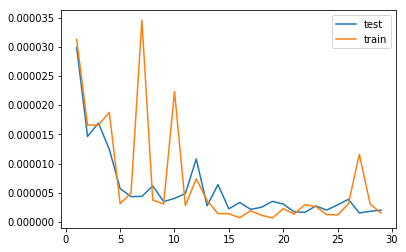

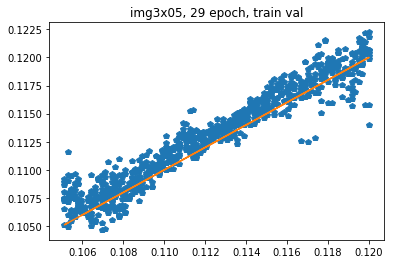

Train Epoch: 30 [0/2030 (0%)]	Loss: 0.000002	 mse: 1.828617496357765e-05
Train Epoch: 30 [100/2030 (5%)]	Loss: 0.000009	 mse: 1.3853598829882685e-05
Train Epoch: 30 [200/2030 (10%)]	Loss: 0.000003	 mse: 1.856758535723202e-05
Train Epoch: 30 [300/2030 (15%)]	Loss: 0.000006	 mse: 1.1178030945302453e-05
Train Epoch: 30 [400/2030 (20%)]	Loss: 0.000012	 mse: 2.0577210307237692e-05
Train Epoch: 30 [500/2030 (25%)]	Loss: 0.000002	 mse: 2.4752329409238882e-05
Train Epoch: 30 [600/2030 (30%)]	Loss: 0.000003	 mse: 1.757050813466776e-05
Train Epoch: 30 [700/2030 (34%)]	Loss: 0.000002	 mse: 1.7891647075884975e-05
Train Epoch: 30 [800/2030 (39%)]	Loss: 0.000003	 mse: 1.002416593109956e-05
Train Epoch: 30 [900/2030 (44%)]	Loss: 0.000003	 mse: 1.1232615179324057e-05
Train Epoch: 30 [1000/2030 (49%)]	Loss: 0.000003	 mse: 1.8972728867083788e-05
Train Epoch: 30 [1100/2030 (54%)]	Loss: 0.000001	 mse: 1.1342701327521354e-05
Train Epoch: 30 [1200/2030 (59%)]	Loss: 0.000006	 mse: 3.395804014871828e-05
Train

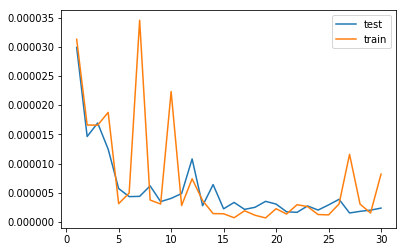

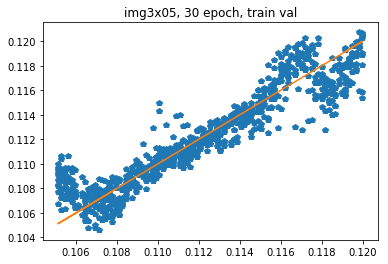

Train Epoch: 31 [0/2030 (0%)]	Loss: 0.000003	 mse: 2.2363043171935715e-05
Train Epoch: 31 [100/2030 (5%)]	Loss: 0.000002	 mse: 2.0316412701504305e-05
Train Epoch: 31 [200/2030 (10%)]	Loss: 0.000008	 mse: 2.1471179934451357e-05
Train Epoch: 31 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.8318914953852072e-05
Train Epoch: 31 [400/2030 (20%)]	Loss: 0.000003	 mse: 2.165070691262372e-05
Train Epoch: 31 [500/2030 (25%)]	Loss: 0.000003	 mse: 1.824614082579501e-05
Train Epoch: 31 [600/2030 (30%)]	Loss: 0.000002	 mse: 2.4400567781412974e-05
Train Epoch: 31 [700/2030 (34%)]	Loss: 0.000002	 mse: 2.5971390641643666e-05
Train Epoch: 31 [800/2030 (39%)]	Loss: 0.000001	 mse: 1.5870795323280618e-05
Train Epoch: 31 [900/2030 (44%)]	Loss: 0.000001	 mse: 1.6794187104096636e-05
Train Epoch: 31 [1000/2030 (49%)]	Loss: 0.000001	 mse: 1.0798366020026151e-05
Train Epoch: 31 [1100/2030 (54%)]	Loss: 0.000001	 mse: 2.091230453515891e-05
Train Epoch: 31 [1200/2030 (59%)]	Loss: 0.000000	 mse: 2.3589367629028857e-05
Tra

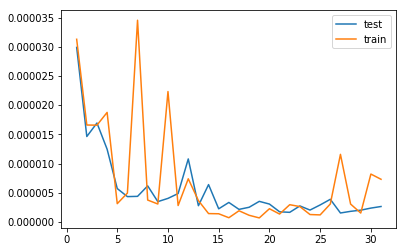

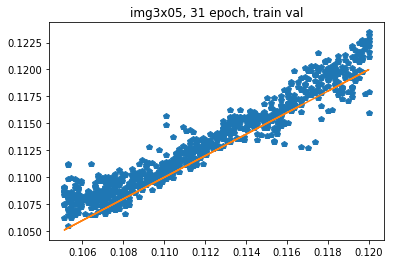

Train Epoch: 32 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.9816981875919737e-05
Train Epoch: 32 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.2132657502661459e-05
Train Epoch: 32 [200/2030 (10%)]	Loss: 0.000004	 mse: 1.6111267541418783e-05
Train Epoch: 32 [300/2030 (15%)]	Loss: 0.000003	 mse: 2.4000271878321655e-05
Train Epoch: 32 [400/2030 (20%)]	Loss: 0.000004	 mse: 1.8561513570602983e-05
Train Epoch: 32 [500/2030 (25%)]	Loss: 0.000002	 mse: 2.3503245756728575e-05
Train Epoch: 32 [600/2030 (30%)]	Loss: 0.000002	 mse: 2.2478272512671538e-05
Train Epoch: 32 [700/2030 (34%)]	Loss: 0.000002	 mse: 2.492971543688327e-05
Train Epoch: 32 [800/2030 (39%)]	Loss: 0.000007	 mse: 2.4755967388045974e-05
Train Epoch: 32 [900/2030 (44%)]	Loss: 0.000001	 mse: 2.755587047431618e-05
Train Epoch: 32 [1000/2030 (49%)]	Loss: 0.000001	 mse: 1.623591197130736e-05
Train Epoch: 32 [1100/2030 (54%)]	Loss: 0.000003	 mse: 1.0941501386696473e-05
Train Epoch: 32 [1200/2030 (59%)]	Loss: 0.000002	 mse: 2.3394080926664174e-05
Tra

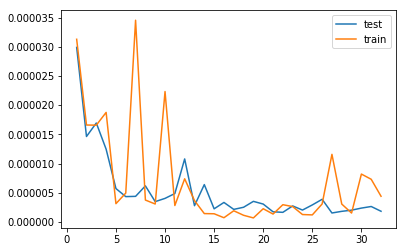

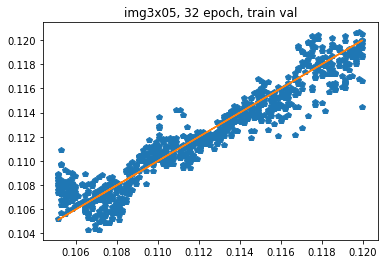

Train Epoch: 33 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.3361420315050054e-05
Train Epoch: 33 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.8078440916724503e-05
Train Epoch: 33 [200/2030 (10%)]	Loss: 0.000001	 mse: 1.7748809113982134e-05
Train Epoch: 33 [300/2030 (15%)]	Loss: 0.000001	 mse: 1.736520789563656e-05
Train Epoch: 33 [400/2030 (20%)]	Loss: 0.000004	 mse: 1.8203674699179828e-05
Train Epoch: 33 [500/2030 (25%)]	Loss: 0.000000	 mse: 1.6533089365111664e-05
Train Epoch: 33 [600/2030 (30%)]	Loss: 0.000004	 mse: 8.110370799840894e-06
Train Epoch: 33 [700/2030 (34%)]	Loss: 0.000002	 mse: 1.5236709259625059e-05
Train Epoch: 33 [800/2030 (39%)]	Loss: 0.000001	 mse: 1.572645123815164e-05
Train Epoch: 33 [900/2030 (44%)]	Loss: 0.000001	 mse: 2.7135873096995056e-05
Train Epoch: 33 [1000/2030 (49%)]	Loss: 0.000001	 mse: 1.5351632100646384e-05
Train Epoch: 33 [1100/2030 (54%)]	Loss: 0.000007	 mse: 1.4939224456611555e-05
Train Epoch: 33 [1200/2030 (59%)]	Loss: 0.000001	 mse: 7.996353815542534e-06
Trai

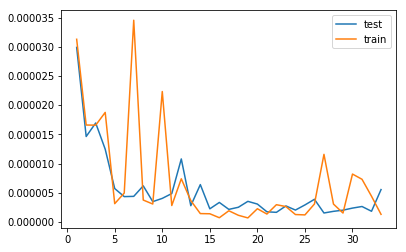

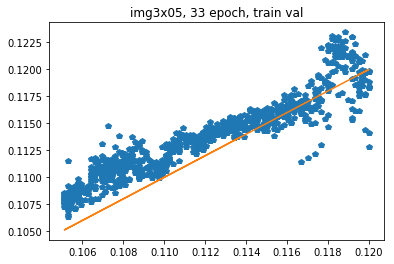

Train Epoch: 34 [0/2030 (0%)]	Loss: 0.000002	 mse: 1.1523729881446343e-05
Train Epoch: 34 [100/2030 (5%)]	Loss: 0.000002	 mse: 1.4442189240071457e-05
Train Epoch: 34 [200/2030 (10%)]	Loss: 0.000000	 mse: 1.475483804824762e-05
Train Epoch: 34 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.593255885585677e-05
Train Epoch: 34 [400/2030 (20%)]	Loss: 0.000003	 mse: 1.1869135960296262e-05
Train Epoch: 34 [500/2030 (25%)]	Loss: 0.000005	 mse: 1.8165774235967547e-05
Train Epoch: 34 [600/2030 (30%)]	Loss: 0.000002	 mse: 1.4538021787302569e-05
Train Epoch: 34 [700/2030 (34%)]	Loss: 0.000003	 mse: 2.6189727577730082e-05
Train Epoch: 34 [800/2030 (39%)]	Loss: 0.000003	 mse: 2.2281456040218472e-05
Train Epoch: 34 [900/2030 (44%)]	Loss: 0.000003	 mse: 1.9638353478512727e-05
Train Epoch: 34 [1000/2030 (49%)]	Loss: 0.000001	 mse: 9.577790478942916e-06
Train Epoch: 34 [1100/2030 (54%)]	Loss: 0.000001	 mse: 2.2606836864724755e-05
Train Epoch: 34 [1200/2030 (59%)]	Loss: 0.000003	 mse: 1.527643144072499e-05
Trai

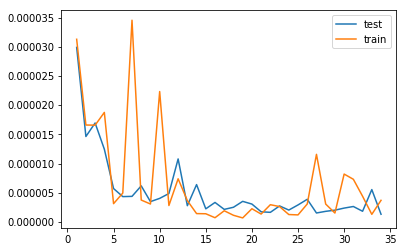

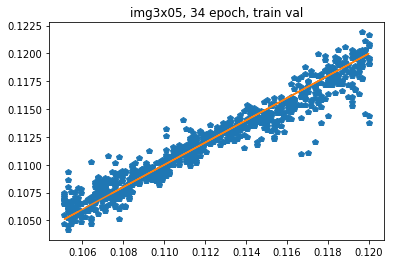

Train Epoch: 35 [0/2030 (0%)]	Loss: 0.000001	 mse: 3.476559140835889e-05
Train Epoch: 35 [100/2030 (5%)]	Loss: 0.000003	 mse: 1.351395076198969e-05
Train Epoch: 35 [200/2030 (10%)]	Loss: 0.000003	 mse: 1.783827792678494e-05
Train Epoch: 35 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.8209349693497643e-05
Train Epoch: 35 [400/2030 (20%)]	Loss: 0.000001	 mse: 1.9277176761534065e-05
Train Epoch: 35 [500/2030 (25%)]	Loss: 0.000002	 mse: 2.4291695808642544e-05
Train Epoch: 35 [600/2030 (30%)]	Loss: 0.000001	 mse: 2.1004172594984993e-05
Train Epoch: 35 [700/2030 (34%)]	Loss: 0.000001	 mse: 8.572518709115684e-06
Train Epoch: 35 [800/2030 (39%)]	Loss: 0.000006	 mse: 1.8337106666876934e-05
Train Epoch: 35 [900/2030 (44%)]	Loss: 0.000001	 mse: 9.419190064363647e-06
Train Epoch: 35 [1000/2030 (49%)]	Loss: 0.000002	 mse: 2.662519364093896e-05
Train Epoch: 35 [1100/2030 (54%)]	Loss: 0.000002	 mse: 2.682685590116307e-05
Train Epoch: 35 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.9189848899259232e-05
Train E

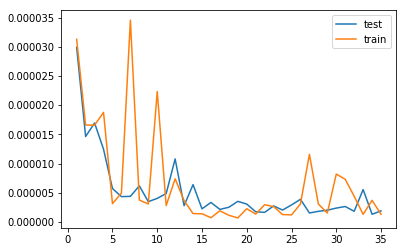

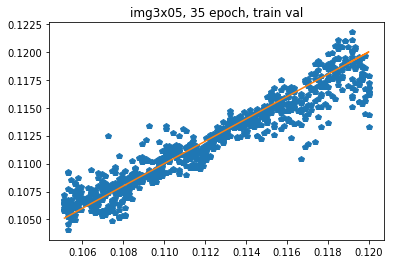

Train Epoch: 36 [0/2030 (0%)]	Loss: 0.000000	 mse: 1.5339510355261154e-05
Train Epoch: 36 [100/2030 (5%)]	Loss: 0.000002	 mse: 2.404637234576512e-05
Train Epoch: 36 [200/2030 (10%)]	Loss: 0.000002	 mse: 1.6322032024618238e-05
Train Epoch: 36 [300/2030 (15%)]	Loss: 0.000002	 mse: 8.154042006935924e-06
Train Epoch: 36 [400/2030 (20%)]	Loss: 0.000001	 mse: 1.303481803915929e-05
Train Epoch: 36 [500/2030 (25%)]	Loss: 0.000005	 mse: 1.8318909496883862e-05
Train Epoch: 36 [600/2030 (30%)]	Loss: 0.000000	 mse: 9.558383680996485e-06
Train Epoch: 36 [700/2030 (34%)]	Loss: 0.000001	 mse: 1.5979969248292036e-05
Train Epoch: 36 [800/2030 (39%)]	Loss: 0.000001	 mse: 1.4148343325359747e-05
Train Epoch: 36 [900/2030 (44%)]	Loss: 0.000000	 mse: 2.125284845533315e-05
Train Epoch: 36 [1000/2030 (49%)]	Loss: 0.000001	 mse: 2.3340709958574735e-05
Train Epoch: 36 [1100/2030 (54%)]	Loss: 0.000003	 mse: 1.867675564426463e-05
Train Epoch: 36 [1200/2030 (59%)]	Loss: 0.000007	 mse: 1.8254320821142755e-05
Train 

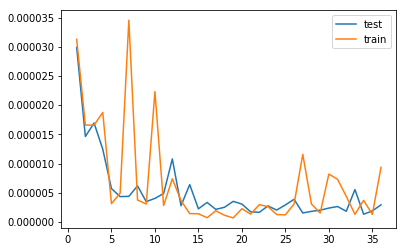

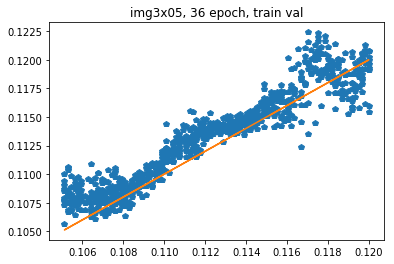

Train Epoch: 37 [0/2030 (0%)]	Loss: 0.000003	 mse: 2.1246787582640536e-05
Train Epoch: 37 [100/2030 (5%)]	Loss: 0.000002	 mse: 2.2071619241614826e-05
Train Epoch: 37 [200/2030 (10%)]	Loss: 0.000014	 mse: 2.4048800696618855e-05
Train Epoch: 37 [300/2030 (15%)]	Loss: 0.000005	 mse: 2.1029956769780256e-05
Train Epoch: 37 [400/2030 (20%)]	Loss: 0.000002	 mse: 1.5975114365573972e-05
Train Epoch: 37 [500/2030 (25%)]	Loss: 0.000001	 mse: 1.8984563212143257e-05
Train Epoch: 37 [600/2030 (30%)]	Loss: 0.000002	 mse: 1.998072548303753e-05
Train Epoch: 37 [700/2030 (34%)]	Loss: 0.000002	 mse: 2.801286245812662e-05
Train Epoch: 37 [800/2030 (39%)]	Loss: 0.000002	 mse: 2.1399921024567448e-05
Train Epoch: 37 [900/2030 (44%)]	Loss: 0.000000	 mse: 1.3652534107677639e-05
Train Epoch: 37 [1000/2030 (49%)]	Loss: 0.000005	 mse: 1.9631082977866754e-05
Train Epoch: 37 [1100/2030 (54%)]	Loss: 0.000004	 mse: 1.583106495672837e-05
Train Epoch: 37 [1200/2030 (59%)]	Loss: 0.000001	 mse: 1.465416880819248e-05
Trai

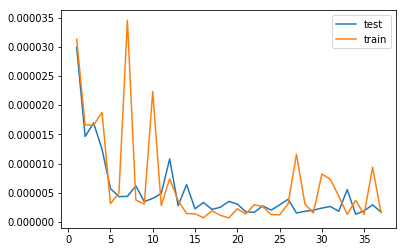

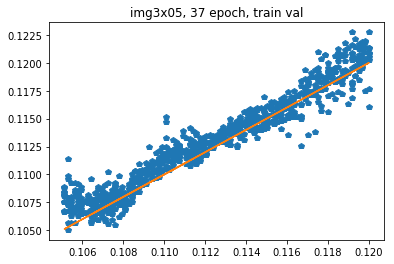

Train Epoch: 38 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.547899955767207e-05
Train Epoch: 38 [100/2030 (5%)]	Loss: 0.000001	 mse: 1.800808786356356e-05
Train Epoch: 38 [200/2030 (10%)]	Loss: 0.000002	 mse: 1.673808765190188e-05
Train Epoch: 38 [300/2030 (15%)]	Loss: 0.000001	 mse: 1.1171669029863551e-05
Train Epoch: 38 [400/2030 (20%)]	Loss: 0.000004	 mse: 1.8371078112977557e-05
Train Epoch: 38 [500/2030 (25%)]	Loss: 0.000001	 mse: 2.3762839191476814e-05
Train Epoch: 38 [600/2030 (30%)]	Loss: 0.000001	 mse: 7.921139513200615e-06
Train Epoch: 38 [700/2030 (34%)]	Loss: 0.000006	 mse: 1.81066534423735e-05
Train Epoch: 38 [800/2030 (39%)]	Loss: 0.000003	 mse: 2.456432230246719e-05
Train Epoch: 38 [900/2030 (44%)]	Loss: 0.000002	 mse: 2.1095454940223135e-05
Train Epoch: 38 [1000/2030 (49%)]	Loss: 0.000000	 mse: 1.1039452147088014e-05
Train Epoch: 38 [1100/2030 (54%)]	Loss: 0.000001	 mse: 2.6279789381078444e-05
Train Epoch: 38 [1200/2030 (59%)]	Loss: 0.000001	 mse: 2.2090112906880677e-05
Train E

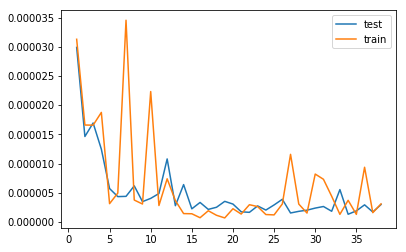

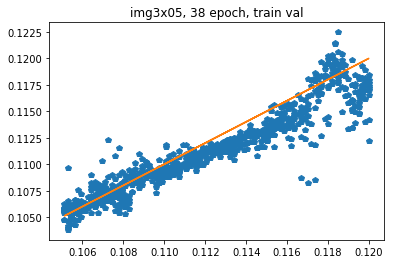

Train Epoch: 39 [0/2030 (0%)]	Loss: 0.000001	 mse: 2.6587598767946474e-05
Train Epoch: 39 [100/2030 (5%)]	Loss: 0.000004	 mse: 2.3545697331428528e-05
Train Epoch: 39 [200/2030 (10%)]	Loss: 0.000002	 mse: 1.9149822037434205e-05
Train Epoch: 39 [300/2030 (15%)]	Loss: 0.000002	 mse: 1.8106649804394692e-05
Train Epoch: 39 [400/2030 (20%)]	Loss: 0.000001	 mse: 1.3118815331836231e-05
Train Epoch: 39 [500/2030 (25%)]	Loss: 0.000000	 mse: 1.590384817973245e-05
Train Epoch: 39 [600/2030 (30%)]	Loss: 0.000003	 mse: 1.4240530617826153e-05
Train Epoch: 39 [700/2030 (34%)]	Loss: 0.000002	 mse: 1.647122007852886e-05
Train Epoch: 39 [800/2030 (39%)]	Loss: 0.000001	 mse: 1.456927384424489e-05
Train Epoch: 39 [900/2030 (44%)]	Loss: 0.000004	 mse: 2.1489697246579453e-05
Train Epoch: 39 [1000/2030 (49%)]	Loss: 0.000003	 mse: 1.0149419722438324e-05
Train Epoch: 39 [1100/2030 (54%)]	Loss: 0.000004	 mse: 1.7512271369923837e-05
Train Epoch: 39 [1200/2030 (59%)]	Loss: 0.000002	 mse: 2.122890145983547e-05
Trai

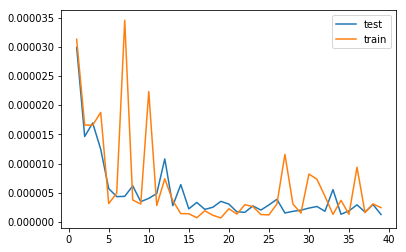

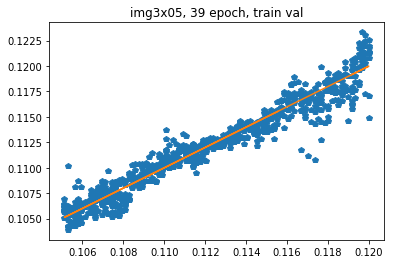

Train Epoch: 40 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.3632816262543201e-05
Train Epoch: 40 [100/2030 (5%)]	Loss: 0.000001	 mse: 1.182061623694608e-05
Train Epoch: 40 [200/2030 (10%)]	Loss: 0.000001	 mse: 9.24451796890935e-06
Train Epoch: 40 [300/2030 (15%)]	Loss: 0.000001	 mse: 1.4785165149078239e-05
Train Epoch: 40 [400/2030 (20%)]	Loss: 0.000003	 mse: 2.0596906324499287e-05
Train Epoch: 40 [500/2030 (25%)]	Loss: 0.000003	 mse: 2.5212051696144044e-05
Train Epoch: 40 [600/2030 (30%)]	Loss: 0.000006	 mse: 1.0697387551772408e-05
Train Epoch: 40 [700/2030 (34%)]	Loss: 0.000001	 mse: 1.0565469892753754e-05
Train Epoch: 40 [800/2030 (39%)]	Loss: 0.000002	 mse: 2.191543171647936e-05
Train Epoch: 40 [900/2030 (44%)]	Loss: 0.000003	 mse: 1.283011897612596e-05
Train Epoch: 40 [1000/2030 (49%)]	Loss: 0.000003	 mse: 2.3023827452561818e-05
Train Epoch: 40 [1100/2030 (54%)]	Loss: 0.000006	 mse: 2.2922229618416168e-05
Train Epoch: 40 [1200/2030 (59%)]	Loss: 0.000002	 mse: 1.851056731538847e-05
Train 

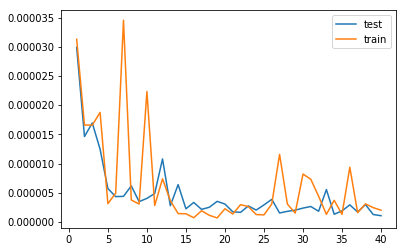

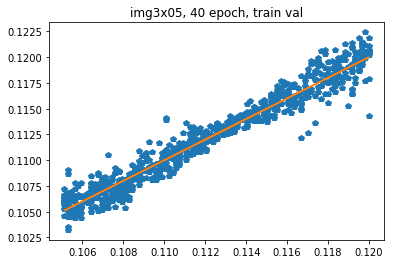

Train Epoch: 41 [0/2030 (0%)]	Loss: 0.000000	 mse: 1.6957630577962846e-05
Train Epoch: 41 [100/2030 (5%)]	Loss: 0.000002	 mse: 2.55726099567255e-05
Train Epoch: 41 [200/2030 (10%)]	Loss: 0.000000	 mse: 1.6910333215491846e-05
Train Epoch: 41 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.970892637677025e-05
Train Epoch: 41 [400/2030 (20%)]	Loss: 0.000003	 mse: 1.3039673831372056e-05
Train Epoch: 41 [500/2030 (25%)]	Loss: 0.000004	 mse: 1.9997405615868047e-05
Train Epoch: 41 [600/2030 (30%)]	Loss: 0.000003	 mse: 1.3927886357123498e-05
Train Epoch: 41 [700/2030 (34%)]	Loss: 0.000002	 mse: 1.4180189282342326e-05
Train Epoch: 41 [800/2030 (39%)]	Loss: 0.000001	 mse: 1.7637217752053402e-05
Train Epoch: 41 [900/2030 (44%)]	Loss: 0.000001	 mse: 1.566852370160632e-05
Train Epoch: 41 [1000/2030 (49%)]	Loss: 0.000002	 mse: 2.2602918761549518e-05
Train Epoch: 41 [1100/2030 (54%)]	Loss: 0.000003	 mse: 1.5561485270154662e-05
Train Epoch: 41 [1200/2030 (59%)]	Loss: 0.000003	 mse: 2.3821976355975494e-05
Trai

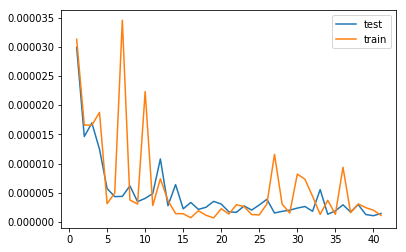

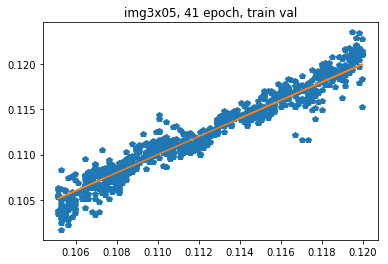

Train Epoch: 42 [0/2030 (0%)]	Loss: 0.000002	 mse: 6.433713679143693e-06
Train Epoch: 42 [100/2030 (5%)]	Loss: 0.000001	 mse: 2.2940430426388048e-05
Train Epoch: 42 [200/2030 (10%)]	Loss: 0.000001	 mse: 2.1711370209231973e-05
Train Epoch: 42 [300/2030 (15%)]	Loss: 0.000002	 mse: 2.501343078620266e-05
Train Epoch: 42 [400/2030 (20%)]	Loss: 0.000001	 mse: 2.6561207050690427e-05
Train Epoch: 42 [500/2030 (25%)]	Loss: 0.000002	 mse: 2.855658021871932e-05
Train Epoch: 42 [600/2030 (30%)]	Loss: 0.000003	 mse: 1.6249559848802164e-05
Train Epoch: 42 [700/2030 (34%)]	Loss: 0.000000	 mse: 1.868616345745977e-05
Train Epoch: 42 [800/2030 (39%)]	Loss: 0.000001	 mse: 1.2513241017586552e-05
Train Epoch: 42 [900/2030 (44%)]	Loss: 0.000001	 mse: 6.313931407930795e-06
Train Epoch: 42 [1000/2030 (49%)]	Loss: 0.000001	 mse: 1.5068090760905761e-05
Train Epoch: 42 [1100/2030 (54%)]	Loss: 0.000000	 mse: 2.118522024829872e-05
Train Epoch: 42 [1200/2030 (59%)]	Loss: 0.000002	 mse: 3.335002111271024e-05
Train E

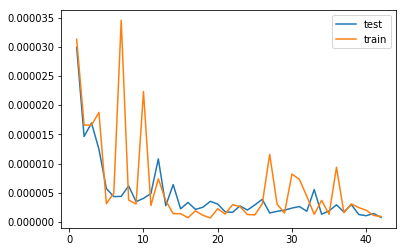

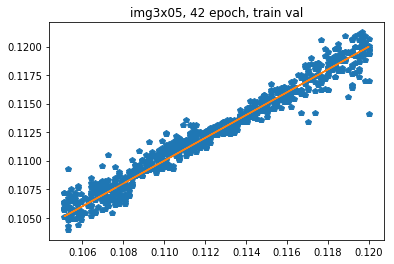

Train Epoch: 43 [0/2030 (0%)]	Loss: 0.000001	 mse: 1.7873748220154084e-05
Train Epoch: 43 [100/2030 (5%)]	Loss: 0.000001	 mse: 9.407970537722576e-06
Train Epoch: 43 [200/2030 (10%)]	Loss: 0.000001	 mse: 3.685949923237786e-05
Train Epoch: 43 [300/2030 (15%)]	Loss: 0.000000	 mse: 1.0040239430963993e-05
Train Epoch: 43 [400/2030 (20%)]	Loss: 0.000001	 mse: 1.8517552234698087e-05
Train Epoch: 43 [500/2030 (25%)]	Loss: 0.000001	 mse: 1.904671262309421e-05
Train Epoch: 43 [600/2030 (30%)]	Loss: 0.000000	 mse: 1.4666298739030026e-05
Train Epoch: 43 [700/2030 (34%)]	Loss: 0.000001	 mse: 2.3672764655202627e-05
Train Epoch: 43 [800/2030 (39%)]	Loss: 0.000002	 mse: 1.9556176994228736e-05
Train Epoch: 43 [900/2030 (44%)]	Loss: 0.000002	 mse: 2.109879642375745e-05
Train Epoch: 43 [1000/2030 (49%)]	Loss: 0.000001	 mse: 1.0220675903838128e-05
Train Epoch: 43 [1100/2030 (54%)]	Loss: 0.000004	 mse: 1.3573687283496838e-05
Train Epoch: 43 [1200/2030 (59%)]	Loss: 0.000003	 mse: 1.8644008378032595e-05
Trai

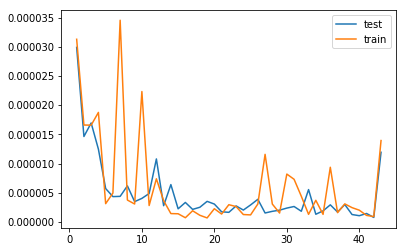

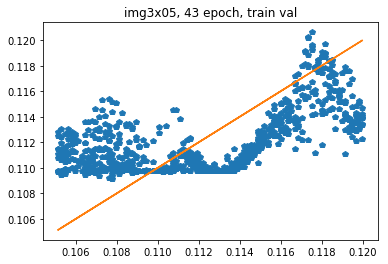

Train Epoch: 44 [0/2030 (0%)]	Loss: 0.000010	 mse: 2.222930379502941e-05
Train Epoch: 44 [100/2030 (5%)]	Loss: 0.000007	 mse: 1.6277150280075148e-05
Train Epoch: 44 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.738096761982888e-05
Train Epoch: 44 [300/2030 (15%)]	Loss: 0.000004	 mse: 1.5680669093853794e-05
Train Epoch: 44 [400/2030 (20%)]	Loss: 0.000024	 mse: 2.0882886019535363e-05
Train Epoch: 44 [500/2030 (25%)]	Loss: 0.000016	 mse: 1.3719255548494402e-05
Train Epoch: 44 [600/2030 (30%)]	Loss: 0.000009	 mse: 1.7716980437398888e-05
Train Epoch: 44 [700/2030 (34%)]	Loss: 0.000015	 mse: 2.5550487407599576e-05
Train Epoch: 44 [800/2030 (39%)]	Loss: 0.000008	 mse: 1.4592604202334769e-05
Train Epoch: 44 [900/2030 (44%)]	Loss: 0.000030	 mse: 2.2972866645432077e-05
Train Epoch: 44 [1000/2030 (49%)]	Loss: 0.000027	 mse: 1.7135049347416498e-05
Train Epoch: 44 [1100/2030 (54%)]	Loss: 0.000040	 mse: 1.330167560809059e-05
Train Epoch: 44 [1200/2030 (59%)]	Loss: 0.000183	 mse: 1.8652493963600136e-05
Tra

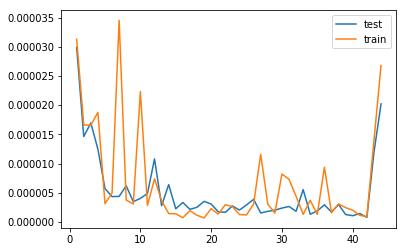

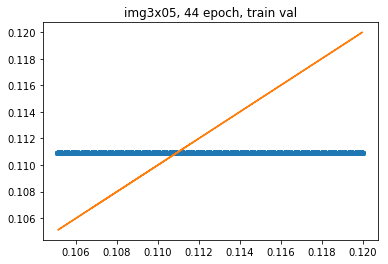

/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Train Epoch: 45 [0/2030 (0%)]	Loss: 0.000029	 mse: 3.183377702953294e-05
Train Epoch: 45 [100/2030 (5%)]	Loss: 0.000034	 mse: 2.768199919955805e-05
Train Epoch: 45 [200/2030 (10%)]	Loss: 0.000065	 mse: 1.2039254215778783e-05
Train Epoch: 45 [300/2030 (15%)]	Loss: 0.000033	 mse: 2.114276503561996e-05
Train Epoch: 45 [400/2030 (20%)]	Loss: 0.000043	 mse: 1.722723027341999e-05
Train Epoch: 45 [500/2030 (25%)]	Loss: 0.000029	 mse: 2.9489374355762266e-05
Train Epoch: 45 [600/2030 (30%)]	Loss: 0.000024	 mse: 2.211437458754517e-05
Train Epoch: 45 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.0770167136797681e-05
Train Epoch: 45 [800/2030 (39%)]	Loss: 0.000016	 mse: 6.04100796408602e-06
Train Epoch: 45 [900/2030 (44%)]	Loss: 0.000015	 mse: 1.618405440240167e-05
Train Epoch: 45 [1000/2030 (49%)]	Loss: 0.000020	 mse: 2.216774555563461e-05
Train Epoch: 45 [1100/2030 (54%)]	Loss: 0.000015	 mse: 1.2137501471443102e-05
Train Epoch: 45 [1200/2030 (59%)]	Loss: 0.000019	 mse: 1.5795892977621406e-05
Train Epo

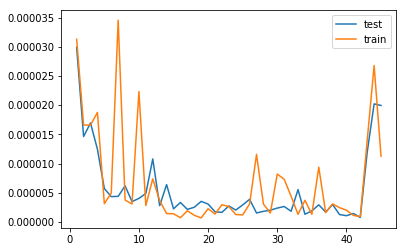

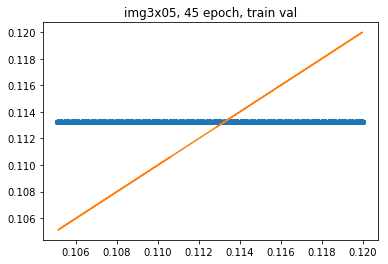

Train Epoch: 46 [0/2030 (0%)]	Loss: 0.000020	 mse: 2.2208680093172006e-05
Train Epoch: 46 [100/2030 (5%)]	Loss: 0.000019	 mse: 2.019753992499318e-05
Train Epoch: 46 [200/2030 (10%)]	Loss: 0.000026	 mse: 1.2575397704495117e-05
Train Epoch: 46 [300/2030 (15%)]	Loss: 0.000009	 mse: 9.517139915260486e-06
Train Epoch: 46 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.7720609321258962e-05
Train Epoch: 46 [500/2030 (25%)]	Loss: 0.000049	 mse: 1.061398688761983e-05
Train Epoch: 46 [600/2030 (30%)]	Loss: 0.000024	 mse: 2.3486267309635878e-05
Train Epoch: 46 [700/2030 (34%)]	Loss: 0.000026	 mse: 1.1429125152062625e-05
Train Epoch: 46 [800/2030 (39%)]	Loss: 0.000023	 mse: 1.843021163949743e-05
Train Epoch: 46 [900/2030 (44%)]	Loss: 0.000011	 mse: 9.95381924440153e-06
Train Epoch: 46 [1000/2030 (49%)]	Loss: 0.000018	 mse: 1.9426379367359914e-05
Train Epoch: 46 [1100/2030 (54%)]	Loss: 0.000017	 mse: 1.785525819286704e-05
Train Epoch: 46 [1200/2030 (59%)]	Loss: 0.000015	 mse: 1.6557647541048937e-05
Train E

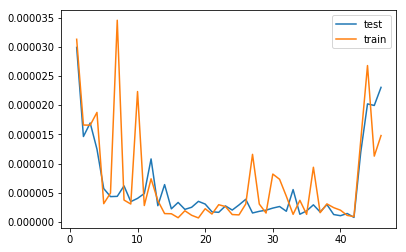

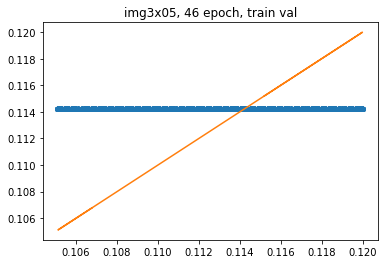

Train Epoch: 47 [0/2030 (0%)]	Loss: 0.000012	 mse: 1.3291058166942094e-05
Train Epoch: 47 [100/2030 (5%)]	Loss: 0.000029	 mse: 2.766837496892549e-05
Train Epoch: 47 [200/2030 (10%)]	Loss: 0.000012	 mse: 1.2603303730429616e-05
Train Epoch: 47 [300/2030 (15%)]	Loss: 0.000028	 mse: 1.8553939298726618e-05
Train Epoch: 47 [400/2030 (20%)]	Loss: 0.000021	 mse: 1.8864773664972745e-05
Train Epoch: 47 [500/2030 (25%)]	Loss: 0.000021	 mse: 2.1233738152659498e-05
Train Epoch: 47 [600/2030 (30%)]	Loss: 0.000044	 mse: 3.026689046237152e-05
Train Epoch: 47 [700/2030 (34%)]	Loss: 0.000023	 mse: 2.298014806001447e-05
Train Epoch: 47 [800/2030 (39%)]	Loss: 0.000013	 mse: 1.0686462701414712e-05
Train Epoch: 47 [900/2030 (44%)]	Loss: 0.000019	 mse: 1.408315438311547e-05
Train Epoch: 47 [1000/2030 (49%)]	Loss: 0.000045	 mse: 1.9554961909307167e-05
Train Epoch: 47 [1100/2030 (54%)]	Loss: 0.000037	 mse: 1.9185001292498782e-05
Train Epoch: 47 [1200/2030 (59%)]	Loss: 0.000036	 mse: 1.859547774074599e-05
Train

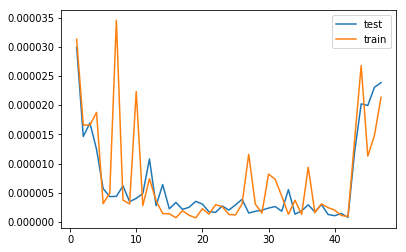

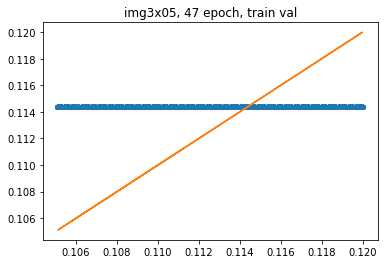

Train Epoch: 48 [0/2030 (0%)]	Loss: 0.000030	 mse: 2.1555189960054122e-05
Train Epoch: 48 [100/2030 (5%)]	Loss: 0.000012	 mse: 2.0393463273649104e-06
Train Epoch: 48 [200/2030 (10%)]	Loss: 0.000013	 mse: 1.0554244909144472e-05
Train Epoch: 48 [300/2030 (15%)]	Loss: 0.000026	 mse: 2.7669588234857656e-05
Train Epoch: 48 [400/2030 (20%)]	Loss: 0.000023	 mse: 2.128468440787401e-05
Train Epoch: 48 [500/2030 (25%)]	Loss: 0.000017	 mse: 1.7788832337828353e-05
Train Epoch: 48 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.510448691988131e-05
Train Epoch: 48 [700/2030 (34%)]	Loss: 0.000026	 mse: 2.7489142667036504e-05
Train Epoch: 48 [800/2030 (39%)]	Loss: 0.000019	 mse: 1.5441702998941764e-05
Train Epoch: 48 [900/2030 (44%)]	Loss: 0.000025	 mse: 2.6743151465780102e-05
Train Epoch: 48 [1000/2030 (49%)]	Loss: 0.000012	 mse: 3.0473413517029257e-06
Train Epoch: 48 [1100/2030 (54%)]	Loss: 0.000027	 mse: 2.159613541152794e-05
Train Epoch: 48 [1200/2030 (59%)]	Loss: 0.000052	 mse: 8.807539416011423e-06
Trai

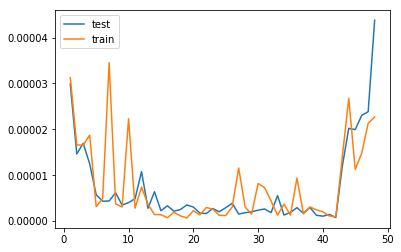

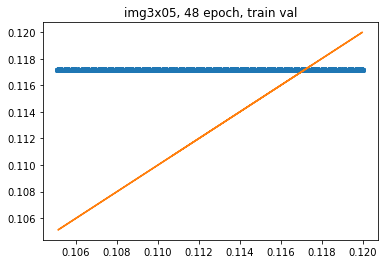

Train Epoch: 49 [0/2030 (0%)]	Loss: 0.000050	 mse: 1.607366357347928e-05
Train Epoch: 49 [100/2030 (5%)]	Loss: 0.000039	 mse: 2.316331119800452e-05
Train Epoch: 49 [200/2030 (10%)]	Loss: 0.000020	 mse: 2.0367358956718817e-05
Train Epoch: 49 [300/2030 (15%)]	Loss: 0.000009	 mse: 9.399485861649737e-06
Train Epoch: 49 [400/2030 (20%)]	Loss: 0.000007	 mse: 7.370139883278171e-06
Train Epoch: 49 [500/2030 (25%)]	Loss: 0.000033	 mse: 1.1766323041229043e-05
Train Epoch: 49 [600/2030 (30%)]	Loss: 0.000027	 mse: 2.707399835344404e-05
Train Epoch: 49 [700/2030 (34%)]	Loss: 0.000029	 mse: 1.879684532468673e-05
Train Epoch: 49 [800/2030 (39%)]	Loss: 0.000030	 mse: 2.1870557247893885e-05
Train Epoch: 49 [900/2030 (44%)]	Loss: 0.000025	 mse: 2.4634671717649326e-05
Train Epoch: 49 [1000/2030 (49%)]	Loss: 0.000009	 mse: 9.849801244854461e-06
Train Epoch: 49 [1100/2030 (54%)]	Loss: 0.000068	 mse: 1.4817916053289082e-05
Train Epoch: 49 [1200/2030 (59%)]	Loss: 0.000057	 mse: 1.4006725905346684e-05
Train E

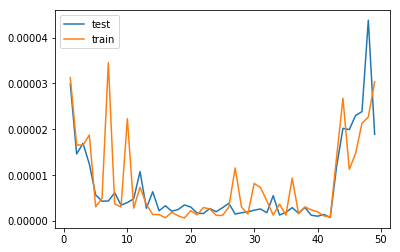

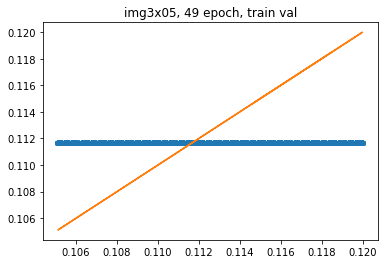

Train Epoch: 50 [0/2030 (0%)]	Loss: 0.000023	 mse: 2.544738345022779e-05
Train Epoch: 50 [100/2030 (5%)]	Loss: 0.000026	 mse: 2.8467733500292525e-05
Train Epoch: 50 [200/2030 (10%)]	Loss: 0.000021	 mse: 2.116550604114309e-05
Train Epoch: 50 [300/2030 (15%)]	Loss: 0.000020	 mse: 1.856970447988715e-05
Train Epoch: 50 [400/2030 (20%)]	Loss: 0.000011	 mse: 1.1313887625874486e-05
Train Epoch: 50 [500/2030 (25%)]	Loss: 0.000028	 mse: 1.687545773165766e-05
Train Epoch: 50 [600/2030 (30%)]	Loss: 0.000021	 mse: 2.2657488443655893e-05
Train Epoch: 50 [700/2030 (34%)]	Loss: 0.000028	 mse: 2.993181078636553e-05
Train Epoch: 50 [800/2030 (39%)]	Loss: 0.000017	 mse: 1.5441391951753758e-05
Train Epoch: 50 [900/2030 (44%)]	Loss: 0.000014	 mse: 1.584289566380903e-05
Train Epoch: 50 [1000/2030 (49%)]	Loss: 0.000013	 mse: 1.3227684576122556e-05
Train Epoch: 50 [1100/2030 (54%)]	Loss: 0.000021	 mse: 1.4108322829997633e-05
Train Epoch: 50 [1200/2030 (59%)]	Loss: 0.000033	 mse: 3.6414054193301126e-05
Train 

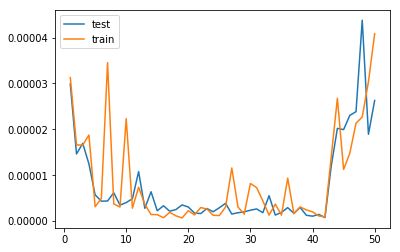

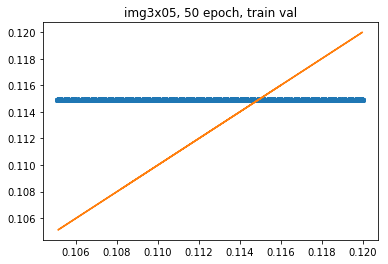

Train Epoch: 51 [0/2030 (0%)]	Loss: 0.000032	 mse: 2.370187394262757e-05
Train Epoch: 51 [100/2030 (5%)]	Loss: 0.000032	 mse: 1.745041663525626e-05
Train Epoch: 51 [200/2030 (10%)]	Loss: 0.000026	 mse: 2.9228276616777293e-05
Train Epoch: 51 [300/2030 (15%)]	Loss: 0.000019	 mse: 1.512116887170123e-05
Train Epoch: 51 [400/2030 (20%)]	Loss: 0.000012	 mse: 1.3014205251238309e-05
Train Epoch: 51 [500/2030 (25%)]	Loss: 0.000028	 mse: 2.3991786292754114e-05
Train Epoch: 51 [600/2030 (30%)]	Loss: 0.000012	 mse: 1.3350500012165867e-05
Train Epoch: 51 [700/2030 (34%)]	Loss: 0.000032	 mse: 1.1444587471487466e-05
Train Epoch: 51 [800/2030 (39%)]	Loss: 0.000019	 mse: 2.1083031242596917e-05
Train Epoch: 51 [900/2030 (44%)]	Loss: 0.000034	 mse: 2.953181137854699e-05
Train Epoch: 51 [1000/2030 (49%)]	Loss: 0.000028	 mse: 1.4271157851908356e-05
Train Epoch: 51 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.1460566131281666e-05
Train Epoch: 51 [1200/2030 (59%)]	Loss: 0.000054	 mse: 1.784312007657718e-05
Train

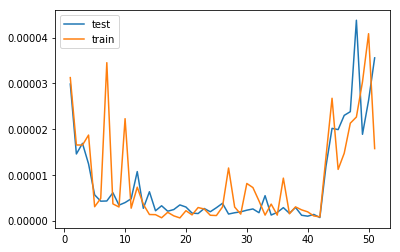

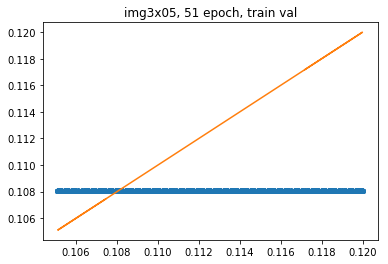

Train Epoch: 52 [0/2030 (0%)]	Loss: 0.000041	 mse: 1.8185492081101984e-05
Train Epoch: 52 [100/2030 (5%)]	Loss: 0.000016	 mse: 1.564184458402451e-05
Train Epoch: 52 [200/2030 (10%)]	Loss: 0.000024	 mse: 2.224659147032071e-05
Train Epoch: 52 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.1198647371202242e-05
Train Epoch: 52 [400/2030 (20%)]	Loss: 0.000027	 mse: 3.012497654708568e-05
Train Epoch: 52 [500/2030 (25%)]	Loss: 0.000022	 mse: 2.3407434127875604e-05
Train Epoch: 52 [600/2030 (30%)]	Loss: 0.000011	 mse: 9.332767149317078e-06
Train Epoch: 52 [700/2030 (34%)]	Loss: 0.000007	 mse: 6.586553354281932e-06
Train Epoch: 52 [800/2030 (39%)]	Loss: 0.000026	 mse: 2.8087149985367432e-05
Train Epoch: 52 [900/2030 (44%)]	Loss: 0.000015	 mse: 1.5969349988154136e-05
Train Epoch: 52 [1000/2030 (49%)]	Loss: 0.000010	 mse: 1.034349224937614e-05
Train Epoch: 52 [1100/2030 (54%)]	Loss: 0.000035	 mse: 1.9347527995705605e-05
Train Epoch: 52 [1200/2030 (59%)]	Loss: 0.000016	 mse: 1.678661283222027e-05
Train E

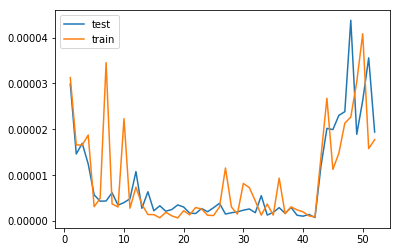

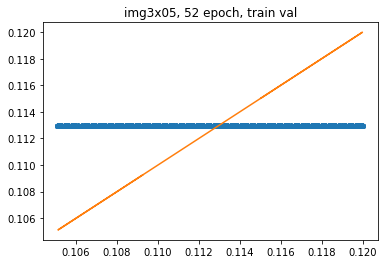

Train Epoch: 53 [0/2030 (0%)]	Loss: 0.000016	 mse: 1.1165901923959609e-05
Train Epoch: 53 [100/2030 (5%)]	Loss: 0.000016	 mse: 1.7508340533822775e-05
Train Epoch: 53 [200/2030 (10%)]	Loss: 0.000031	 mse: 2.8020433092024177e-05
Train Epoch: 53 [300/2030 (15%)]	Loss: 0.000027	 mse: 2.6852321752812713e-05
Train Epoch: 53 [400/2030 (20%)]	Loss: 0.000024	 mse: 1.7182350347866304e-05
Train Epoch: 53 [500/2030 (25%)]	Loss: 0.000043	 mse: 1.8820788682205603e-05
Train Epoch: 53 [600/2030 (30%)]	Loss: 0.000031	 mse: 2.1753814507974312e-05
Train Epoch: 53 [700/2030 (34%)]	Loss: 0.000034	 mse: 2.5959252525353804e-05
Train Epoch: 53 [800/2030 (39%)]	Loss: 0.000027	 mse: 2.714799666136969e-05
Train Epoch: 53 [900/2030 (44%)]	Loss: 0.000020	 mse: 1.9802415408776142e-05
Train Epoch: 53 [1000/2030 (49%)]	Loss: 0.000009	 mse: 8.65743731992552e-06
Train Epoch: 53 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.1342922991607338e-05
Train Epoch: 53 [1200/2030 (59%)]	Loss: 0.000014	 mse: 1.4561975149263162e-05
Tra

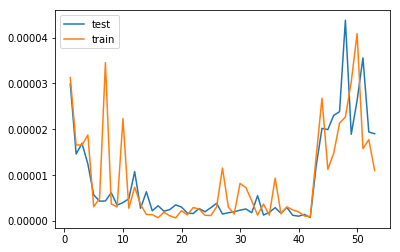

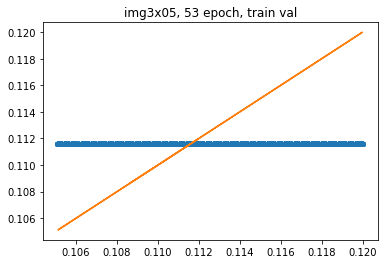

Train Epoch: 54 [0/2030 (0%)]	Loss: 0.000016	 mse: 1.7635691619943827e-05
Train Epoch: 54 [100/2030 (5%)]	Loss: 0.000017	 mse: 1.7862539607449435e-05
Train Epoch: 54 [200/2030 (10%)]	Loss: 0.000023	 mse: 2.2205340428627096e-05
Train Epoch: 54 [300/2030 (15%)]	Loss: 0.000037	 mse: 2.3406213585985824e-05
Train Epoch: 54 [400/2030 (20%)]	Loss: 0.000014	 mse: 1.457077723898692e-05
Train Epoch: 54 [500/2030 (25%)]	Loss: 0.000032	 mse: 2.6080873794853687e-05
Train Epoch: 54 [600/2030 (30%)]	Loss: 0.000017	 mse: 1.745011286402587e-05
Train Epoch: 54 [700/2030 (34%)]	Loss: 0.000022	 mse: 2.37698077398818e-05
Train Epoch: 54 [800/2030 (39%)]	Loss: 0.000030	 mse: 1.1838808859465644e-05
Train Epoch: 54 [900/2030 (44%)]	Loss: 0.000027	 mse: 1.6897291061468422e-05
Train Epoch: 54 [1000/2030 (49%)]	Loss: 0.000016	 mse: 1.7406762708560564e-05
Train Epoch: 54 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.307871363882441e-05
Train Epoch: 54 [1200/2030 (59%)]	Loss: 0.000014	 mse: 1.5820152839296497e-05
Train

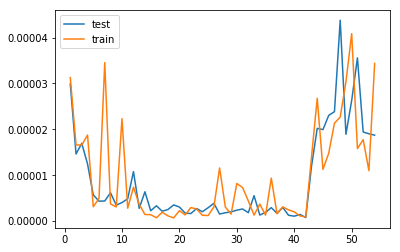

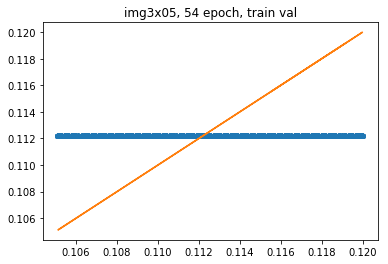

Train Epoch: 55 [0/2030 (0%)]	Loss: 0.000020	 mse: 2.0675766791100614e-05
Train Epoch: 55 [100/2030 (5%)]	Loss: 0.000029	 mse: 2.4960061637102626e-05
Train Epoch: 55 [200/2030 (10%)]	Loss: 0.000023	 mse: 2.543311165936757e-05
Train Epoch: 55 [300/2030 (15%)]	Loss: 0.000017	 mse: 1.686816722212825e-05
Train Epoch: 55 [400/2030 (20%)]	Loss: 0.000014	 mse: 1.4339087101689074e-05
Train Epoch: 55 [500/2030 (25%)]	Loss: 0.000021	 mse: 2.0439232685021125e-05
Train Epoch: 55 [600/2030 (30%)]	Loss: 0.000042	 mse: 2.1278621716191992e-05
Train Epoch: 55 [700/2030 (34%)]	Loss: 0.000054	 mse: 2.0943845811416395e-05
Train Epoch: 55 [800/2030 (39%)]	Loss: 0.000025	 mse: 2.8106269382988103e-05
Train Epoch: 55 [900/2030 (44%)]	Loss: 0.000019	 mse: 1.9542527297744527e-05
Train Epoch: 55 [1000/2030 (49%)]	Loss: 0.000020	 mse: 2.1639800252160057e-05
Train Epoch: 55 [1100/2030 (54%)]	Loss: 0.000021	 mse: 1.8807744709192775e-05
Train Epoch: 55 [1200/2030 (59%)]	Loss: 0.000014	 mse: 1.553965557832271e-05
Tra

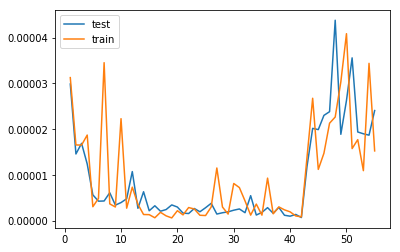

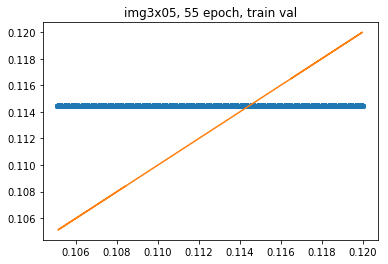

Train Epoch: 56 [0/2030 (0%)]	Loss: 0.000025	 mse: 1.5189402802207042e-05
Train Epoch: 56 [100/2030 (5%)]	Loss: 0.000020	 mse: 9.607204447092954e-06
Train Epoch: 56 [200/2030 (10%)]	Loss: 0.000021	 mse: 2.271966150146909e-05
Train Epoch: 56 [300/2030 (15%)]	Loss: 0.000022	 mse: 1.4322118659038097e-05
Train Epoch: 56 [400/2030 (20%)]	Loss: 0.000014	 mse: 1.2316722859395668e-05
Train Epoch: 56 [500/2030 (25%)]	Loss: 0.000029	 mse: 2.629039045132231e-05
Train Epoch: 56 [600/2030 (30%)]	Loss: 0.000018	 mse: 1.18403249871335e-05
Train Epoch: 56 [700/2030 (34%)]	Loss: 0.000023	 mse: 1.8486316548660398e-05
Train Epoch: 56 [800/2030 (39%)]	Loss: 0.000028	 mse: 2.5169903892674483e-05
Train Epoch: 56 [900/2030 (44%)]	Loss: 0.000018	 mse: 4.6166483116394375e-06
Train Epoch: 56 [1000/2030 (49%)]	Loss: 0.000014	 mse: 1.4017345165484585e-05
Train Epoch: 56 [1100/2030 (54%)]	Loss: 0.000013	 mse: 1.3685291378351394e-05
Train Epoch: 56 [1200/2030 (59%)]	Loss: 0.000019	 mse: 1.913525557029061e-05
Train 

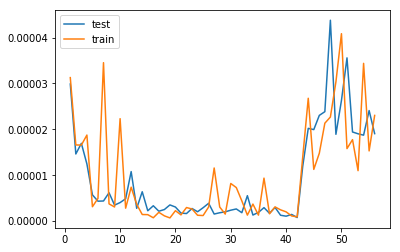

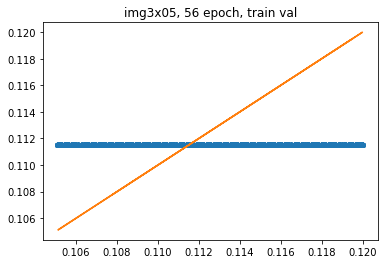

Train Epoch: 57 [0/2030 (0%)]	Loss: 0.000017	 mse: 1.7672087778919376e-05
Train Epoch: 57 [100/2030 (5%)]	Loss: 0.000020	 mse: 2.1277401174302213e-05
Train Epoch: 57 [200/2030 (10%)]	Loss: 0.000029	 mse: 2.8932621717103757e-05
Train Epoch: 57 [300/2030 (15%)]	Loss: 0.000032	 mse: 1.993067235162016e-05
Train Epoch: 57 [400/2030 (20%)]	Loss: 0.000007	 mse: 6.453424248320516e-06
Train Epoch: 57 [500/2030 (25%)]	Loss: 0.000016	 mse: 1.4012783140060492e-05
Train Epoch: 57 [600/2030 (30%)]	Loss: 0.000030	 mse: 2.0366451281006448e-05
Train Epoch: 57 [700/2030 (34%)]	Loss: 0.000022	 mse: 2.27363379963208e-05
Train Epoch: 57 [800/2030 (39%)]	Loss: 0.000049	 mse: 2.487515303073451e-05
Train Epoch: 57 [900/2030 (44%)]	Loss: 0.000027	 mse: 2.0681534806499258e-05
Train Epoch: 57 [1000/2030 (49%)]	Loss: 0.000016	 mse: 1.721964690659661e-05
Train Epoch: 57 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.1432375433505513e-05
Train Epoch: 57 [1200/2030 (59%)]	Loss: 0.000025	 mse: 2.7524325560079888e-05
Train 

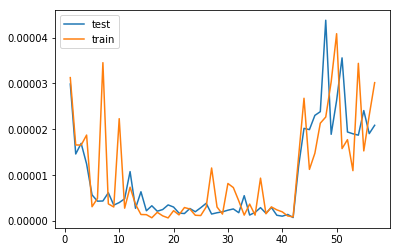

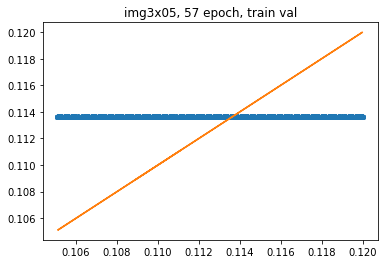

Train Epoch: 58 [0/2030 (0%)]	Loss: 0.000020	 mse: 1.4817923329246696e-05
Train Epoch: 58 [100/2030 (5%)]	Loss: 0.000020	 mse: 1.9324181266711093e-05
Train Epoch: 58 [200/2030 (10%)]	Loss: 0.000017	 mse: 1.5672163499402814e-05
Train Epoch: 58 [300/2030 (15%)]	Loss: 0.000018	 mse: 1.8800177713274024e-05
Train Epoch: 58 [400/2030 (20%)]	Loss: 0.000020	 mse: 2.2170175725477748e-05
Train Epoch: 58 [500/2030 (25%)]	Loss: 0.000028	 mse: 2.234452767879702e-05
Train Epoch: 58 [600/2030 (30%)]	Loss: 0.000059	 mse: 2.5356395781273022e-05
Train Epoch: 58 [700/2030 (34%)]	Loss: 0.000031	 mse: 1.4895857020746917e-05
Train Epoch: 58 [800/2030 (39%)]	Loss: 0.000017	 mse: 1.5359220924437977e-05
Train Epoch: 58 [900/2030 (44%)]	Loss: 0.000012	 mse: 8.190425432985649e-06
Train Epoch: 58 [1000/2030 (49%)]	Loss: 0.000018	 mse: 1.653430808801204e-05
Train Epoch: 58 [1100/2030 (54%)]	Loss: 0.000028	 mse: 3.0865809094393626e-05
Train Epoch: 58 [1200/2030 (59%)]	Loss: 0.000034	 mse: 2.4141292669810355e-05
Tra

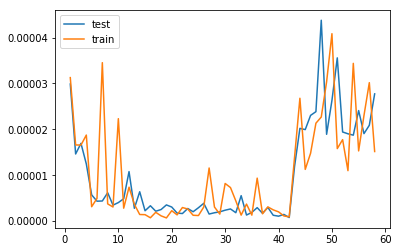

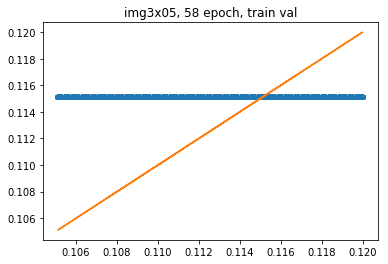

Train Epoch: 59 [0/2030 (0%)]	Loss: 0.000014	 mse: 1.0090892828884535e-05
Train Epoch: 59 [100/2030 (5%)]	Loss: 0.000019	 mse: 1.769877962942701e-05
Train Epoch: 59 [200/2030 (10%)]	Loss: 0.000015	 mse: 1.664256524236407e-05
Train Epoch: 59 [300/2030 (15%)]	Loss: 0.000024	 mse: 2.652845432749018e-05
Train Epoch: 59 [400/2030 (20%)]	Loss: 0.000025	 mse: 1.5959649317665026e-05
Train Epoch: 59 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.5733732652734034e-05
Train Epoch: 59 [600/2030 (30%)]	Loss: 0.000009	 mse: 7.294938768609427e-06
Train Epoch: 59 [700/2030 (34%)]	Loss: 0.000026	 mse: 9.698184840090107e-06
Train Epoch: 59 [800/2030 (39%)]	Loss: 0.000015	 mse: 1.4714818462380208e-05
Train Epoch: 59 [900/2030 (44%)]	Loss: 0.000020	 mse: 1.1590456779231317e-05
Train Epoch: 59 [1000/2030 (49%)]	Loss: 0.000020	 mse: 1.99707064894028e-05
Train Epoch: 59 [1100/2030 (54%)]	Loss: 0.000013	 mse: 1.371894177282229e-05
Train Epoch: 59 [1200/2030 (59%)]	Loss: 0.000032	 mse: 1.4557116628566291e-05
Train Ep

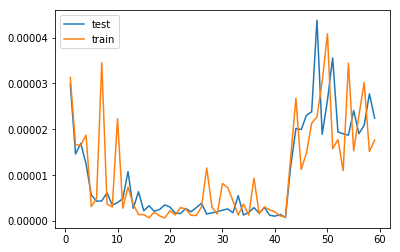

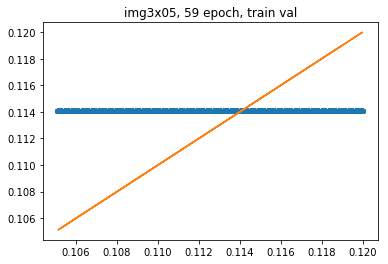

Train Epoch: 60 [0/2030 (0%)]	Loss: 0.000014	 mse: 1.3788392607239075e-05
Train Epoch: 60 [100/2030 (5%)]	Loss: 0.000025	 mse: 2.6966041332343593e-05
Train Epoch: 60 [200/2030 (10%)]	Loss: 0.000022	 mse: 2.2323916709865443e-05
Train Epoch: 60 [300/2030 (15%)]	Loss: 0.000020	 mse: 1.3151566236047074e-05
Train Epoch: 60 [400/2030 (20%)]	Loss: 0.000022	 mse: 2.0428013158380054e-05
Train Epoch: 60 [500/2030 (25%)]	Loss: 0.000019	 mse: 1.5193027138593607e-05
Train Epoch: 60 [600/2030 (30%)]	Loss: 0.000021	 mse: 1.585047721164301e-05
Train Epoch: 60 [700/2030 (34%)]	Loss: 0.000020	 mse: 1.5146950318012387e-05
Train Epoch: 60 [800/2030 (39%)]	Loss: 0.000031	 mse: 2.0641793526010588e-05
Train Epoch: 60 [900/2030 (44%)]	Loss: 0.000012	 mse: 1.1996806279057637e-05
Train Epoch: 60 [1000/2030 (49%)]	Loss: 0.000035	 mse: 3.5757821024162695e-05
Train Epoch: 60 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.2891896151122637e-05
Train Epoch: 60 [1200/2030 (59%)]	Loss: 0.000021	 mse: 2.129439053533133e-05
Tr

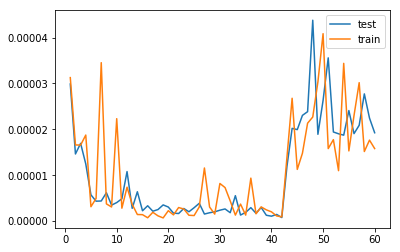

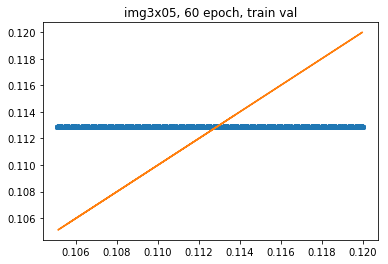

Train Epoch: 61 [0/2030 (0%)]	Loss: 0.000013	 mse: 1.4223563994164579e-05
Train Epoch: 61 [100/2030 (5%)]	Loss: 0.000011	 mse: 1.1755108062061481e-05
Train Epoch: 61 [200/2030 (10%)]	Loss: 0.000008	 mse: 8.302937203552574e-06
Train Epoch: 61 [300/2030 (15%)]	Loss: 0.000022	 mse: 1.6313540982082486e-05
Train Epoch: 61 [400/2030 (20%)]	Loss: 0.000032	 mse: 1.9887322196154855e-05
Train Epoch: 61 [500/2030 (25%)]	Loss: 0.000027	 mse: 2.9130322218406945e-05
Train Epoch: 61 [600/2030 (30%)]	Loss: 0.000026	 mse: 1.566459468449466e-05
Train Epoch: 61 [700/2030 (34%)]	Loss: 0.000029	 mse: 2.7078853236162104e-05
Train Epoch: 61 [800/2030 (39%)]	Loss: 0.000038	 mse: 2.9143357096472755e-05
Train Epoch: 61 [900/2030 (44%)]	Loss: 0.000021	 mse: 2.3823480660212226e-05
Train Epoch: 61 [1000/2030 (49%)]	Loss: 0.000027	 mse: 2.9886921765864827e-05
Train Epoch: 61 [1100/2030 (54%)]	Loss: 0.000039	 mse: 1.5162712770688813e-05
Train Epoch: 61 [1200/2030 (59%)]	Loss: 0.000019	 mse: 1.9901881387340836e-05
Tr

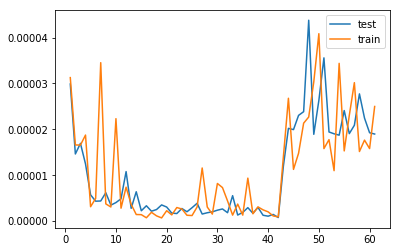

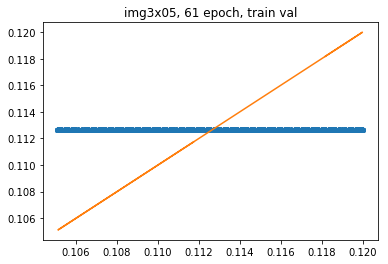

Train Epoch: 62 [0/2030 (0%)]	Loss: 0.000014	 mse: 1.6012707419577055e-05
Train Epoch: 62 [100/2030 (5%)]	Loss: 0.000020	 mse: 2.152334309357684e-05
Train Epoch: 62 [200/2030 (10%)]	Loss: 0.000036	 mse: 2.208980731666088e-05
Train Epoch: 62 [300/2030 (15%)]	Loss: 0.000031	 mse: 1.4733321222593077e-05
Train Epoch: 62 [400/2030 (20%)]	Loss: 0.000029	 mse: 2.429170490358956e-05
Train Epoch: 62 [500/2030 (25%)]	Loss: 0.000021	 mse: 1.4618093700846657e-05
Train Epoch: 62 [600/2030 (30%)]	Loss: 0.000026	 mse: 1.7189635400427505e-05
Train Epoch: 62 [700/2030 (34%)]	Loss: 0.000038	 mse: 3.364114309079014e-05
Train Epoch: 62 [800/2030 (39%)]	Loss: 0.000025	 mse: 2.5116236429312266e-05
Train Epoch: 62 [900/2030 (44%)]	Loss: 0.000021	 mse: 2.0550824046949856e-05
Train Epoch: 62 [1000/2030 (49%)]	Loss: 0.000022	 mse: 1.844506368797738e-05
Train Epoch: 62 [1100/2030 (54%)]	Loss: 0.000017	 mse: 1.5679444913985208e-05
Train Epoch: 62 [1200/2030 (59%)]	Loss: 0.000036	 mse: 2.384622348472476e-05
Train 

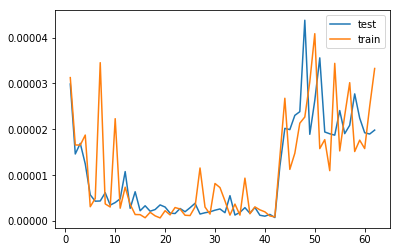

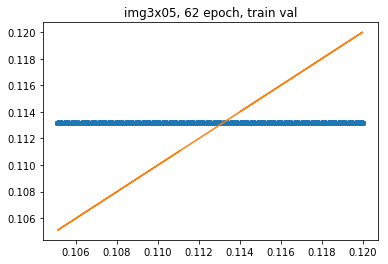

Train Epoch: 63 [0/2030 (0%)]	Loss: 0.000020	 mse: 1.8314987755729817e-05
Train Epoch: 63 [100/2030 (5%)]	Loss: 0.000028	 mse: 2.0874391339020804e-05
Train Epoch: 63 [200/2030 (10%)]	Loss: 0.000011	 mse: 1.2015006177534815e-05
Train Epoch: 63 [300/2030 (15%)]	Loss: 0.000034	 mse: 3.2543368433834985e-05
Train Epoch: 63 [400/2030 (20%)]	Loss: 0.000019	 mse: 1.6622863768134266e-05
Train Epoch: 63 [500/2030 (25%)]	Loss: 0.000021	 mse: 2.2459758838522248e-05
Train Epoch: 63 [600/2030 (30%)]	Loss: 0.000016	 mse: 1.733851240715012e-05
Train Epoch: 63 [700/2030 (34%)]	Loss: 0.000020	 mse: 1.4301494957180694e-05
Train Epoch: 63 [800/2030 (39%)]	Loss: 0.000028	 mse: 2.8893780836369842e-05
Train Epoch: 63 [900/2030 (44%)]	Loss: 0.000017	 mse: 1.1379090210539289e-05
Train Epoch: 63 [1000/2030 (49%)]	Loss: 0.000021	 mse: 2.253286038467195e-05
Train Epoch: 63 [1100/2030 (54%)]	Loss: 0.000010	 mse: 1.1318740689603146e-05
Train Epoch: 63 [1200/2030 (59%)]	Loss: 0.000030	 mse: 2.3271271857083775e-05
Tr

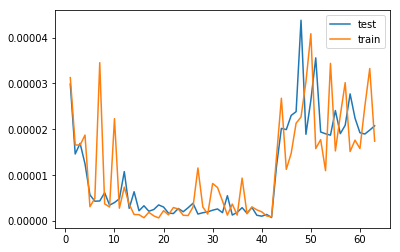

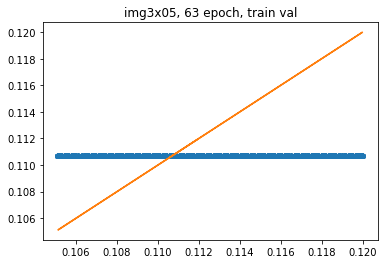

Train Epoch: 64 [0/2030 (0%)]	Loss: 0.000025	 mse: 2.004138514166698e-05
Train Epoch: 64 [100/2030 (5%)]	Loss: 0.000016	 mse: 1.4260255738918204e-05
Train Epoch: 64 [200/2030 (10%)]	Loss: 0.000016	 mse: 1.6387522919103503e-05
Train Epoch: 64 [300/2030 (15%)]	Loss: 0.000023	 mse: 2.5079853003262542e-05
Train Epoch: 64 [400/2030 (20%)]	Loss: 0.000026	 mse: 2.8313985239947215e-05
Train Epoch: 64 [500/2030 (25%)]	Loss: 0.000017	 mse: 1.876166061265394e-05
Train Epoch: 64 [600/2030 (30%)]	Loss: 0.000020	 mse: 2.2050997358746827e-05
Train Epoch: 64 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.3173407751310151e-05
Train Epoch: 64 [800/2030 (39%)]	Loss: 0.000012	 mse: 1.3253465112939011e-05
Train Epoch: 64 [900/2030 (44%)]	Loss: 0.000017	 mse: 1.4134087905404158e-05
Train Epoch: 64 [1000/2030 (49%)]	Loss: 0.000014	 mse: 1.4872503925289493e-05
Train Epoch: 64 [1100/2030 (54%)]	Loss: 0.000031	 mse: 2.3483540644519962e-05
Train Epoch: 64 [1200/2030 (59%)]	Loss: 0.000011	 mse: 1.2128721209592186e-05
Tr

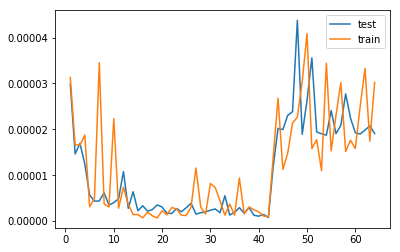

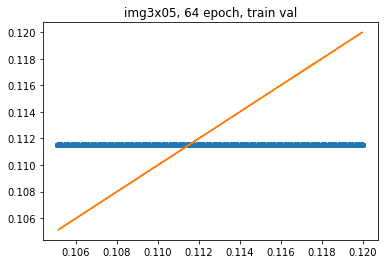

Train Epoch: 65 [0/2030 (0%)]	Loss: 0.000014	 mse: 1.2993879863643087e-05
Train Epoch: 65 [100/2030 (5%)]	Loss: 0.000014	 mse: 1.5429268387379125e-05
Train Epoch: 65 [200/2030 (10%)]	Loss: 0.000024	 mse: 2.5759427444427274e-05
Train Epoch: 65 [300/2030 (15%)]	Loss: 0.000022	 mse: 2.375069925619755e-05
Train Epoch: 65 [400/2030 (20%)]	Loss: 0.000030	 mse: 3.10553441522643e-05
Train Epoch: 65 [500/2030 (25%)]	Loss: 0.000032	 mse: 2.4199194740504026e-05
Train Epoch: 65 [600/2030 (30%)]	Loss: 0.000017	 mse: 1.3610989299195353e-05
Train Epoch: 65 [700/2030 (34%)]	Loss: 0.000021	 mse: 2.2621103198616765e-05
Train Epoch: 65 [800/2030 (39%)]	Loss: 0.000043	 mse: 2.0634219254134223e-05
Train Epoch: 65 [900/2030 (44%)]	Loss: 0.000019	 mse: 1.9759640053962357e-05
Train Epoch: 65 [1000/2030 (49%)]	Loss: 0.000028	 mse: 3.0297234843601473e-05
Train Epoch: 65 [1100/2030 (54%)]	Loss: 0.000026	 mse: 2.5342136723338626e-05
Train Epoch: 65 [1200/2030 (59%)]	Loss: 0.000016	 mse: 1.7242997273569927e-05
Tra

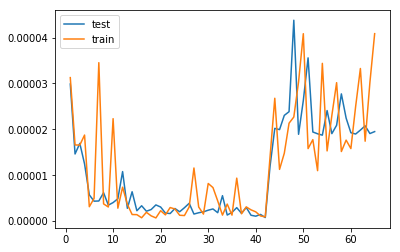

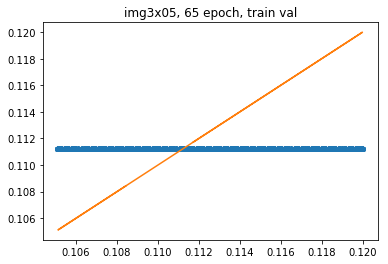

Train Epoch: 66 [0/2030 (0%)]	Loss: 0.000018	 mse: 1.623014031792991e-05
Train Epoch: 66 [100/2030 (5%)]	Loss: 0.000023	 mse: 2.573515121184755e-05
Train Epoch: 66 [200/2030 (10%)]	Loss: 0.000025	 mse: 2.5854940759018064e-05
Train Epoch: 66 [300/2030 (15%)]	Loss: 0.000021	 mse: 2.243552080472e-05
Train Epoch: 66 [400/2030 (20%)]	Loss: 0.000016	 mse: 1.74212982528843e-05
Train Epoch: 66 [500/2030 (25%)]	Loss: 0.000023	 mse: 1.9280530977994204e-05
Train Epoch: 66 [600/2030 (30%)]	Loss: 0.000018	 mse: 1.9542840163921937e-05
Train Epoch: 66 [700/2030 (34%)]	Loss: 0.000020	 mse: 2.1439947886392474e-05
Train Epoch: 66 [800/2030 (39%)]	Loss: 0.000034	 mse: 1.4563481272489298e-05
Train Epoch: 66 [900/2030 (44%)]	Loss: 0.000027	 mse: 1.0807766557263676e-05
Train Epoch: 66 [1000/2030 (49%)]	Loss: 0.000020	 mse: 8.498222086927854e-06
Train Epoch: 66 [1100/2030 (54%)]	Loss: 0.000019	 mse: 2.1483312593773007e-05
Train Epoch: 66 [1200/2030 (59%)]	Loss: 0.000027	 mse: 2.9597324100905098e-05
Train Epo

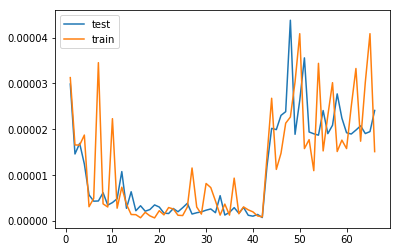

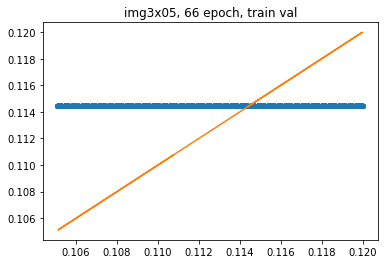

Train Epoch: 67 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.6790543668321334e-05
Train Epoch: 67 [100/2030 (5%)]	Loss: 0.000017	 mse: 1.4954995094740298e-05
Train Epoch: 67 [200/2030 (10%)]	Loss: 0.000007	 mse: 5.802953182865167e-06
Train Epoch: 67 [300/2030 (15%)]	Loss: 0.000015	 mse: 1.6165846318472177e-05
Train Epoch: 67 [400/2030 (20%)]	Loss: 0.000011	 mse: 1.2378589417494368e-05
Train Epoch: 67 [500/2030 (25%)]	Loss: 0.000013	 mse: 1.3039677469350863e-05
Train Epoch: 67 [600/2030 (30%)]	Loss: 0.000020	 mse: 2.099721496051643e-05
Train Epoch: 67 [700/2030 (34%)]	Loss: 0.000020	 mse: 1.7200542060891166e-05
Train Epoch: 67 [800/2030 (39%)]	Loss: 0.000022	 mse: 2.4345075871679e-05
Train Epoch: 67 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.0646646589739248e-05
Train Epoch: 67 [1000/2030 (49%)]	Loss: 0.000027	 mse: 2.9583690775325522e-05
Train Epoch: 67 [1100/2030 (54%)]	Loss: 0.000010	 mse: 1.0525447578402236e-05
Train Epoch: 67 [1200/2030 (59%)]	Loss: 0.000013	 mse: 1.1605008694459684e-05
Train

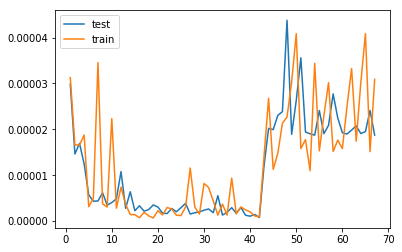

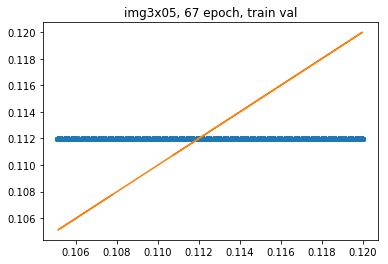

Train Epoch: 68 [0/2030 (0%)]	Loss: 0.000025	 mse: 2.3733706257189624e-05
Train Epoch: 68 [100/2030 (5%)]	Loss: 0.000014	 mse: 1.4974695659475401e-05
Train Epoch: 68 [200/2030 (10%)]	Loss: 0.000027	 mse: 2.9331373298191465e-05
Train Epoch: 68 [300/2030 (15%)]	Loss: 0.000028	 mse: 2.6953000997309573e-05
Train Epoch: 68 [400/2030 (20%)]	Loss: 0.000022	 mse: 2.4679855414433405e-05
Train Epoch: 68 [500/2030 (25%)]	Loss: 0.000034	 mse: 3.705814015120268e-05
Train Epoch: 68 [600/2030 (30%)]	Loss: 0.000012	 mse: 1.3511526958609466e-05
Train Epoch: 68 [700/2030 (34%)]	Loss: 0.000033	 mse: 3.220769212930463e-05
Train Epoch: 68 [800/2030 (39%)]	Loss: 0.000037	 mse: 1.242224607267417e-05
Train Epoch: 68 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.104209124809131e-05
Train Epoch: 68 [1000/2030 (49%)]	Loss: 0.000024	 mse: 1.8869312043534592e-05
Train Epoch: 68 [1100/2030 (54%)]	Loss: 0.000045	 mse: 2.2581072698812932e-05
Train Epoch: 68 [1200/2030 (59%)]	Loss: 0.000023	 mse: 2.5643887056503445e-05
Trai

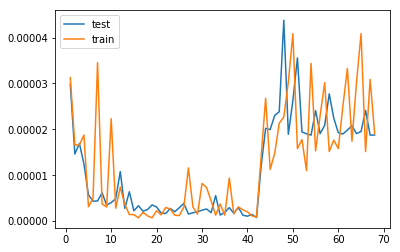

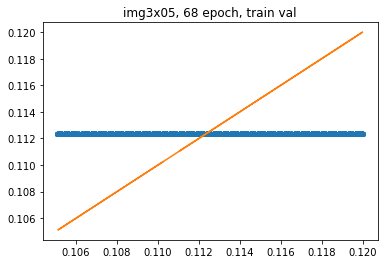

Train Epoch: 69 [0/2030 (0%)]	Loss: 0.000017	 mse: 1.802537008188665e-05
Train Epoch: 69 [100/2030 (5%)]	Loss: 0.000033	 mse: 2.827608295774553e-05
Train Epoch: 69 [200/2030 (10%)]	Loss: 0.000025	 mse: 1.6734747987356968e-05
Train Epoch: 69 [300/2030 (15%)]	Loss: 0.000022	 mse: 1.5842902939766645e-05
Train Epoch: 69 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.205948840128258e-05
Train Epoch: 69 [500/2030 (25%)]	Loss: 0.000009	 mse: 7.72191197029315e-06
Train Epoch: 69 [600/2030 (30%)]	Loss: 0.000024	 mse: 1.8158800230594352e-05
Train Epoch: 69 [700/2030 (34%)]	Loss: 0.000014	 mse: 1.4269643543229904e-05
Train Epoch: 69 [800/2030 (39%)]	Loss: 0.000017	 mse: 1.8242193618789315e-05
Train Epoch: 69 [900/2030 (44%)]	Loss: 0.000022	 mse: 2.42359110416146e-05
Train Epoch: 69 [1000/2030 (49%)]	Loss: 0.000016	 mse: 1.3295923963596579e-05
Train Epoch: 69 [1100/2030 (54%)]	Loss: 0.000030	 mse: 1.8922695744549856e-05
Train Epoch: 69 [1200/2030 (59%)]	Loss: 0.000005	 mse: 5.762933596997755e-06
Train Ep

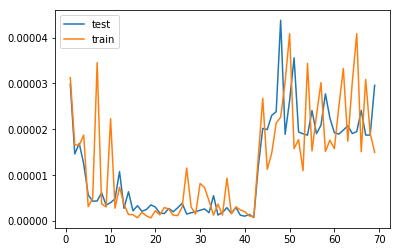

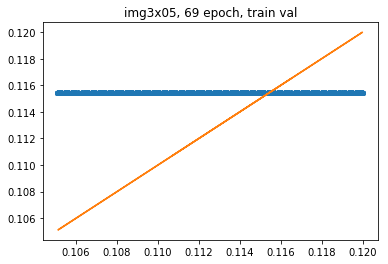

Train Epoch: 70 [0/2030 (0%)]	Loss: 0.000031	 mse: 1.7530477634863928e-05
Train Epoch: 70 [100/2030 (5%)]	Loss: 0.000018	 mse: 2.0446512280614115e-05
Train Epoch: 70 [200/2030 (10%)]	Loss: 0.000040	 mse: 2.0405268514878117e-05
Train Epoch: 70 [300/2030 (15%)]	Loss: 0.000019	 mse: 2.059207508864347e-05
Train Epoch: 70 [400/2030 (20%)]	Loss: 0.000027	 mse: 2.8989315978833474e-05
Train Epoch: 70 [500/2030 (25%)]	Loss: 0.000017	 mse: 1.643120231165085e-05
Train Epoch: 70 [600/2030 (30%)]	Loss: 0.000027	 mse: 2.2695388906868175e-05
Train Epoch: 70 [700/2030 (34%)]	Loss: 0.000024	 mse: 2.640200182213448e-05
Train Epoch: 70 [800/2030 (39%)]	Loss: 0.000029	 mse: 2.8022868718835525e-05
Train Epoch: 70 [900/2030 (44%)]	Loss: 0.000004	 mse: 4.172693024884211e-06
Train Epoch: 70 [1000/2030 (49%)]	Loss: 0.000012	 mse: 1.2664861060329713e-05
Train Epoch: 70 [1100/2030 (54%)]	Loss: 0.000010	 mse: 1.0601866051729303e-05
Train Epoch: 70 [1200/2030 (59%)]	Loss: 0.000014	 mse: 1.370559857605258e-05
Train

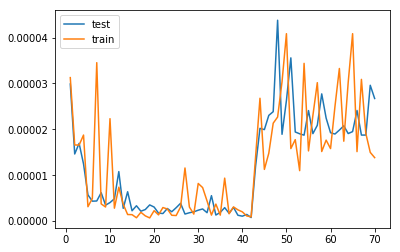

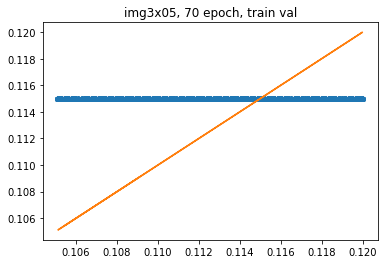

Train Epoch: 71 [0/2030 (0%)]	Loss: 0.000019	 mse: 1.3846611182088964e-05
Train Epoch: 71 [100/2030 (5%)]	Loss: 0.000025	 mse: 1.891206920845434e-05
Train Epoch: 71 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.5848052498768084e-05
Train Epoch: 71 [300/2030 (15%)]	Loss: 0.000015	 mse: 1.6812085959827527e-05
Train Epoch: 71 [400/2030 (20%)]	Loss: 0.000023	 mse: 2.4256505639641546e-05
Train Epoch: 71 [500/2030 (25%)]	Loss: 0.000028	 mse: 2.518293695175089e-05
Train Epoch: 71 [600/2030 (30%)]	Loss: 0.000025	 mse: 2.2635656932834536e-05
Train Epoch: 71 [700/2030 (34%)]	Loss: 0.000016	 mse: 1.6469108231831342e-05
Train Epoch: 71 [800/2030 (39%)]	Loss: 0.000020	 mse: 2.054930337180849e-05
Train Epoch: 71 [900/2030 (44%)]	Loss: 0.000032	 mse: 1.9891866031684913e-05
Train Epoch: 71 [1000/2030 (49%)]	Loss: 0.000023	 mse: 2.003287590923719e-05
Train Epoch: 71 [1100/2030 (54%)]	Loss: 0.000013	 mse: 7.84230087447213e-06
Train Epoch: 71 [1200/2030 (59%)]	Loss: 0.000017	 mse: 1.6261383279925212e-05
Train 

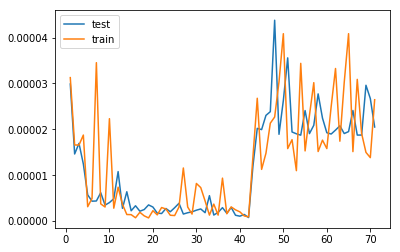

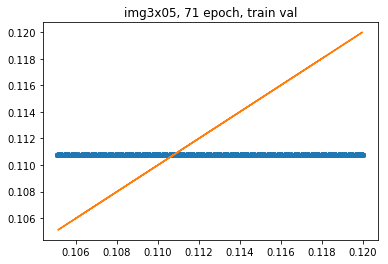

Train Epoch: 72 [0/2030 (0%)]	Loss: 0.000030	 mse: 2.345807479287032e-05
Train Epoch: 72 [100/2030 (5%)]	Loss: 0.000021	 mse: 2.1339274098863825e-05
Train Epoch: 72 [200/2030 (10%)]	Loss: 0.000015	 mse: 1.5304618500522338e-05
Train Epoch: 72 [300/2030 (15%)]	Loss: 0.000023	 mse: 2.470744584570639e-05
Train Epoch: 72 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.4725734217790887e-05
Train Epoch: 72 [500/2030 (25%)]	Loss: 0.000022	 mse: 2.24491668632254e-05
Train Epoch: 72 [600/2030 (30%)]	Loss: 0.000017	 mse: 1.884991070255637e-05
Train Epoch: 72 [700/2030 (34%)]	Loss: 0.000019	 mse: 1.9479462935123593e-05
Train Epoch: 72 [800/2030 (39%)]	Loss: 0.000036	 mse: 3.071932587772608e-05
Train Epoch: 72 [900/2030 (44%)]	Loss: 0.000023	 mse: 1.4313622159534134e-05
Train Epoch: 72 [1000/2030 (49%)]	Loss: 0.000016	 mse: 1.7829779608291574e-05
Train Epoch: 72 [1100/2030 (54%)]	Loss: 0.000013	 mse: 1.233280090673361e-05
Train Epoch: 72 [1200/2030 (59%)]	Loss: 0.000015	 mse: 1.6581614545430057e-05
Train E

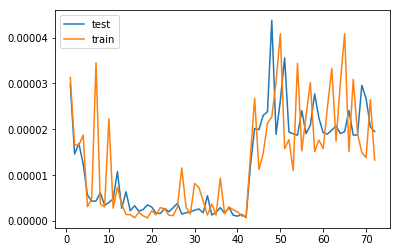

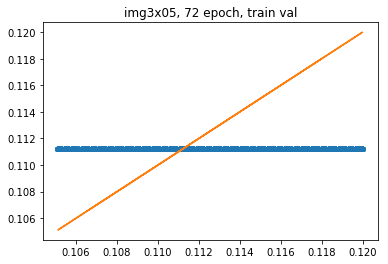

Train Epoch: 73 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.3356263480091002e-05
Train Epoch: 73 [100/2030 (5%)]	Loss: 0.000019	 mse: 4.0541290218243375e-06
Train Epoch: 73 [200/2030 (10%)]	Loss: 0.000011	 mse: 8.827256351651158e-06
Train Epoch: 73 [300/2030 (15%)]	Loss: 0.000015	 mse: 1.640451591811143e-05
Train Epoch: 73 [400/2030 (20%)]	Loss: 0.000021	 mse: 1.941425580298528e-05
Train Epoch: 73 [500/2030 (25%)]	Loss: 0.000016	 mse: 1.7690286767901853e-05
Train Epoch: 73 [600/2030 (30%)]	Loss: 0.000031	 mse: 2.4495169782312587e-05
Train Epoch: 73 [700/2030 (34%)]	Loss: 0.000019	 mse: 2.0239991499693133e-05
Train Epoch: 73 [800/2030 (39%)]	Loss: 0.000013	 mse: 1.1269919014011975e-05
Train Epoch: 73 [900/2030 (44%)]	Loss: 0.000009	 mse: 9.472261808696203e-06
Train Epoch: 73 [1000/2030 (49%)]	Loss: 0.000021	 mse: 2.1826584998052567e-05
Train Epoch: 73 [1100/2030 (54%)]	Loss: 0.000014	 mse: 1.187550151371397e-05
Train Epoch: 73 [1200/2030 (59%)]	Loss: 0.000014	 mse: 1.5242469999066088e-05
Train

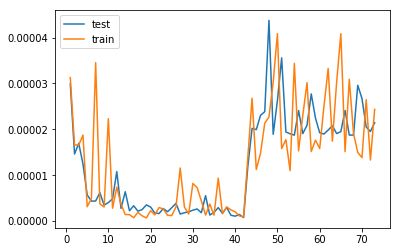

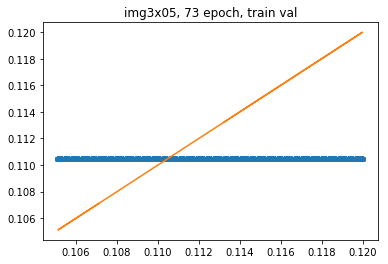

Train Epoch: 74 [0/2030 (0%)]	Loss: 0.000032	 mse: 3.1895950087346137e-05
Train Epoch: 74 [100/2030 (5%)]	Loss: 0.000021	 mse: 2.0041368770762347e-05
Train Epoch: 74 [200/2030 (10%)]	Loss: 0.000029	 mse: 1.4683575500384904e-05
Train Epoch: 74 [300/2030 (15%)]	Loss: 0.000030	 mse: 1.3024202417000197e-05
Train Epoch: 74 [400/2030 (20%)]	Loss: 0.000025	 mse: 1.5036577678984031e-05
Train Epoch: 74 [500/2030 (25%)]	Loss: 0.000034	 mse: 2.5042243578354828e-05
Train Epoch: 74 [600/2030 (30%)]	Loss: 0.000013	 mse: 1.4333032595459372e-05
Train Epoch: 74 [700/2030 (34%)]	Loss: 0.000025	 mse: 2.7977694116998464e-05
Train Epoch: 74 [800/2030 (39%)]	Loss: 0.000016	 mse: 1.5624855222995393e-05
Train Epoch: 74 [900/2030 (44%)]	Loss: 0.000016	 mse: 1.715051257633604e-05
Train Epoch: 74 [1000/2030 (49%)]	Loss: 0.000019	 mse: 1.714109930617269e-05
Train Epoch: 74 [1100/2030 (54%)]	Loss: 0.000035	 mse: 1.879047522379551e-05
Train Epoch: 74 [1200/2030 (59%)]	Loss: 0.000020	 mse: 2.1809906684211455e-05
Tra

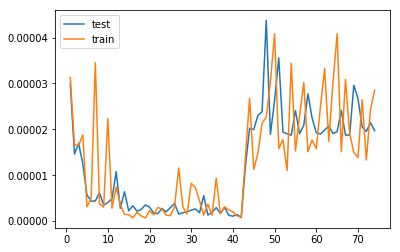

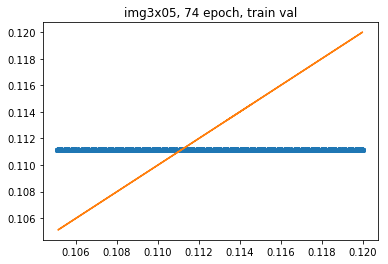

Train Epoch: 75 [0/2030 (0%)]	Loss: 0.000026	 mse: 2.1495443434105255e-05
Train Epoch: 75 [100/2030 (5%)]	Loss: 0.000020	 mse: 1.9734179659280926e-05
Train Epoch: 75 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.3149136975698639e-05
Train Epoch: 75 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.0936651051451918e-05
Train Epoch: 75 [400/2030 (20%)]	Loss: 0.000040	 mse: 9.686046723800246e-06
Train Epoch: 75 [500/2030 (25%)]	Loss: 0.000022	 mse: 2.4016051611397415e-05
Train Epoch: 75 [600/2030 (30%)]	Loss: 0.000020	 mse: 2.196851528424304e-05
Train Epoch: 75 [700/2030 (34%)]	Loss: 0.000028	 mse: 2.180626688641496e-05
Train Epoch: 75 [800/2030 (39%)]	Loss: 0.000035	 mse: 2.742849574133288e-05
Train Epoch: 75 [900/2030 (44%)]	Loss: 0.000015	 mse: 1.4247806575440336e-05
Train Epoch: 75 [1000/2030 (49%)]	Loss: 0.000014	 mse: 1.3130945262673777e-05
Train Epoch: 75 [1100/2030 (54%)]	Loss: 0.000022	 mse: 2.2234160496736877e-05
Train Epoch: 75 [1200/2030 (59%)]	Loss: 0.000013	 mse: 1.3151573512004688e-05
Trai

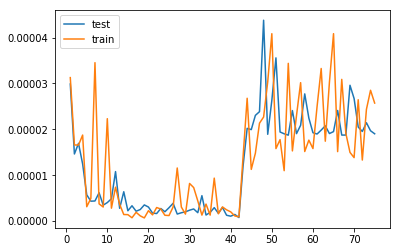

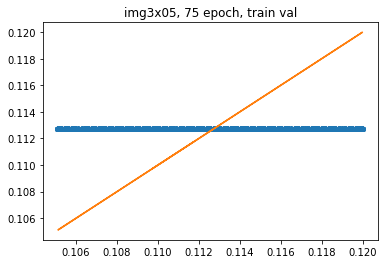

Train Epoch: 76 [0/2030 (0%)]	Loss: 0.000016	 mse: 1.814304050640203e-05
Train Epoch: 76 [100/2030 (5%)]	Loss: 0.000028	 mse: 1.6932166545302607e-05
Train Epoch: 76 [200/2030 (10%)]	Loss: 0.000019	 mse: 1.999164669541642e-05
Train Epoch: 76 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.1578319572436158e-05
Train Epoch: 76 [400/2030 (20%)]	Loss: 0.000024	 mse: 2.6377740141469985e-05
Train Epoch: 76 [500/2030 (25%)]	Loss: 0.000022	 mse: 2.1295301849022508e-05
Train Epoch: 76 [600/2030 (30%)]	Loss: 0.000024	 mse: 1.7083799320971593e-05
Train Epoch: 76 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.861458076746203e-05
Train Epoch: 76 [800/2030 (39%)]	Loss: 0.000026	 mse: 2.1571870092884637e-05
Train Epoch: 76 [900/2030 (44%)]	Loss: 0.000014	 mse: 1.4810639186180197e-05
Train Epoch: 76 [1000/2030 (49%)]	Loss: 0.000016	 mse: 1.728544884826988e-05
Train Epoch: 76 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.1960007870802656e-05
Train Epoch: 76 [1200/2030 (59%)]	Loss: 0.000015	 mse: 1.6857255104696378e-05
Trai

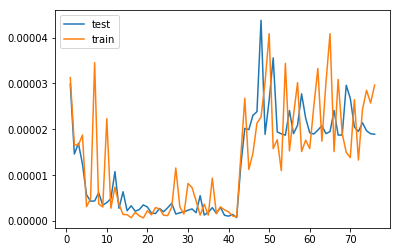

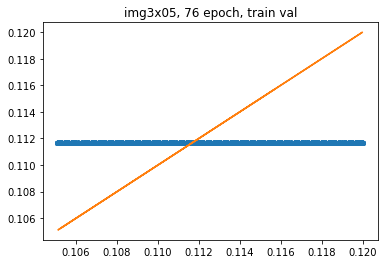

Train Epoch: 77 [0/2030 (0%)]	Loss: 0.000019	 mse: 1.961288580787368e-05
Train Epoch: 77 [100/2030 (5%)]	Loss: 0.000016	 mse: 1.5157844245550223e-05
Train Epoch: 77 [200/2030 (10%)]	Loss: 0.000017	 mse: 1.7510763427708298e-05
Train Epoch: 77 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.2288825928408187e-05
Train Epoch: 77 [400/2030 (20%)]	Loss: 0.000031	 mse: 3.326298246975057e-05
Train Epoch: 77 [500/2030 (25%)]	Loss: 0.000013	 mse: 1.4848252249066718e-05
Train Epoch: 77 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.629049438633956e-05
Train Epoch: 77 [700/2030 (34%)]	Loss: 0.000014	 mse: 1.5383478967123665e-05
Train Epoch: 77 [800/2030 (39%)]	Loss: 0.000016	 mse: 1.653309300309047e-05
Train Epoch: 77 [900/2030 (44%)]	Loss: 0.000017	 mse: 1.3217064406489953e-05
Train Epoch: 77 [1000/2030 (49%)]	Loss: 0.000017	 mse: 1.486067321820883e-05
Train Epoch: 77 [1100/2030 (54%)]	Loss: 0.000014	 mse: 1.550235174363479e-05
Train Epoch: 77 [1200/2030 (59%)]	Loss: 0.000052	 mse: 2.2384567273547873e-05
Train 

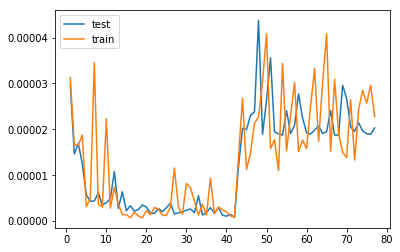

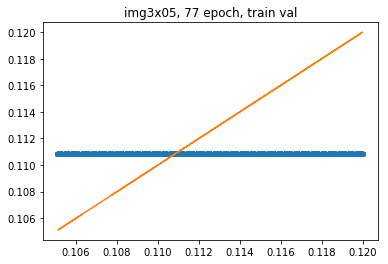

Train Epoch: 78 [0/2030 (0%)]	Loss: 0.000009	 mse: 9.444355782761704e-06
Train Epoch: 78 [100/2030 (5%)]	Loss: 0.000014	 mse: 1.0862645467568655e-05
Train Epoch: 78 [200/2030 (10%)]	Loss: 0.000021	 mse: 1.721843727864325e-05
Train Epoch: 78 [300/2030 (15%)]	Loss: 0.000023	 mse: 2.0874387701041996e-05
Train Epoch: 78 [400/2030 (20%)]	Loss: 0.000023	 mse: 2.5061648557311855e-05
Train Epoch: 78 [500/2030 (25%)]	Loss: 0.000017	 mse: 1.6267749742837623e-05
Train Epoch: 78 [600/2030 (30%)]	Loss: 0.000024	 mse: 2.071307972073555e-05
Train Epoch: 78 [700/2030 (34%)]	Loss: 0.000024	 mse: 1.9204398995498195e-05
Train Epoch: 78 [800/2030 (39%)]	Loss: 0.000016	 mse: 1.592538865224924e-05
Train Epoch: 78 [900/2030 (44%)]	Loss: 0.000041	 mse: 1.8418082618154585e-05
Train Epoch: 78 [1000/2030 (49%)]	Loss: 0.000047	 mse: 3.282630132162012e-05
Train Epoch: 78 [1100/2030 (54%)]	Loss: 0.000022	 mse: 2.4194654542952776e-05
Train Epoch: 78 [1200/2030 (59%)]	Loss: 0.000023	 mse: 2.5431623726035468e-05
Train

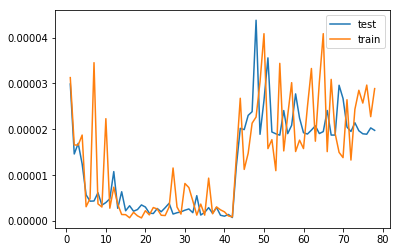

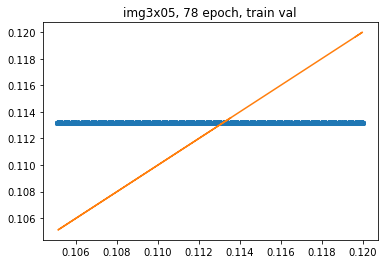

Train Epoch: 79 [0/2030 (0%)]	Loss: 0.000012	 mse: 1.3018139725318179e-05
Train Epoch: 79 [100/2030 (5%)]	Loss: 0.000021	 mse: 1.7260888853343204e-05
Train Epoch: 79 [200/2030 (10%)]	Loss: 0.000013	 mse: 1.3463000868796371e-05
Train Epoch: 79 [300/2030 (15%)]	Loss: 0.000026	 mse: 2.1515152184292674e-05
Train Epoch: 79 [400/2030 (20%)]	Loss: 0.000019	 mse: 1.307727325183805e-05
Train Epoch: 79 [500/2030 (25%)]	Loss: 0.000012	 mse: 1.2907456039101817e-05
Train Epoch: 79 [600/2030 (30%)]	Loss: 0.000021	 mse: 2.306626811332535e-05
Train Epoch: 79 [700/2030 (34%)]	Loss: 0.000021	 mse: 2.3389238776871935e-05
Train Epoch: 79 [800/2030 (39%)]	Loss: 0.000024	 mse: 2.0997207684558816e-05
Train Epoch: 79 [900/2030 (44%)]	Loss: 0.000026	 mse: 1.9606810383265838e-05
Train Epoch: 79 [1000/2030 (49%)]	Loss: 0.000013	 mse: 1.3685293197340798e-05
Train Epoch: 79 [1100/2030 (54%)]	Loss: 0.000019	 mse: 1.6498222976224497e-05
Train Epoch: 79 [1200/2030 (59%)]	Loss: 0.000024	 mse: 2.3773449356667697e-05
Tr

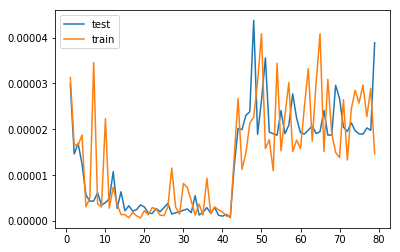

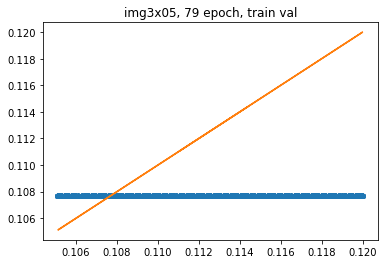

Train Epoch: 80 [0/2030 (0%)]	Loss: 0.000054	 mse: 2.298015169799328e-05
Train Epoch: 80 [100/2030 (5%)]	Loss: 0.000018	 mse: 1.9524637536960654e-05
Train Epoch: 80 [200/2030 (10%)]	Loss: 0.000018	 mse: 1.687999611021951e-05
Train Epoch: 80 [300/2030 (15%)]	Loss: 0.000019	 mse: 2.0658475477830507e-05
Train Epoch: 80 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.1119816917926073e-05
Train Epoch: 80 [500/2030 (25%)]	Loss: 0.000016	 mse: 1.3726526958635077e-05
Train Epoch: 80 [600/2030 (30%)]	Loss: 0.000016	 mse: 1.6808751752250828e-05
Train Epoch: 80 [700/2030 (34%)]	Loss: 0.000025	 mse: 2.7367857910576276e-05
Train Epoch: 80 [800/2030 (39%)]	Loss: 0.000042	 mse: 3.076180655625649e-05
Train Epoch: 80 [900/2030 (44%)]	Loss: 0.000010	 mse: 9.96745984593872e-06
Train Epoch: 80 [1000/2030 (49%)]	Loss: 0.000017	 mse: 1.81233262992464e-05
Train Epoch: 80 [1100/2030 (54%)]	Loss: 0.000014	 mse: 1.4682065739179961e-05
Train Epoch: 80 [1200/2030 (59%)]	Loss: 0.000020	 mse: 1.6814812624943443e-05
Train E

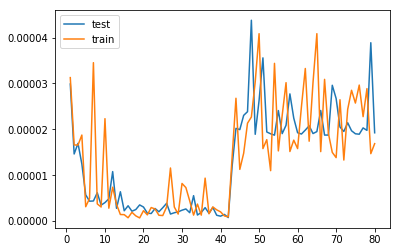

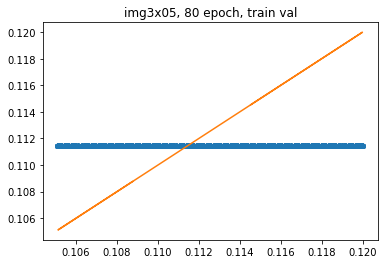

Train Epoch: 81 [0/2030 (0%)]	Loss: 0.000018	 mse: 1.9863970010192133e-05
Train Epoch: 81 [100/2030 (5%)]	Loss: 0.000020	 mse: 2.2319361960398965e-05
Train Epoch: 81 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.2231816981511656e-05
Train Epoch: 81 [300/2030 (15%)]	Loss: 0.000014	 mse: 1.5696432456024922e-05
Train Epoch: 81 [400/2030 (20%)]	Loss: 0.000009	 mse: 9.347324521513656e-06
Train Epoch: 81 [500/2030 (25%)]	Loss: 0.000019	 mse: 1.8304061086382717e-05
Train Epoch: 81 [600/2030 (30%)]	Loss: 0.000033	 mse: 1.9480967239360325e-05
Train Epoch: 81 [700/2030 (34%)]	Loss: 0.000016	 mse: 1.3567631867772434e-05
Train Epoch: 81 [800/2030 (39%)]	Loss: 0.000028	 mse: 2.6690680897445418e-05
Train Epoch: 81 [900/2030 (44%)]	Loss: 0.000022	 mse: 2.0874391339020804e-05
Train Epoch: 81 [1000/2030 (49%)]	Loss: 0.000025	 mse: 2.1641009880113415e-05
Train Epoch: 81 [1100/2030 (54%)]	Loss: 0.000015	 mse: 1.3262856555229519e-05
Train Epoch: 81 [1200/2030 (59%)]	Loss: 0.000022	 mse: 1.7292422853643075e-05
T

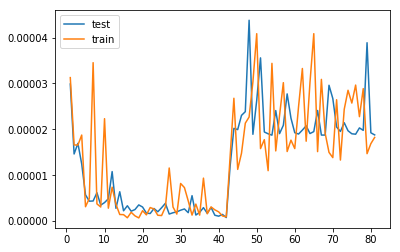

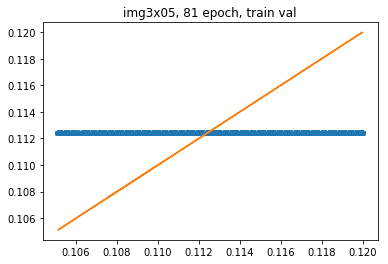

Train Epoch: 82 [0/2030 (0%)]	Loss: 0.000022	 mse: 2.358694291615393e-05
Train Epoch: 82 [100/2030 (5%)]	Loss: 0.000041	 mse: 1.9857898223563097e-05
Train Epoch: 82 [200/2030 (10%)]	Loss: 0.000019	 mse: 2.0540830519166775e-05
Train Epoch: 82 [300/2030 (15%)]	Loss: 0.000016	 mse: 1.7566873793839477e-05
Train Epoch: 82 [400/2030 (20%)]	Loss: 0.000021	 mse: 1.8541801182436757e-05
Train Epoch: 82 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.5959652955643833e-05
Train Epoch: 82 [600/2030 (30%)]	Loss: 0.000033	 mse: 2.2739073756383732e-05
Train Epoch: 82 [700/2030 (34%)]	Loss: 0.000035	 mse: 2.04704610951012e-05
Train Epoch: 82 [800/2030 (39%)]	Loss: 0.000021	 mse: 2.2938003894523717e-05
Train Epoch: 82 [900/2030 (44%)]	Loss: 0.000013	 mse: 1.1869144145748578e-05
Train Epoch: 82 [1000/2030 (49%)]	Loss: 0.000013	 mse: 1.4271176041802391e-05
Train Epoch: 82 [1100/2030 (54%)]	Loss: 0.000009	 mse: 7.344975529122166e-06
Train Epoch: 82 [1200/2030 (59%)]	Loss: 0.000017	 mse: 1.1717806046362966e-05
Trai

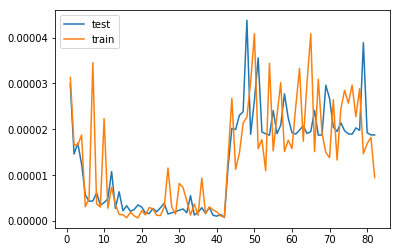

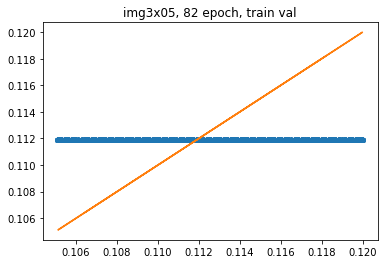

Train Epoch: 83 [0/2030 (0%)]	Loss: 0.000023	 mse: 2.5293626094935462e-05
Train Epoch: 83 [100/2030 (5%)]	Loss: 0.000023	 mse: 2.1869045667699538e-05
Train Epoch: 83 [200/2030 (10%)]	Loss: 0.000009	 mse: 7.434431608999148e-06
Train Epoch: 83 [300/2030 (15%)]	Loss: 0.000024	 mse: 2.6972116756951436e-05
Train Epoch: 83 [400/2030 (20%)]	Loss: 0.000019	 mse: 1.9477325622574426e-05
Train Epoch: 83 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.5911124137346633e-05
Train Epoch: 83 [600/2030 (30%)]	Loss: 0.000023	 mse: 2.4270777430501767e-05
Train Epoch: 83 [700/2030 (34%)]	Loss: 0.000024	 mse: 1.9119492208119482e-05
Train Epoch: 83 [800/2030 (39%)]	Loss: 0.000024	 mse: 2.240275716758333e-05
Train Epoch: 83 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.1301675587892532e-05
Train Epoch: 83 [1000/2030 (49%)]	Loss: 0.000013	 mse: 9.332764420832973e-06
Train Epoch: 83 [1100/2030 (54%)]	Loss: 0.000017	 mse: 1.8728596842265688e-05
Train Epoch: 83 [1200/2030 (59%)]	Loss: 0.000015	 mse: 1.6551281078136526e-05
Tra

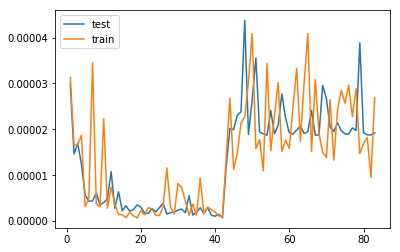

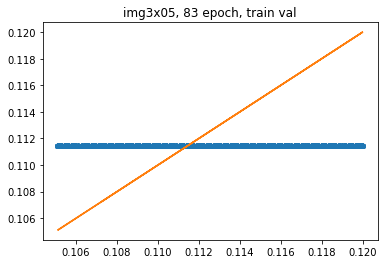

Train Epoch: 84 [0/2030 (0%)]	Loss: 0.000025	 mse: 2.182446223741863e-05
Train Epoch: 84 [100/2030 (5%)]	Loss: 0.000019	 mse: 1.632961539144162e-05
Train Epoch: 84 [200/2030 (10%)]	Loss: 0.000015	 mse: 1.7035261407727376e-05
Train Epoch: 84 [300/2030 (15%)]	Loss: 0.000011	 mse: 1.1180462934134994e-05
Train Epoch: 84 [400/2030 (20%)]	Loss: 0.000023	 mse: 2.043407039309386e-05
Train Epoch: 84 [500/2030 (25%)]	Loss: 0.000026	 mse: 2.4793589545879513e-05
Train Epoch: 84 [600/2030 (30%)]	Loss: 0.000027	 mse: 2.925010812759865e-05
Train Epoch: 84 [700/2030 (34%)]	Loss: 0.000025	 mse: 2.1347444999264553e-05
Train Epoch: 84 [800/2030 (39%)]	Loss: 0.000023	 mse: 2.5084993467316963e-05
Train Epoch: 84 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.1308946088538505e-05
Train Epoch: 84 [1000/2030 (49%)]	Loss: 0.000013	 mse: 1.402369889547117e-05
Train Epoch: 84 [1100/2030 (54%)]	Loss: 0.000028	 mse: 3.05519497487694e-05
Train Epoch: 84 [1200/2030 (59%)]	Loss: 0.000013	 mse: 9.733054866956081e-06
Train Ep

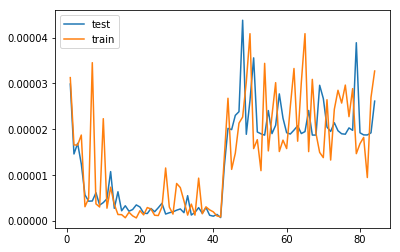

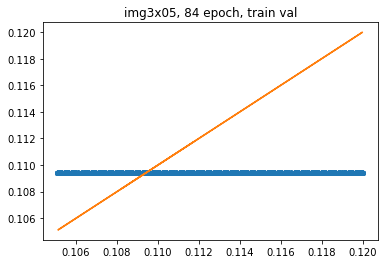

Train Epoch: 85 [0/2030 (0%)]	Loss: 0.000035	 mse: 1.853575486165937e-05
Train Epoch: 85 [100/2030 (5%)]	Loss: 0.000014	 mse: 1.2851963219873141e-05
Train Epoch: 85 [200/2030 (10%)]	Loss: 0.000019	 mse: 2.0639365175156854e-05
Train Epoch: 85 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.3175831554690376e-05
Train Epoch: 85 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.205950477218721e-05
Train Epoch: 85 [500/2030 (25%)]	Loss: 0.000016	 mse: 1.4344855117087718e-05
Train Epoch: 85 [600/2030 (30%)]	Loss: 0.000020	 mse: 2.1677400582120754e-05
Train Epoch: 85 [700/2030 (34%)]	Loss: 0.000018	 mse: 1.911797335196752e-05
Train Epoch: 85 [800/2030 (39%)]	Loss: 0.000022	 mse: 2.2972870283410884e-05
Train Epoch: 85 [900/2030 (44%)]	Loss: 0.000015	 mse: 1.625531876925379e-05
Train Epoch: 85 [1000/2030 (49%)]	Loss: 0.000026	 mse: 2.3040802261675708e-05
Train Epoch: 85 [1100/2030 (54%)]	Loss: 0.000019	 mse: 1.9671409972943366e-05
Train Epoch: 85 [1200/2030 (59%)]	Loss: 0.000017	 mse: 1.2981752661289647e-05
Trai

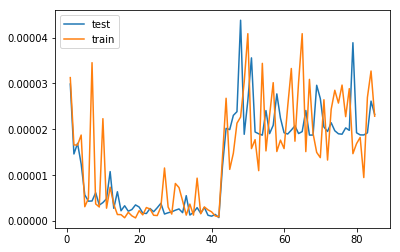

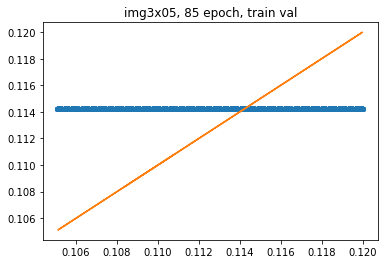

Train Epoch: 86 [0/2030 (0%)]	Loss: 0.000025	 mse: 1.0281329196004663e-05
Train Epoch: 86 [100/2030 (5%)]	Loss: 0.000038	 mse: 2.296348066010978e-05
Train Epoch: 86 [200/2030 (10%)]	Loss: 0.000011	 mse: 1.0092099728353787e-05
Train Epoch: 86 [300/2030 (15%)]	Loss: 0.000025	 mse: 2.639958074723836e-05
Train Epoch: 86 [400/2030 (20%)]	Loss: 0.000019	 mse: 2.1325926354620606e-05
Train Epoch: 86 [500/2030 (25%)]	Loss: 0.000013	 mse: 1.0642803317750804e-05
Train Epoch: 86 [600/2030 (30%)]	Loss: 0.000032	 mse: 1.3847833542968147e-05
Train Epoch: 86 [700/2030 (34%)]	Loss: 0.000054	 mse: 1.8367445591138676e-05
Train Epoch: 86 [800/2030 (39%)]	Loss: 0.000028	 mse: 1.6436359146609902e-05
Train Epoch: 86 [900/2030 (44%)]	Loss: 0.000028	 mse: 2.998790478159208e-05
Train Epoch: 86 [1000/2030 (49%)]	Loss: 0.000017	 mse: 1.705589056655299e-05
Train Epoch: 86 [1100/2030 (54%)]	Loss: 0.000019	 mse: 2.0948371457052417e-05
Train Epoch: 86 [1200/2030 (59%)]	Loss: 0.000019	 mse: 1.2581461305671837e-05
Trai

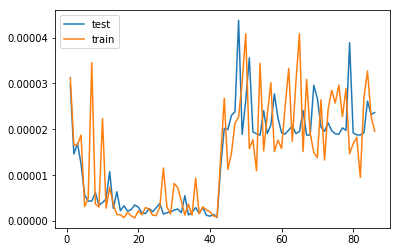

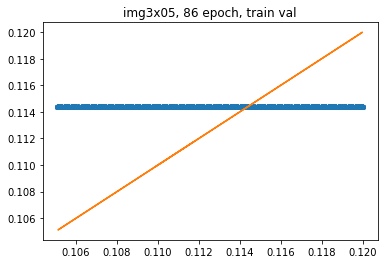

Train Epoch: 87 [0/2030 (0%)]	Loss: 0.000018	 mse: 1.5146937585086562e-05
Train Epoch: 87 [100/2030 (5%)]	Loss: 0.000028	 mse: 2.0469555238378234e-05
Train Epoch: 87 [200/2030 (10%)]	Loss: 0.000019	 mse: 2.0902600226690993e-05
Train Epoch: 87 [300/2030 (15%)]	Loss: 0.000025	 mse: 2.0095960280741565e-05
Train Epoch: 87 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.2354241082211956e-05
Train Epoch: 87 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.6281099306070246e-05
Train Epoch: 87 [600/2030 (30%)]	Loss: 0.000027	 mse: 2.698181924642995e-05
Train Epoch: 87 [700/2030 (34%)]	Loss: 0.000010	 mse: 1.0414752978249453e-05
Train Epoch: 87 [800/2030 (39%)]	Loss: 0.000017	 mse: 9.615689123165794e-06
Train Epoch: 87 [900/2030 (44%)]	Loss: 0.000023	 mse: 2.4986435164464638e-05
Train Epoch: 87 [1000/2030 (49%)]	Loss: 0.000043	 mse: 4.288235686544795e-06
Train Epoch: 87 [1100/2030 (54%)]	Loss: 0.000036	 mse: 2.003864210564643e-05
Train Epoch: 87 [1200/2030 (59%)]	Loss: 0.000019	 mse: 1.8613684005686082e-05
Trai

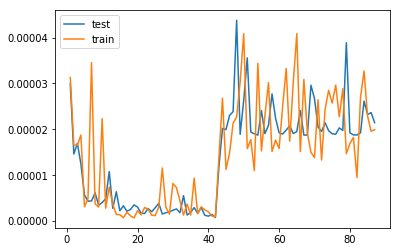

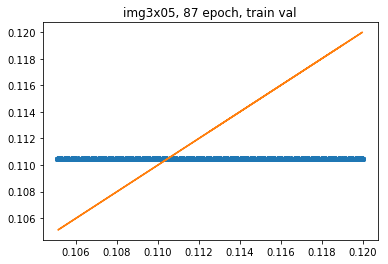

Train Epoch: 88 [0/2030 (0%)]	Loss: 0.000022	 mse: 2.22572052734904e-05
Train Epoch: 88 [100/2030 (5%)]	Loss: 0.000015	 mse: 1.585502650414128e-05
Train Epoch: 88 [200/2030 (10%)]	Loss: 0.000013	 mse: 1.4536507478624117e-05
Train Epoch: 88 [300/2030 (15%)]	Loss: 0.000013	 mse: 1.354337018710794e-05
Train Epoch: 88 [400/2030 (20%)]	Loss: 0.000016	 mse: 1.722480374155566e-05
Train Epoch: 88 [500/2030 (25%)]	Loss: 0.000018	 mse: 1.6492154827574268e-05
Train Epoch: 88 [600/2030 (30%)]	Loss: 0.000016	 mse: 1.5411374988616444e-05
Train Epoch: 88 [700/2030 (34%)]	Loss: 0.000023	 mse: 2.0053494154126383e-05
Train Epoch: 88 [800/2030 (39%)]	Loss: 0.000028	 mse: 3.0428229365497828e-05
Train Epoch: 88 [900/2030 (44%)]	Loss: 0.000020	 mse: 1.761296152835712e-05
Train Epoch: 88 [1000/2030 (49%)]	Loss: 0.000030	 mse: 1.6073368897195905e-05
Train Epoch: 88 [1100/2030 (54%)]	Loss: 0.000015	 mse: 1.676023384789005e-05
Train Epoch: 88 [1200/2030 (59%)]	Loss: 0.000034	 mse: 1.5605448425048962e-05
Train E

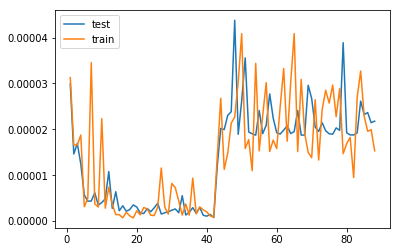

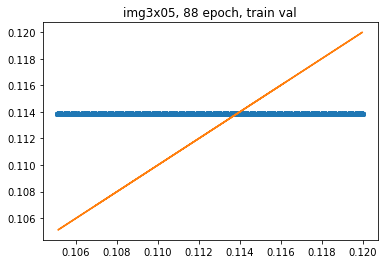

Train Epoch: 89 [0/2030 (0%)]	Loss: 0.000027	 mse: 2.7052476070821285e-05
Train Epoch: 89 [100/2030 (5%)]	Loss: 0.000027	 mse: 2.0542329366435297e-05
Train Epoch: 89 [200/2030 (10%)]	Loss: 0.000026	 mse: 1.5529036318184808e-05
Train Epoch: 89 [300/2030 (15%)]	Loss: 0.000032	 mse: 1.3940016287961043e-05
Train Epoch: 89 [400/2030 (20%)]	Loss: 0.000011	 mse: 1.2193309885333292e-05
Train Epoch: 89 [500/2030 (25%)]	Loss: 0.000026	 mse: 2.9378674298641272e-05
Train Epoch: 89 [600/2030 (30%)]	Loss: 0.000024	 mse: 2.3871694793342613e-05
Train Epoch: 89 [700/2030 (34%)]	Loss: 0.000021	 mse: 1.623014031792991e-05
Train Epoch: 89 [800/2030 (39%)]	Loss: 0.000028	 mse: 1.516240808996372e-05
Train Epoch: 89 [900/2030 (44%)]	Loss: 0.000023	 mse: 2.3794069420546293e-05
Train Epoch: 89 [1000/2030 (49%)]	Loss: 0.000040	 mse: 2.634044358273968e-05
Train Epoch: 89 [1100/2030 (54%)]	Loss: 0.000021	 mse: 1.8585784346214496e-05
Train Epoch: 89 [1200/2030 (59%)]	Loss: 0.000013	 mse: 1.4366691175382584e-05
Tra

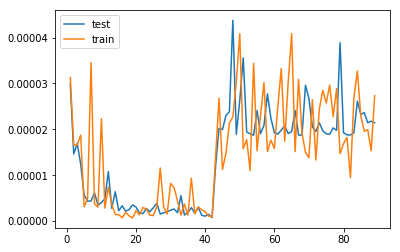

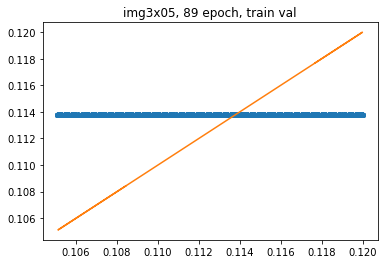

Train Epoch: 90 [0/2030 (0%)]	Loss: 0.000024	 mse: 2.5497427486698143e-05
Train Epoch: 90 [100/2030 (5%)]	Loss: 0.000019	 mse: 2.0560539269354194e-05
Train Epoch: 90 [200/2030 (10%)]	Loss: 0.000018	 mse: 2.0045912606292404e-05
Train Epoch: 90 [300/2030 (15%)]	Loss: 0.000014	 mse: 1.4738156096427701e-05
Train Epoch: 90 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.4194748473528307e-05
Train Epoch: 90 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.646911186981015e-05
Train Epoch: 90 [600/2030 (30%)]	Loss: 0.000027	 mse: 2.4260156351374462e-05
Train Epoch: 90 [700/2030 (34%)]	Loss: 0.000013	 mse: 1.4142282452667132e-05
Train Epoch: 90 [800/2030 (39%)]	Loss: 0.000032	 mse: 2.5026782168424688e-05
Train Epoch: 90 [900/2030 (44%)]	Loss: 0.000017	 mse: 1.8697071936912835e-05
Train Epoch: 90 [1000/2030 (49%)]	Loss: 0.000013	 mse: 1.2433468327799346e-05
Train Epoch: 90 [1100/2030 (54%)]	Loss: 0.000018	 mse: 1.8273731257067993e-05
Train Epoch: 90 [1200/2030 (59%)]	Loss: 0.000022	 mse: 1.7126249076682143e-05
T

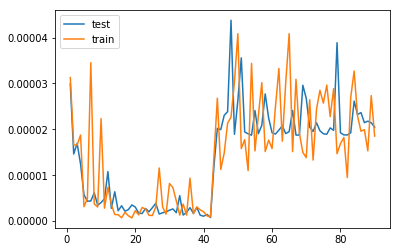

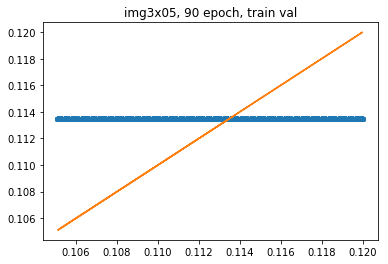

Train Epoch: 91 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.680631612543948e-05
Train Epoch: 91 [100/2030 (5%)]	Loss: 0.000021	 mse: 1.3729877537116408e-05
Train Epoch: 91 [200/2030 (10%)]	Loss: 0.000034	 mse: 2.7953723474638537e-05
Train Epoch: 91 [300/2030 (15%)]	Loss: 0.000013	 mse: 1.417260409652954e-05
Train Epoch: 91 [400/2030 (20%)]	Loss: 0.000027	 mse: 1.0868719982681796e-05
Train Epoch: 91 [500/2030 (25%)]	Loss: 0.000018	 mse: 1.4105891750659794e-05
Train Epoch: 91 [600/2030 (30%)]	Loss: 0.000026	 mse: 1.3466949894791469e-05
Train Epoch: 91 [700/2030 (34%)]	Loss: 0.000010	 mse: 1.04890577858896e-05
Train Epoch: 91 [800/2030 (39%)]	Loss: 0.000018	 mse: 1.942729068105109e-05
Train Epoch: 91 [900/2030 (44%)]	Loss: 0.000013	 mse: 1.4544995792675763e-05
Train Epoch: 91 [1000/2030 (49%)]	Loss: 0.000020	 mse: 2.1457852199091576e-05
Train Epoch: 91 [1100/2030 (54%)]	Loss: 0.000013	 mse: 1.0379882951383479e-05
Train Epoch: 91 [1200/2030 (59%)]	Loss: 0.000027	 mse: 2.1484840544871986e-05
Train

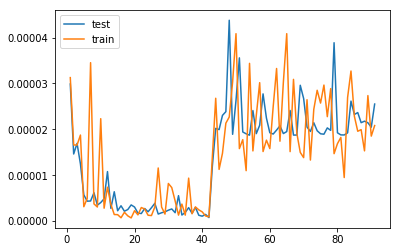

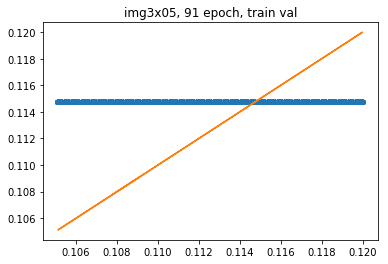

Train Epoch: 92 [0/2030 (0%)]	Loss: 0.000014	 mse: 1.538105061626993e-05
Train Epoch: 92 [100/2030 (5%)]	Loss: 0.000021	 mse: 2.0221807062625885e-05
Train Epoch: 92 [200/2030 (10%)]	Loss: 0.000023	 mse: 2.098963705066126e-05
Train Epoch: 92 [300/2030 (15%)]	Loss: 0.000021	 mse: 2.3524786229245365e-05
Train Epoch: 92 [400/2030 (20%)]	Loss: 0.000029	 mse: 1.9177708963979967e-05
Train Epoch: 92 [500/2030 (25%)]	Loss: 0.000010	 mse: 1.1014275514753535e-05
Train Epoch: 92 [600/2030 (30%)]	Loss: 0.000013	 mse: 1.1172875929332804e-05
Train Epoch: 92 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.3586727618530858e-05
Train Epoch: 92 [800/2030 (39%)]	Loss: 0.000019	 mse: 2.0093530110898428e-05
Train Epoch: 92 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.22672097152099e-05
Train Epoch: 92 [1000/2030 (49%)]	Loss: 0.000050	 mse: 1.4734529031557031e-05
Train Epoch: 92 [1100/2030 (54%)]	Loss: 0.000022	 mse: 2.1157336959731765e-05
Train Epoch: 92 [1200/2030 (59%)]	Loss: 0.000025	 mse: 2.310779927938711e-05
Train

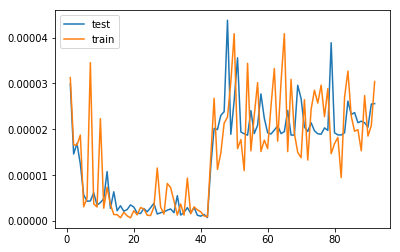

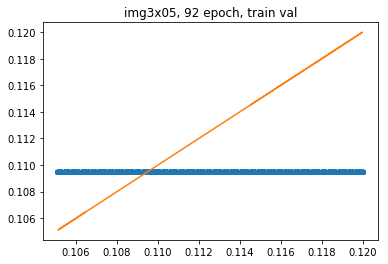

Train Epoch: 93 [0/2030 (0%)]	Loss: 0.000011	 mse: 1.0725580978032667e-05
Train Epoch: 93 [100/2030 (5%)]	Loss: 0.000012	 mse: 9.95896971289767e-06
Train Epoch: 93 [200/2030 (10%)]	Loss: 0.000017	 mse: 1.7988992112805136e-05
Train Epoch: 93 [300/2030 (15%)]	Loss: 0.000013	 mse: 1.3871785995434038e-05
Train Epoch: 93 [400/2030 (20%)]	Loss: 0.000017	 mse: 9.879827302938793e-06
Train Epoch: 93 [500/2030 (25%)]	Loss: 0.000026	 mse: 2.6753778001875617e-05
Train Epoch: 93 [600/2030 (30%)]	Loss: 0.000017	 mse: 1.5852609067223966e-05
Train Epoch: 93 [700/2030 (34%)]	Loss: 0.000009	 mse: 1.0105445653607603e-05
Train Epoch: 93 [800/2030 (39%)]	Loss: 0.000020	 mse: 2.0344623408163898e-05
Train Epoch: 93 [900/2030 (44%)]	Loss: 0.000025	 mse: 2.7401505576563068e-05
Train Epoch: 93 [1000/2030 (49%)]	Loss: 0.000014	 mse: 1.3622208825836424e-05
Train Epoch: 93 [1100/2030 (54%)]	Loss: 0.000019	 mse: 1.6994328689179383e-05
Train Epoch: 93 [1200/2030 (59%)]	Loss: 0.000022	 mse: 2.4893355657695793e-05
Tra

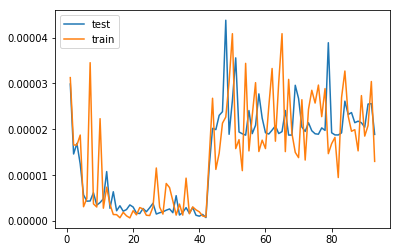

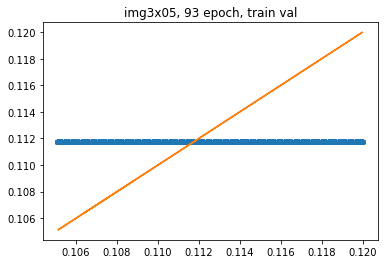

Train Epoch: 94 [0/2030 (0%)]	Loss: 0.000018	 mse: 2.0468050934141502e-05
Train Epoch: 94 [100/2030 (5%)]	Loss: 0.000014	 mse: 1.5746161807328463e-05
Train Epoch: 94 [200/2030 (10%)]	Loss: 0.000036	 mse: 3.9604517951374874e-05
Train Epoch: 94 [300/2030 (15%)]	Loss: 0.000020	 mse: 2.0281539036659524e-05
Train Epoch: 94 [400/2030 (20%)]	Loss: 0.000030	 mse: 2.3266711650649086e-05
Train Epoch: 94 [500/2030 (25%)]	Loss: 0.000031	 mse: 3.102106711594388e-05
Train Epoch: 94 [600/2030 (30%)]	Loss: 0.000023	 mse: 2.5892544726957567e-05
Train Epoch: 94 [700/2030 (34%)]	Loss: 0.000028	 mse: 2.631103780004196e-05
Train Epoch: 94 [800/2030 (39%)]	Loss: 0.000011	 mse: 1.2011355465801898e-05
Train Epoch: 94 [900/2030 (44%)]	Loss: 0.000015	 mse: 1.3811133612762205e-05
Train Epoch: 94 [1000/2030 (49%)]	Loss: 0.000016	 mse: 1.741372216201853e-05
Train Epoch: 94 [1100/2030 (54%)]	Loss: 0.000030	 mse: 2.8690001272480004e-05
Train Epoch: 94 [1200/2030 (59%)]	Loss: 0.000028	 mse: 2.5254821593989618e-05
Tra

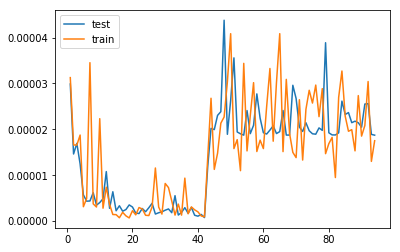

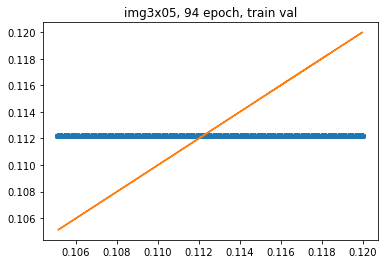

Train Epoch: 95 [0/2030 (0%)]	Loss: 0.000018	 mse: 1.3888774446968455e-05
Train Epoch: 95 [100/2030 (5%)]	Loss: 0.000023	 mse: 1.16207656901679e-05
Train Epoch: 95 [200/2030 (10%)]	Loss: 0.000013	 mse: 1.3570052033173852e-05
Train Epoch: 95 [300/2030 (15%)]	Loss: 0.000018	 mse: 7.95238338469062e-06
Train Epoch: 95 [400/2030 (20%)]	Loss: 0.000020	 mse: 2.0858935386058874e-05
Train Epoch: 95 [500/2030 (25%)]	Loss: 0.000018	 mse: 1.5823794456082396e-05
Train Epoch: 95 [600/2030 (30%)]	Loss: 0.000018	 mse: 2.0132345525780693e-05
Train Epoch: 95 [700/2030 (34%)]	Loss: 0.000022	 mse: 1.8365921278018504e-05
Train Epoch: 95 [800/2030 (39%)]	Loss: 0.000024	 mse: 7.422302132908953e-06
Train Epoch: 95 [900/2030 (44%)]	Loss: 0.000024	 mse: 2.6063882614835165e-05
Train Epoch: 95 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.525945117464289e-05
Train Epoch: 95 [1100/2030 (54%)]	Loss: 0.000016	 mse: 1.7414013200323097e-05
Train Epoch: 95 [1200/2030 (59%)]	Loss: 0.000036	 mse: 3.020472104253713e-05
Train E

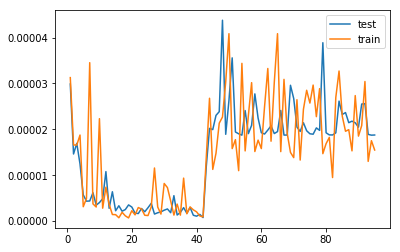

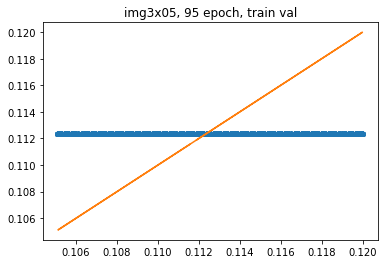

Train Epoch: 96 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.627866004128009e-05
Train Epoch: 96 [100/2030 (5%)]	Loss: 0.000048	 mse: 2.3242158931680024e-05
Train Epoch: 96 [200/2030 (10%)]	Loss: 0.000018	 mse: 1.54887111420976e-05
Train Epoch: 96 [300/2030 (15%)]	Loss: 0.000021	 mse: 1.9396979041630402e-05
Train Epoch: 96 [400/2030 (20%)]	Loss: 0.000026	 mse: 2.8335505703580566e-05
Train Epoch: 96 [500/2030 (25%)]	Loss: 0.000020	 mse: 1.3580669474322349e-05
Train Epoch: 96 [600/2030 (30%)]	Loss: 0.000020	 mse: 1.7230864614248276e-05
Train Epoch: 96 [700/2030 (34%)]	Loss: 0.000016	 mse: 1.7534122889628634e-05
Train Epoch: 96 [800/2030 (39%)]	Loss: 0.000030	 mse: 2.126043546013534e-05
Train Epoch: 96 [900/2030 (44%)]	Loss: 0.000012	 mse: 1.0937858860415872e-05
Train Epoch: 96 [1000/2030 (49%)]	Loss: 0.000024	 mse: 1.8458409613231197e-05
Train Epoch: 96 [1100/2030 (54%)]	Loss: 0.000013	 mse: 1.2948998119099997e-05
Train Epoch: 96 [1200/2030 (59%)]	Loss: 0.000018	 mse: 1.7067119188141078e-05
Trai

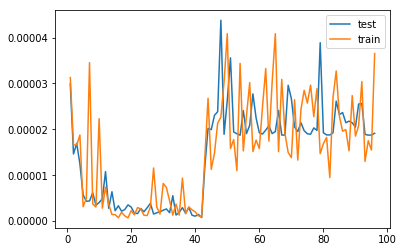

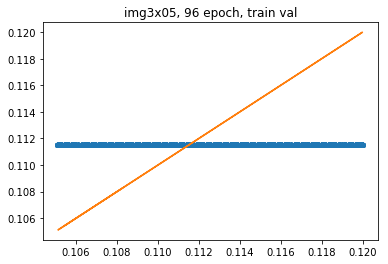

Train Epoch: 97 [0/2030 (0%)]	Loss: 0.000023	 mse: 2.5201434254995547e-05
Train Epoch: 97 [100/2030 (5%)]	Loss: 0.000015	 mse: 8.513996363035403e-06
Train Epoch: 97 [200/2030 (10%)]	Loss: 0.000022	 mse: 2.3981168851605617e-05
Train Epoch: 97 [300/2030 (15%)]	Loss: 0.000025	 mse: 2.7994670745101757e-05
Train Epoch: 97 [400/2030 (20%)]	Loss: 0.000016	 mse: 1.7033151380019262e-05
Train Epoch: 97 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.354943924525287e-05
Train Epoch: 97 [600/2030 (30%)]	Loss: 0.000040	 mse: 2.6243389584124088e-05
Train Epoch: 97 [700/2030 (34%)]	Loss: 0.000026	 mse: 2.9197042749729007e-05
Train Epoch: 97 [800/2030 (39%)]	Loss: 0.000037	 mse: 2.629646405694075e-05
Train Epoch: 97 [900/2030 (44%)]	Loss: 0.000017	 mse: 1.8669166820473038e-05
Train Epoch: 97 [1000/2030 (49%)]	Loss: 0.000019	 mse: 1.826918924052734e-05
Train Epoch: 97 [1100/2030 (54%)]	Loss: 0.000018	 mse: 1.7166576071758755e-05
Train Epoch: 97 [1200/2030 (59%)]	Loss: 0.000025	 mse: 1.5831072232685983e-05
Trai

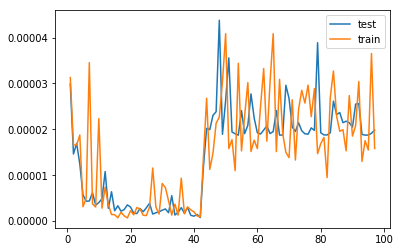

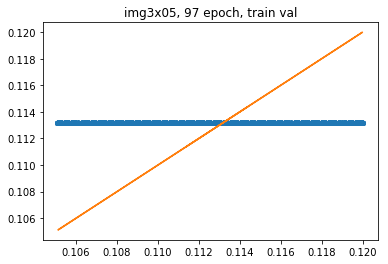

Train Epoch: 98 [0/2030 (0%)]	Loss: 0.000024	 mse: 2.6153333237743936e-05
Train Epoch: 98 [100/2030 (5%)]	Loss: 0.000017	 mse: 1.819641147449147e-05
Train Epoch: 98 [200/2030 (10%)]	Loss: 0.000017	 mse: 1.7979291442316025e-05
Train Epoch: 98 [300/2030 (15%)]	Loss: 0.000020	 mse: 2.202067116741091e-05
Train Epoch: 98 [400/2030 (20%)]	Loss: 0.000026	 mse: 2.7025784220313653e-05
Train Epoch: 98 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.4575326531485189e-05
Train Epoch: 98 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.5842888387851417e-05
Train Epoch: 98 [700/2030 (34%)]	Loss: 0.000036	 mse: 3.319385723443702e-05
Train Epoch: 98 [800/2030 (39%)]	Loss: 0.000019	 mse: 2.120948010997381e-05
Train Epoch: 98 [900/2030 (44%)]	Loss: 0.000035	 mse: 2.711766865104437e-05
Train Epoch: 98 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.616798181203194e-05
Train Epoch: 98 [1100/2030 (54%)]	Loss: 0.000020	 mse: 2.093747752951458e-05
Train Epoch: 98 [1200/2030 (59%)]	Loss: 0.000034	 mse: 1.5155137589317746e-05
Train E

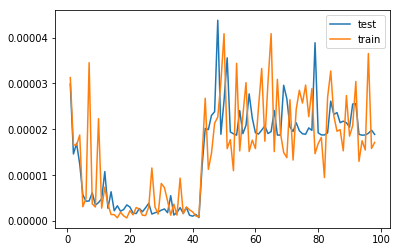

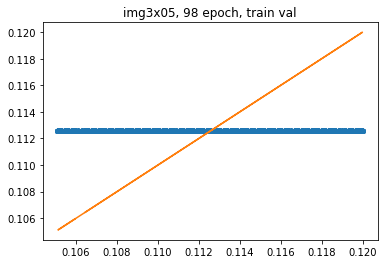

Train Epoch: 99 [0/2030 (0%)]	Loss: 0.000026	 mse: 2.3405920728691854e-05
Train Epoch: 99 [100/2030 (5%)]	Loss: 0.000019	 mse: 2.0411322111613117e-05
Train Epoch: 99 [200/2030 (10%)]	Loss: 0.000028	 mse: 3.0071296350797638e-05
Train Epoch: 99 [300/2030 (15%)]	Loss: 0.000015	 mse: 1.7024351109284908e-05
Train Epoch: 99 [400/2030 (20%)]	Loss: 0.000015	 mse: 1.5744953998364508e-05
Train Epoch: 99 [500/2030 (25%)]	Loss: 0.000016	 mse: 1.7747302990755998e-05
Train Epoch: 99 [600/2030 (30%)]	Loss: 0.000041	 mse: 3.371392813278362e-05
Train Epoch: 99 [700/2030 (34%)]	Loss: 0.000020	 mse: 2.2121645088191144e-05
Train Epoch: 99 [800/2030 (39%)]	Loss: 0.000020	 mse: 2.016145663219504e-05
Train Epoch: 99 [900/2030 (44%)]	Loss: 0.000019	 mse: 1.9311148207634687e-05
Train Epoch: 99 [1000/2030 (49%)]	Loss: 0.000016	 mse: 1.8037499103229493e-05
Train Epoch: 99 [1100/2030 (54%)]	Loss: 0.000011	 mse: 9.664211575000081e-06
Train Epoch: 99 [1200/2030 (59%)]	Loss: 0.000038	 mse: 3.701114474097267e-05
Trai

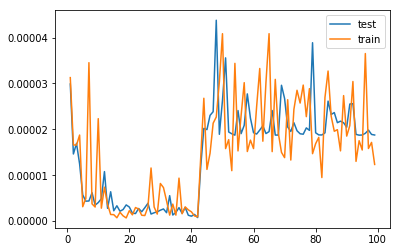

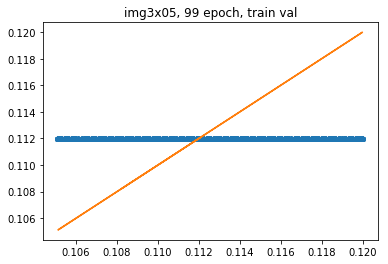

Train Epoch: 100 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.4909189303580206e-05
Train Epoch: 100 [100/2030 (5%)]	Loss: 0.000011	 mse: 1.2058665561198723e-05
Train Epoch: 100 [200/2030 (10%)]	Loss: 0.000029	 mse: 5.877248440810945e-06
Train Epoch: 100 [300/2030 (15%)]	Loss: 0.000025	 mse: 1.1662930774036795e-05
Train Epoch: 100 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.3534788851975463e-05
Train Epoch: 100 [500/2030 (25%)]	Loss: 0.000007	 mse: 5.8357027228339575e-06
Train Epoch: 100 [600/2030 (30%)]	Loss: 0.000031	 mse: 3.1965100788511336e-05
Train Epoch: 100 [700/2030 (34%)]	Loss: 0.000040	 mse: 2.4946722987806424e-05
Train Epoch: 100 [800/2030 (39%)]	Loss: 0.000012	 mse: 1.3052098438492976e-05
Train Epoch: 100 [900/2030 (44%)]	Loss: 0.000012	 mse: 1.3294701602717396e-05
Train Epoch: 100 [1000/2030 (49%)]	Loss: 0.000022	 mse: 1.962501301022712e-05
Train Epoch: 100 [1100/2030 (54%)]	Loss: 0.000032	 mse: 1.209626680065412e-05
Train Epoch: 100 [1200/2030 (59%)]	Loss: 0.000026	 mse: 1.53155469888

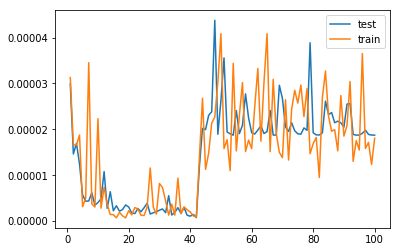

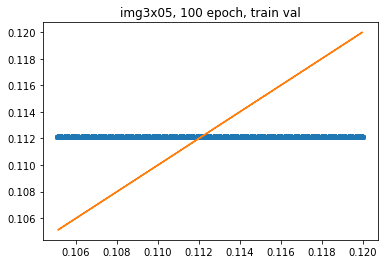

Train Epoch: 101 [0/2030 (0%)]	Loss: 0.000023	 mse: 2.3886563212727197e-05
Train Epoch: 101 [100/2030 (5%)]	Loss: 0.000026	 mse: 2.6037205316242762e-05
Train Epoch: 101 [200/2030 (10%)]	Loss: 0.000026	 mse: 2.4543707695556805e-05
Train Epoch: 101 [300/2030 (15%)]	Loss: 0.000026	 mse: 2.8579617719515227e-05
Train Epoch: 101 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.4932247722754255e-05
Train Epoch: 101 [500/2030 (25%)]	Loss: 0.000033	 mse: 3.3238720789086074e-05
Train Epoch: 101 [600/2030 (30%)]	Loss: 0.000012	 mse: 1.2868638805230148e-05
Train Epoch: 101 [700/2030 (34%)]	Loss: 0.000024	 mse: 2.6479936423129402e-05
Train Epoch: 101 [800/2030 (39%)]	Loss: 0.000025	 mse: 1.5823805370018817e-05
Train Epoch: 101 [900/2030 (44%)]	Loss: 0.000035	 mse: 2.745640267676208e-05
Train Epoch: 101 [1000/2030 (49%)]	Loss: 0.000038	 mse: 2.701608718780335e-05
Train Epoch: 101 [1100/2030 (54%)]	Loss: 0.000020	 mse: 1.6317473637172952e-05
Train Epoch: 101 [1200/2030 (59%)]	Loss: 0.000013	 mse: 1.4081635526

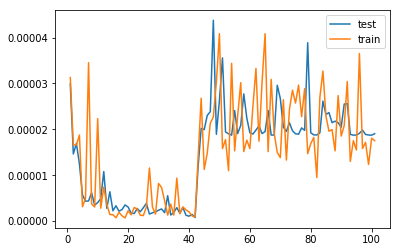

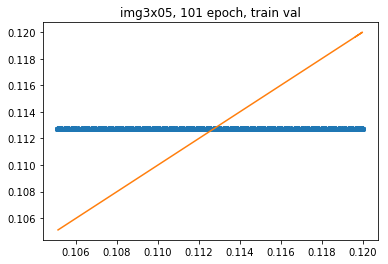

Train Epoch: 102 [0/2030 (0%)]	Loss: 0.000021	 mse: 2.293649231432937e-05
Train Epoch: 102 [100/2030 (5%)]	Loss: 0.000021	 mse: 1.7383397789672017e-05
Train Epoch: 102 [200/2030 (10%)]	Loss: 0.000012	 mse: 1.0899047993007116e-05
Train Epoch: 102 [300/2030 (15%)]	Loss: 0.000015	 mse: 1.6849677194841206e-05
Train Epoch: 102 [400/2030 (20%)]	Loss: 0.000004	 mse: 4.683365204982692e-06
Train Epoch: 102 [500/2030 (25%)]	Loss: 0.000009	 mse: 9.849802154349163e-06
Train Epoch: 102 [600/2030 (30%)]	Loss: 0.000019	 mse: 2.0411322111613117e-05
Train Epoch: 102 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.6594947737758048e-05
Train Epoch: 102 [800/2030 (39%)]	Loss: 0.000024	 mse: 1.8369561075815e-05
Train Epoch: 102 [900/2030 (44%)]	Loss: 0.000027	 mse: 2.522086288081482e-05
Train Epoch: 102 [1000/2030 (49%)]	Loss: 0.000024	 mse: 2.331371979380492e-05
Train Epoch: 102 [1100/2030 (54%)]	Loss: 0.000017	 mse: 1.817215706978459e-05
Train Epoch: 102 [1200/2030 (59%)]	Loss: 0.000026	 mse: 2.7080355721409433e

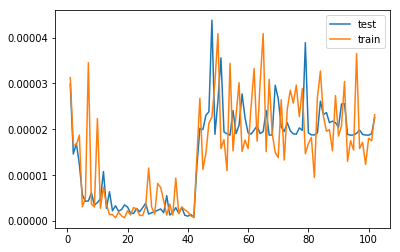

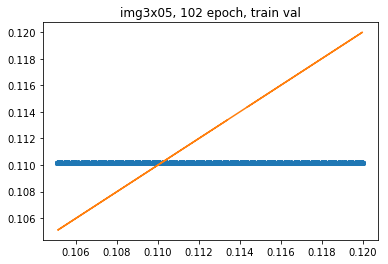

Train Epoch: 103 [0/2030 (0%)]	Loss: 0.000027	 mse: 2.0525052605080418e-05
Train Epoch: 103 [100/2030 (5%)]	Loss: 0.000022	 mse: 2.347170448047109e-05
Train Epoch: 103 [200/2030 (10%)]	Loss: 0.000019	 mse: 2.0562954887282103e-05
Train Epoch: 103 [300/2030 (15%)]	Loss: 0.000027	 mse: 1.659373810980469e-05
Train Epoch: 103 [400/2030 (20%)]	Loss: 0.000024	 mse: 2.4367813239223324e-05
Train Epoch: 103 [500/2030 (25%)]	Loss: 0.000022	 mse: 2.479842623870354e-05
Train Epoch: 103 [600/2030 (30%)]	Loss: 0.000009	 mse: 9.449517165194266e-06
Train Epoch: 103 [700/2030 (34%)]	Loss: 0.000021	 mse: 1.7860107618616894e-05
Train Epoch: 103 [800/2030 (39%)]	Loss: 0.000026	 mse: 2.5726360036060214e-05
Train Epoch: 103 [900/2030 (44%)]	Loss: 0.000018	 mse: 1.5676720067858696e-05
Train Epoch: 103 [1000/2030 (49%)]	Loss: 0.000006	 mse: 5.748371222580317e-06
Train Epoch: 103 [1100/2030 (54%)]	Loss: 0.000021	 mse: 1.8705557522480376e-05
Train Epoch: 103 [1200/2030 (59%)]	Loss: 0.000011	 mse: 1.1335412636981

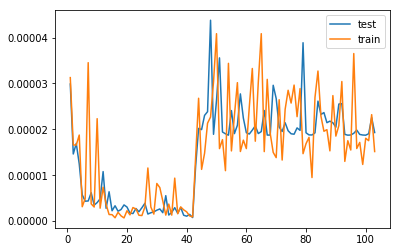

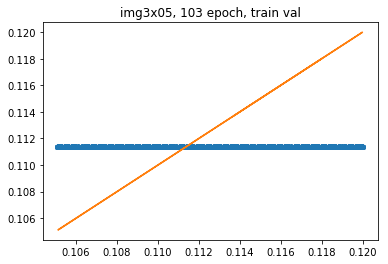

Train Epoch: 104 [0/2030 (0%)]	Loss: 0.000025	 mse: 2.1456631657201797e-05
Train Epoch: 104 [100/2030 (5%)]	Loss: 0.000020	 mse: 2.224142554041464e-05
Train Epoch: 104 [200/2030 (10%)]	Loss: 0.000023	 mse: 2.5505922167212702e-05
Train Epoch: 104 [300/2030 (15%)]	Loss: 0.000032	 mse: 1.5162705494731199e-05
Train Epoch: 104 [400/2030 (20%)]	Loss: 0.000011	 mse: 1.2201488971186336e-05
Train Epoch: 104 [500/2030 (25%)]	Loss: 0.000024	 mse: 2.3102642444428056e-05
Train Epoch: 104 [600/2030 (30%)]	Loss: 0.000018	 mse: 1.9631066606962122e-05
Train Epoch: 104 [700/2030 (34%)]	Loss: 0.000022	 mse: 2.3140573830460198e-05
Train Epoch: 104 [800/2030 (39%)]	Loss: 0.000020	 mse: 2.099204903061036e-05
Train Epoch: 104 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.2040381736587733e-05
Train Epoch: 104 [1000/2030 (49%)]	Loss: 0.000026	 mse: 2.143479105143342e-05
Train Epoch: 104 [1100/2030 (54%)]	Loss: 0.000021	 mse: 2.2188363800523803e-05
Train Epoch: 104 [1200/2030 (59%)]	Loss: 0.000027	 mse: 2.95451591227

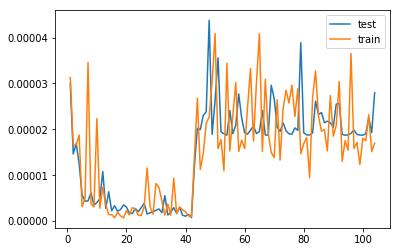

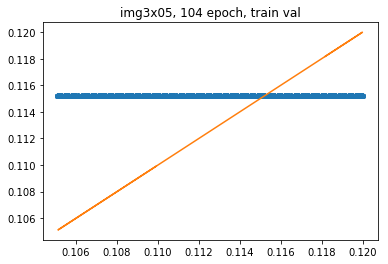

Train Epoch: 105 [0/2030 (0%)]	Loss: 0.000036	 mse: 2.4838755052769557e-05
Train Epoch: 105 [100/2030 (5%)]	Loss: 0.000029	 mse: 1.8590333638712764e-05
Train Epoch: 105 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.586715916346293e-05
Train Epoch: 105 [300/2030 (15%)]	Loss: 0.000034	 mse: 1.2506257917266339e-05
Train Epoch: 105 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.1949495274166111e-05
Train Epoch: 105 [500/2030 (25%)]	Loss: 0.000020	 mse: 2.1695585019188002e-05
Train Epoch: 105 [600/2030 (30%)]	Loss: 0.000016	 mse: 1.717021041258704e-05
Train Epoch: 105 [700/2030 (34%)]	Loss: 0.000023	 mse: 1.3973981367598753e-05
Train Epoch: 105 [800/2030 (39%)]	Loss: 0.000040	 mse: 2.6807434551301412e-05
Train Epoch: 105 [900/2030 (44%)]	Loss: 0.000013	 mse: 1.4275721696321853e-05
Train Epoch: 105 [1000/2030 (49%)]	Loss: 0.000024	 mse: 2.376979864493478e-05
Train Epoch: 105 [1100/2030 (54%)]	Loss: 0.000017	 mse: 1.7612652300158516e-05
Train Epoch: 105 [1200/2030 (59%)]	Loss: 0.000024	 mse: 2.57409155892

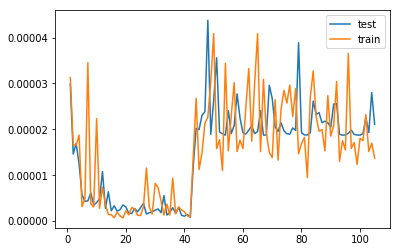

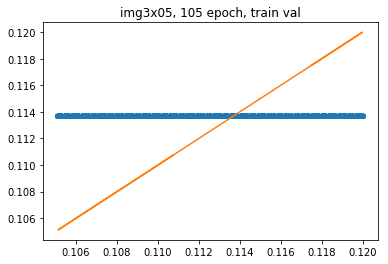

Train Epoch: 106 [0/2030 (0%)]	Loss: 0.000024	 mse: 1.0439021934871562e-05
Train Epoch: 106 [100/2030 (5%)]	Loss: 0.000019	 mse: 1.7340040358249098e-05
Train Epoch: 106 [200/2030 (10%)]	Loss: 0.000031	 mse: 3.2212228688877076e-05
Train Epoch: 106 [300/2030 (15%)]	Loss: 0.000013	 mse: 1.350333695882e-05
Train Epoch: 106 [400/2030 (20%)]	Loss: 0.000038	 mse: 2.110121749865357e-05
Train Epoch: 106 [500/2030 (25%)]	Loss: 0.000021	 mse: 1.953039645741228e-05
Train Epoch: 106 [600/2030 (30%)]	Loss: 0.000029	 mse: 8.720207006263081e-06
Train Epoch: 106 [700/2030 (34%)]	Loss: 0.000015	 mse: 1.662436443439219e-05
Train Epoch: 106 [800/2030 (39%)]	Loss: 0.000031	 mse: 3.465640475042164e-05
Train Epoch: 106 [900/2030 (44%)]	Loss: 0.000016	 mse: 1.287622217205353e-05
Train Epoch: 106 [1000/2030 (49%)]	Loss: 0.000018	 mse: 2.028002927545458e-05
Train Epoch: 106 [1100/2030 (54%)]	Loss: 0.000022	 mse: 2.078614488709718e-05
Train Epoch: 106 [1200/2030 (59%)]	Loss: 0.000029	 mse: 2.4570374080212787e-05

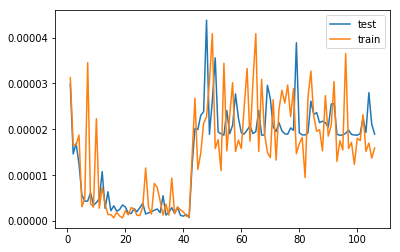

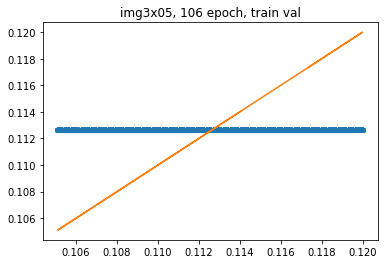

Train Epoch: 107 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.63511504069902e-05
Train Epoch: 107 [100/2030 (5%)]	Loss: 0.000014	 mse: 1.529099426988978e-05
Train Epoch: 107 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.2228185369167477e-05
Train Epoch: 107 [300/2030 (15%)]	Loss: 0.000019	 mse: 1.9978289856226183e-05
Train Epoch: 107 [400/2030 (20%)]	Loss: 0.000026	 mse: 2.5915895093930885e-05
Train Epoch: 107 [500/2030 (25%)]	Loss: 0.000009	 mse: 7.450495559169212e-06
Train Epoch: 107 [600/2030 (30%)]	Loss: 0.000018	 mse: 1.786253233149182e-05
Train Epoch: 107 [700/2030 (34%)]	Loss: 0.000019	 mse: 1.8419605112285353e-05
Train Epoch: 107 [800/2030 (39%)]	Loss: 0.000025	 mse: 2.6044168407679535e-05
Train Epoch: 107 [900/2030 (44%)]	Loss: 0.000024	 mse: 1.9711447748704813e-05
Train Epoch: 107 [1000/2030 (49%)]	Loss: 0.000019	 mse: 1.7128662875620648e-05
Train Epoch: 107 [1100/2030 (54%)]	Loss: 0.000018	 mse: 1.7921969629242085e-05
Train Epoch: 107 [1200/2030 (59%)]	Loss: 0.000023	 mse: 2.5825826014624

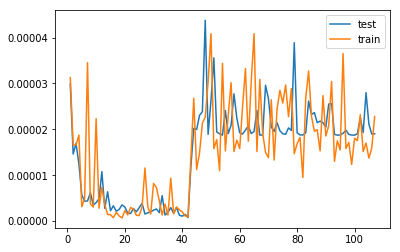

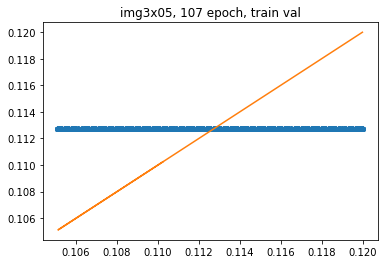

Train Epoch: 108 [0/2030 (0%)]	Loss: 0.000018	 mse: 1.9372700990061276e-05
Train Epoch: 108 [100/2030 (5%)]	Loss: 0.000021	 mse: 2.0233937902958132e-05
Train Epoch: 108 [200/2030 (10%)]	Loss: 0.000021	 mse: 1.7967158782994375e-05
Train Epoch: 108 [300/2030 (15%)]	Loss: 0.000023	 mse: 1.991248609556351e-05
Train Epoch: 108 [400/2030 (20%)]	Loss: 0.000022	 mse: 1.3544582543545403e-05
Train Epoch: 108 [500/2030 (25%)]	Loss: 0.000022	 mse: 2.2847025320515968e-05
Train Epoch: 108 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.5498706488870084e-05
Train Epoch: 108 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.8369561075815e-05
Train Epoch: 108 [800/2030 (39%)]	Loss: 0.000014	 mse: 1.5048685781948734e-05
Train Epoch: 108 [900/2030 (44%)]	Loss: 0.000028	 mse: 2.113761001965031e-05
Train Epoch: 108 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.050602804752998e-05
Train Epoch: 108 [1100/2030 (54%)]	Loss: 0.000010	 mse: 1.0725594620453194e-05
Train Epoch: 108 [1200/2030 (59%)]	Loss: 0.000034	 mse: 2.68265575869008

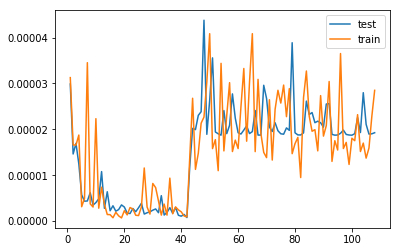

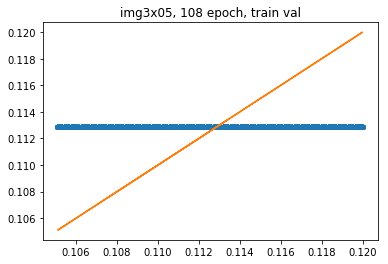

Train Epoch: 109 [0/2030 (0%)]	Loss: 0.000025	 mse: 2.594015131762717e-05
Train Epoch: 109 [100/2030 (5%)]	Loss: 0.000027	 mse: 2.0760384359164163e-05
Train Epoch: 109 [200/2030 (10%)]	Loss: 0.000015	 mse: 1.5017158148111776e-05
Train Epoch: 109 [300/2030 (15%)]	Loss: 0.000020	 mse: 1.8420812921249308e-05
Train Epoch: 109 [400/2030 (20%)]	Loss: 0.000028	 mse: 3.1095063604880124e-05
Train Epoch: 109 [500/2030 (25%)]	Loss: 0.000018	 mse: 1.0012041457230225e-05
Train Epoch: 109 [600/2030 (30%)]	Loss: 0.000023	 mse: 2.3398941266350448e-05
Train Epoch: 109 [700/2030 (34%)]	Loss: 0.000012	 mse: 1.2851963219873141e-05
Train Epoch: 109 [800/2030 (39%)]	Loss: 0.000020	 mse: 2.1900876163272187e-05
Train Epoch: 109 [900/2030 (44%)]	Loss: 0.000020	 mse: 1.7655112969805487e-05
Train Epoch: 109 [1000/2030 (49%)]	Loss: 0.000021	 mse: 2.340348692086991e-05
Train Epoch: 109 [1100/2030 (54%)]	Loss: 0.000008	 mse: 8.430614798271563e-06
Train Epoch: 109 [1200/2030 (59%)]	Loss: 0.000027	 mse: 1.54077406477

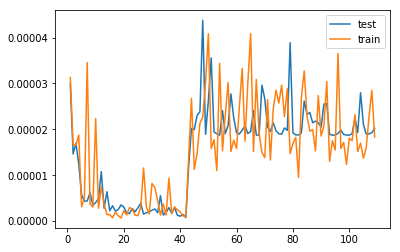

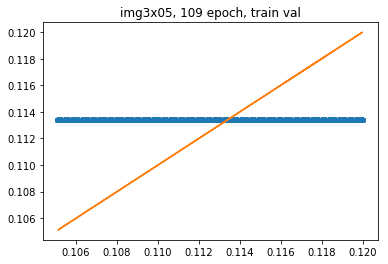

Train Epoch: 110 [0/2030 (0%)]	Loss: 0.000026	 mse: 1.9160435840603895e-05
Train Epoch: 110 [100/2030 (5%)]	Loss: 0.000019	 mse: 1.9436987713561393e-05
Train Epoch: 110 [200/2030 (10%)]	Loss: 0.000021	 mse: 1.9748737031477503e-05
Train Epoch: 110 [300/2030 (15%)]	Loss: 0.000011	 mse: 9.479536856815685e-06
Train Epoch: 110 [400/2030 (20%)]	Loss: 0.000015	 mse: 1.636206070543267e-05
Train Epoch: 110 [500/2030 (25%)]	Loss: 0.000020	 mse: 2.05286851269193e-05
Train Epoch: 110 [600/2030 (30%)]	Loss: 0.000020	 mse: 2.1009345800848678e-05
Train Epoch: 110 [700/2030 (34%)]	Loss: 0.000012	 mse: 1.2937786777911242e-05
Train Epoch: 110 [800/2030 (39%)]	Loss: 0.000016	 mse: 1.4774255760130472e-05
Train Epoch: 110 [900/2030 (44%)]	Loss: 0.000033	 mse: 3.06717302009929e-05
Train Epoch: 110 [1000/2030 (49%)]	Loss: 0.000012	 mse: 1.295143101742724e-05
Train Epoch: 110 [1100/2030 (54%)]	Loss: 0.000018	 mse: 1.992218676605262e-05
Train Epoch: 110 [1200/2030 (59%)]	Loss: 0.000019	 mse: 2.0681831301772036

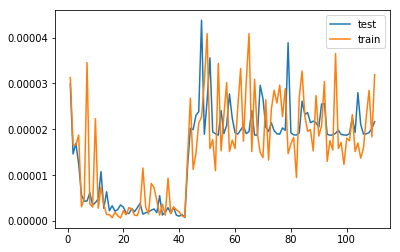

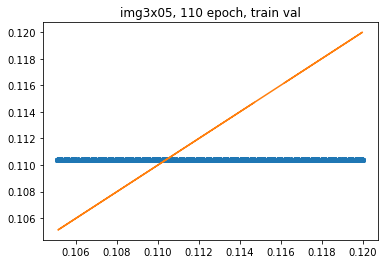

Train Epoch: 111 [0/2030 (0%)]	Loss: 0.000017	 mse: 1.8916918634204194e-05
Train Epoch: 111 [100/2030 (5%)]	Loss: 0.000021	 mse: 2.305322777829133e-05
Train Epoch: 111 [200/2030 (10%)]	Loss: 0.000020	 mse: 2.194425542256795e-05
Train Epoch: 111 [300/2030 (15%)]	Loss: 0.000045	 mse: 2.0902591131743975e-05
Train Epoch: 111 [400/2030 (20%)]	Loss: 0.000018	 mse: 1.650427293498069e-05
Train Epoch: 111 [500/2030 (25%)]	Loss: 0.000029	 mse: 2.0105655494262464e-05
Train Epoch: 111 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.672595135460142e-05
Train Epoch: 111 [700/2030 (34%)]	Loss: 0.000024	 mse: 2.633681651786901e-05
Train Epoch: 111 [800/2030 (39%)]	Loss: 0.000020	 mse: 1.7807033145800233e-05
Train Epoch: 111 [900/2030 (44%)]	Loss: 0.000019	 mse: 2.06038894248195e-05
Train Epoch: 111 [1000/2030 (49%)]	Loss: 0.000019	 mse: 1.4465241292782594e-05
Train Epoch: 111 [1100/2030 (54%)]	Loss: 0.000016	 mse: 1.6698066247045062e-05
Train Epoch: 111 [1200/2030 (59%)]	Loss: 0.000016	 mse: 1.630413498787675

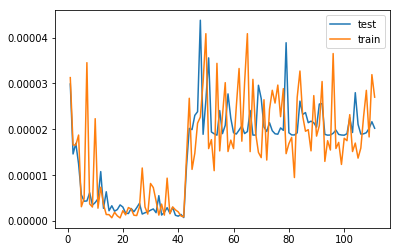

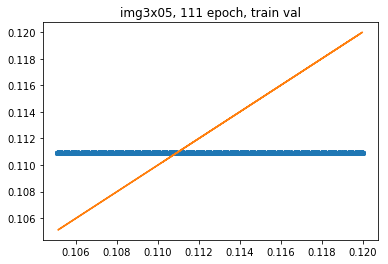

Train Epoch: 112 [0/2030 (0%)]	Loss: 0.000021	 mse: 2.1333216864150017e-05
Train Epoch: 112 [100/2030 (5%)]	Loss: 0.000012	 mse: 1.30581638586591e-05
Train Epoch: 112 [200/2030 (10%)]	Loss: 0.000028	 mse: 2.3193635570351034e-05
Train Epoch: 112 [300/2030 (15%)]	Loss: 0.000023	 mse: 2.4438466425635852e-05
Train Epoch: 112 [400/2030 (20%)]	Loss: 0.000022	 mse: 2.4423598006251268e-05
Train Epoch: 112 [500/2030 (25%)]	Loss: 0.000021	 mse: 1.299388077313779e-05
Train Epoch: 112 [600/2030 (30%)]	Loss: 0.000026	 mse: 2.8012866096105427e-05
Train Epoch: 112 [700/2030 (34%)]	Loss: 0.000023	 mse: 2.5164732505800202e-05
Train Epoch: 112 [800/2030 (39%)]	Loss: 0.000017	 mse: 1.5502055248362012e-05
Train Epoch: 112 [900/2030 (44%)]	Loss: 0.000030	 mse: 2.9026927222730592e-05
Train Epoch: 112 [1000/2030 (49%)]	Loss: 0.000012	 mse: 5.029065050621284e-06
Train Epoch: 112 [1100/2030 (54%)]	Loss: 0.000027	 mse: 2.0094441424589604e-05
Train Epoch: 112 [1200/2030 (59%)]	Loss: 0.000020	 mse: 1.616191912034

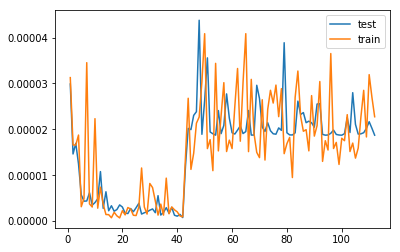

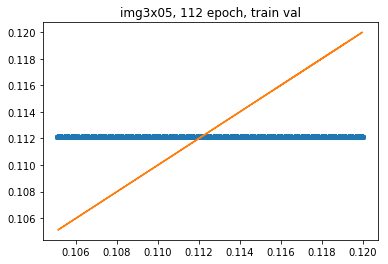

Train Epoch: 113 [0/2030 (0%)]	Loss: 0.000023	 mse: 2.499402398825623e-05
Train Epoch: 113 [100/2030 (5%)]	Loss: 0.000011	 mse: 1.1864288353535812e-05
Train Epoch: 113 [200/2030 (10%)]	Loss: 0.000018	 mse: 7.656717571080662e-06
Train Epoch: 113 [300/2030 (15%)]	Loss: 0.000022	 mse: 2.2273270587902516e-05
Train Epoch: 113 [400/2030 (20%)]	Loss: 0.000028	 mse: 2.3593922378495336e-05
Train Epoch: 113 [500/2030 (25%)]	Loss: 0.000021	 mse: 2.3017741114017554e-05
Train Epoch: 113 [600/2030 (30%)]	Loss: 0.000020	 mse: 1.8231276044389233e-05
Train Epoch: 113 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.8413538782624528e-05
Train Epoch: 113 [800/2030 (39%)]	Loss: 0.000026	 mse: 1.60566942213336e-05
Train Epoch: 113 [900/2030 (44%)]	Loss: 0.000019	 mse: 1.5279169019777328e-05
Train Epoch: 113 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.1281134902674239e-05
Train Epoch: 113 [1100/2030 (54%)]	Loss: 0.000017	 mse: 1.859638541645836e-05
Train Epoch: 113 [1200/2030 (59%)]	Loss: 0.000023	 mse: 2.5571102014509

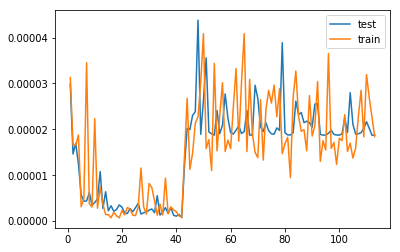

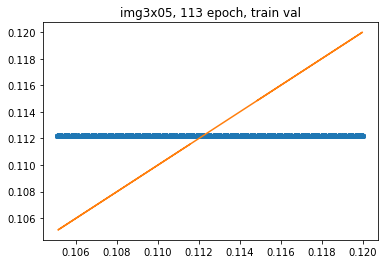

Train Epoch: 114 [0/2030 (0%)]	Loss: 0.000024	 mse: 2.6254005206283182e-05
Train Epoch: 114 [100/2030 (5%)]	Loss: 0.000018	 mse: 1.8767736037261784e-05
Train Epoch: 114 [200/2030 (10%)]	Loss: 0.000025	 mse: 2.4728375137783587e-05
Train Epoch: 114 [300/2030 (15%)]	Loss: 0.000018	 mse: 1.7720594769343734e-05
Train Epoch: 114 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.1046642359578982e-05
Train Epoch: 114 [500/2030 (25%)]	Loss: 0.000010	 mse: 1.0693743206502404e-05
Train Epoch: 114 [600/2030 (30%)]	Loss: 0.000017	 mse: 1.8493277821107768e-05
Train Epoch: 114 [700/2030 (34%)]	Loss: 0.000014	 mse: 1.5180910850176588e-05
Train Epoch: 114 [800/2030 (39%)]	Loss: 0.000025	 mse: 2.679046338016633e-05
Train Epoch: 114 [900/2030 (44%)]	Loss: 0.000018	 mse: 1.5967834769980982e-05
Train Epoch: 114 [1000/2030 (49%)]	Loss: 0.000019	 mse: 2.104207487718668e-05
Train Epoch: 114 [1100/2030 (54%)]	Loss: 0.000015	 mse: 1.2490490007621702e-05
Train Epoch: 114 [1200/2030 (59%)]	Loss: 0.000029	 mse: 1.8831711713

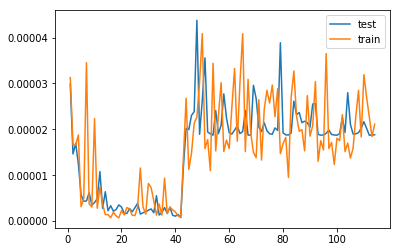

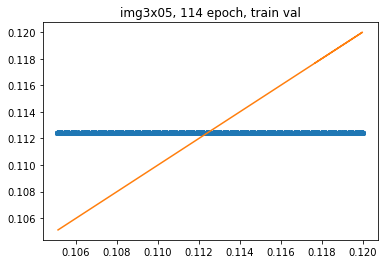

Train Epoch: 115 [0/2030 (0%)]	Loss: 0.000018	 mse: 2.0240004232618958e-05
Train Epoch: 115 [100/2030 (5%)]	Loss: 0.000012	 mse: 1.3278932783578057e-05
Train Epoch: 115 [200/2030 (10%)]	Loss: 0.000020	 mse: 2.1920297513133846e-05
Train Epoch: 115 [300/2030 (15%)]	Loss: 0.000017	 mse: 1.5550873285974376e-05
Train Epoch: 115 [400/2030 (20%)]	Loss: 0.000016	 mse: 5.314424925018102e-06
Train Epoch: 115 [500/2030 (25%)]	Loss: 0.000008	 mse: 7.048699444567319e-06
Train Epoch: 115 [600/2030 (30%)]	Loss: 0.000021	 mse: 2.203401891165413e-05
Train Epoch: 115 [700/2030 (34%)]	Loss: 0.000016	 mse: 1.5529036318184808e-05
Train Epoch: 115 [800/2030 (39%)]	Loss: 0.000020	 mse: 1.644089752517175e-05
Train Epoch: 115 [900/2030 (44%)]	Loss: 0.000020	 mse: 2.1715297407354228e-05
Train Epoch: 115 [1000/2030 (49%)]	Loss: 0.000010	 mse: 1.0814133929670788e-05
Train Epoch: 115 [1100/2030 (54%)]	Loss: 0.000023	 mse: 1.5624549632775597e-05
Train Epoch: 115 [1200/2030 (59%)]	Loss: 0.000027	 mse: 2.350657814531

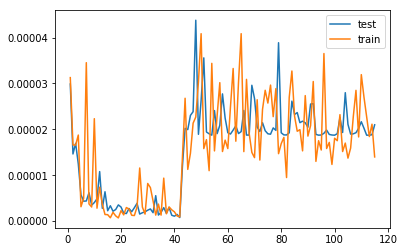

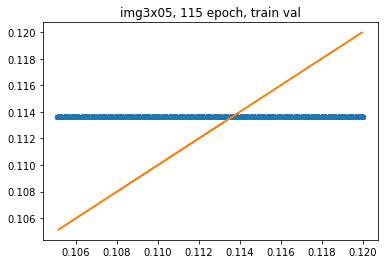

Train Epoch: 116 [0/2030 (0%)]	Loss: 0.000013	 mse: 1.1566180546651594e-05
Train Epoch: 116 [100/2030 (5%)]	Loss: 0.000015	 mse: 1.6769625290180556e-05
Train Epoch: 116 [200/2030 (10%)]	Loss: 0.000010	 mse: 9.664211575000081e-06
Train Epoch: 116 [300/2030 (15%)]	Loss: 0.000010	 mse: 9.251805749954656e-06
Train Epoch: 116 [400/2030 (20%)]	Loss: 0.000029	 mse: 2.7451547794044018e-05
Train Epoch: 116 [500/2030 (25%)]	Loss: 0.000019	 mse: 2.030429823207669e-05
Train Epoch: 116 [600/2030 (30%)]	Loss: 0.000022	 mse: 1.182789037557086e-05
Train Epoch: 116 [700/2030 (34%)]	Loss: 0.000016	 mse: 1.7309710528934374e-05
Train Epoch: 116 [800/2030 (39%)]	Loss: 0.000029	 mse: 2.8246049623703584e-05
Train Epoch: 116 [900/2030 (44%)]	Loss: 0.000016	 mse: 1.3447235687635839e-05
Train Epoch: 116 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.586867256264668e-05
Train Epoch: 116 [1100/2030 (54%)]	Loss: 0.000019	 mse: 2.0778863472514786e-05
Train Epoch: 116 [1200/2030 (59%)]	Loss: 0.000016	 mse: 1.7444344848627

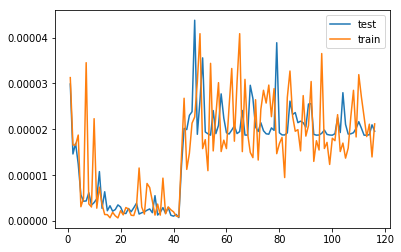

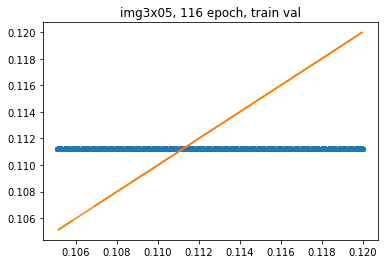

Train Epoch: 117 [0/2030 (0%)]	Loss: 0.000031	 mse: 3.3965003240155056e-05
Train Epoch: 117 [100/2030 (5%)]	Loss: 0.000020	 mse: 2.1646164896083064e-05
Train Epoch: 117 [200/2030 (10%)]	Loss: 0.000018	 mse: 1.802993028832134e-05
Train Epoch: 117 [300/2030 (15%)]	Loss: 0.000012	 mse: 1.344876000075601e-05
Train Epoch: 117 [400/2030 (20%)]	Loss: 0.000021	 mse: 1.8593951608636416e-05
Train Epoch: 117 [500/2030 (25%)]	Loss: 0.000021	 mse: 1.3858743841410615e-05
Train Epoch: 117 [600/2030 (30%)]	Loss: 0.000025	 mse: 2.3263981347554363e-05
Train Epoch: 117 [700/2030 (34%)]	Loss: 0.000010	 mse: 1.075348427548306e-05
Train Epoch: 117 [800/2030 (39%)]	Loss: 0.000054	 mse: 2.1036008547525853e-05
Train Epoch: 117 [900/2030 (44%)]	Loss: 0.000014	 mse: 1.5843206710997038e-05
Train Epoch: 117 [1000/2030 (49%)]	Loss: 0.000022	 mse: 2.2599568183068186e-05
Train Epoch: 117 [1100/2030 (54%)]	Loss: 0.000017	 mse: 1.839534343162086e-05
Train Epoch: 117 [1200/2030 (59%)]	Loss: 0.000013	 mse: 7.943893251649

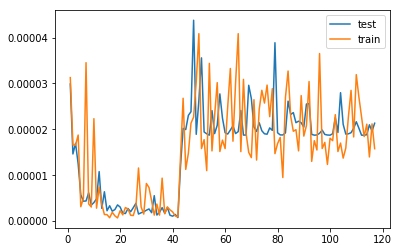

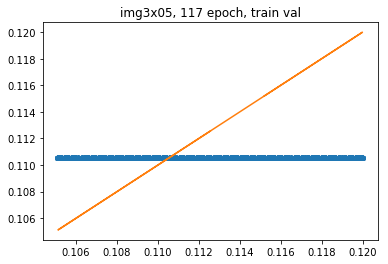

Train Epoch: 118 [0/2030 (0%)]	Loss: 0.000029	 mse: 2.245279938506428e-05
Train Epoch: 118 [100/2030 (5%)]	Loss: 0.000042	 mse: 3.53832911059726e-05
Train Epoch: 118 [200/2030 (10%)]	Loss: 0.000018	 mse: 1.8743467080639675e-05
Train Epoch: 118 [300/2030 (15%)]	Loss: 0.000025	 mse: 2.7236526875640266e-05
Train Epoch: 118 [400/2030 (20%)]	Loss: 0.000023	 mse: 1.7031936295097694e-05
Train Epoch: 118 [500/2030 (25%)]	Loss: 0.000016	 mse: 1.7862525055534206e-05
Train Epoch: 118 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.587929182278458e-05
Train Epoch: 118 [700/2030 (34%)]	Loss: 0.000020	 mse: 2.245279938506428e-05
Train Epoch: 118 [800/2030 (39%)]	Loss: 0.000006	 mse: 5.931834948569303e-06
Train Epoch: 118 [900/2030 (44%)]	Loss: 0.000022	 mse: 2.0979930923203938e-05
Train Epoch: 118 [1000/2030 (49%)]	Loss: 0.000011	 mse: 1.1245656423852779e-05
Train Epoch: 118 [1100/2030 (54%)]	Loss: 0.000013	 mse: 1.411953508068109e-05
Train Epoch: 118 [1200/2030 (59%)]	Loss: 0.000012	 mse: 1.328833877778379

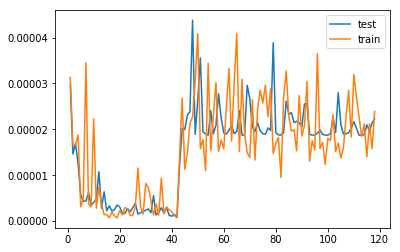

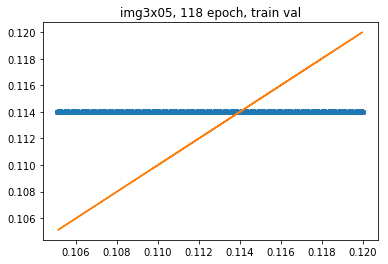

Train Epoch: 119 [0/2030 (0%)]	Loss: 0.000024	 mse: 2.2311791326501407e-05
Train Epoch: 119 [100/2030 (5%)]	Loss: 0.000024	 mse: 1.6659245375194587e-05
Train Epoch: 119 [200/2030 (10%)]	Loss: 0.000021	 mse: 1.9159531802870333e-05
Train Epoch: 119 [300/2030 (15%)]	Loss: 0.000017	 mse: 1.9245344446972013e-05
Train Epoch: 119 [400/2030 (20%)]	Loss: 0.000013	 mse: 1.3725311873713508e-05
Train Epoch: 119 [500/2030 (25%)]	Loss: 0.000023	 mse: 2.1717414711019956e-05
Train Epoch: 119 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.6272302673314698e-05
Train Epoch: 119 [700/2030 (34%)]	Loss: 0.000019	 mse: 2.155762012989726e-05
Train Epoch: 119 [800/2030 (39%)]	Loss: 0.000024	 mse: 2.2558322598342784e-05
Train Epoch: 119 [900/2030 (44%)]	Loss: 0.000018	 mse: 1.941060327226296e-05
Train Epoch: 119 [1000/2030 (49%)]	Loss: 0.000014	 mse: 1.4363355148816481e-05
Train Epoch: 119 [1100/2030 (54%)]	Loss: 0.000025	 mse: 2.6439920475240797e-05
Train Epoch: 119 [1200/2030 (59%)]	Loss: 0.000028	 mse: 3.1375562684

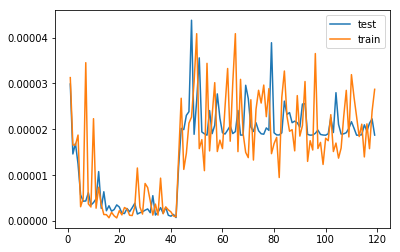

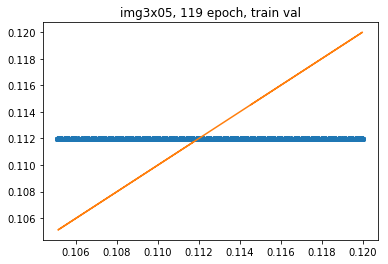

Train Epoch: 120 [0/2030 (0%)]	Loss: 0.000008	 mse: 7.889302651165053e-06
Train Epoch: 120 [100/2030 (5%)]	Loss: 0.000012	 mse: 7.598182492074557e-06
Train Epoch: 120 [200/2030 (10%)]	Loss: 0.000013	 mse: 1.0307101547368802e-05
Train Epoch: 120 [300/2030 (15%)]	Loss: 0.000033	 mse: 3.628545528044924e-05
Train Epoch: 120 [400/2030 (20%)]	Loss: 0.000013	 mse: 1.2687904927588534e-05
Train Epoch: 120 [500/2030 (25%)]	Loss: 0.000018	 mse: 1.1985584933427162e-05
Train Epoch: 120 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.3118817150825635e-05
Train Epoch: 120 [700/2030 (34%)]	Loss: 0.000037	 mse: 2.3896267521195114e-05
Train Epoch: 120 [800/2030 (39%)]	Loss: 0.000015	 mse: 1.5746169083286077e-05
Train Epoch: 120 [900/2030 (44%)]	Loss: 0.000021	 mse: 1.762963438523002e-05
Train Epoch: 120 [1000/2030 (49%)]	Loss: 0.000014	 mse: 1.591325235494878e-05
Train Epoch: 120 [1100/2030 (54%)]	Loss: 0.000023	 mse: 2.5865856514428742e-05
Train Epoch: 120 [1200/2030 (59%)]	Loss: 0.000021	 mse: 1.9804845578619

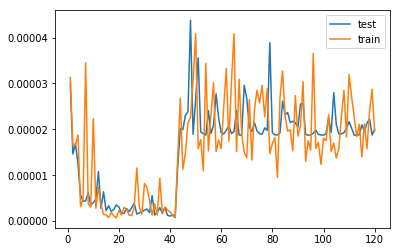

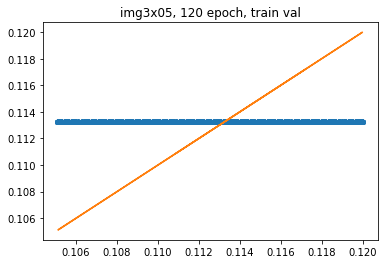

Train Epoch: 121 [0/2030 (0%)]	Loss: 0.000016	 mse: 1.5109040759853087e-05
Train Epoch: 121 [100/2030 (5%)]	Loss: 0.000020	 mse: 1.7376118194079027e-05
Train Epoch: 121 [200/2030 (10%)]	Loss: 0.000021	 mse: 2.1445714082801715e-05
Train Epoch: 121 [300/2030 (15%)]	Loss: 0.000017	 mse: 1.9063389117945917e-05
Train Epoch: 121 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.3229113139677793e-05
Train Epoch: 121 [500/2030 (25%)]	Loss: 0.000041	 mse: 2.6571824491838925e-05
Train Epoch: 121 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.6381776731577702e-05
Train Epoch: 121 [700/2030 (34%)]	Loss: 0.000017	 mse: 1.51490603457205e-05
Train Epoch: 121 [800/2030 (39%)]	Loss: 0.000019	 mse: 2.1278618078213185e-05
Train Epoch: 121 [900/2030 (44%)]	Loss: 0.000023	 mse: 2.461800249875523e-05
Train Epoch: 121 [1000/2030 (49%)]	Loss: 0.000021	 mse: 2.11109290830791e-05
Train Epoch: 121 [1100/2030 (54%)]	Loss: 0.000019	 mse: 1.7910140741150826e-05
Train Epoch: 121 [1200/2030 (59%)]	Loss: 0.000023	 mse: 2.3744642021483

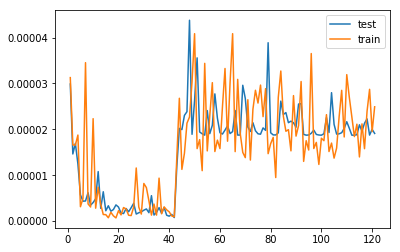

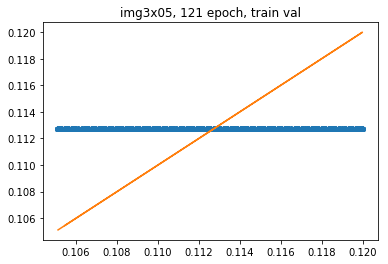

Train Epoch: 122 [0/2030 (0%)]	Loss: 0.000020	 mse: 1.994646663661115e-05
Train Epoch: 122 [100/2030 (5%)]	Loss: 0.000018	 mse: 1.5284913388313726e-05
Train Epoch: 122 [200/2030 (10%)]	Loss: 0.000028	 mse: 3.119241227977909e-05
Train Epoch: 122 [300/2030 (15%)]	Loss: 0.000017	 mse: 1.7864043911686167e-05
Train Epoch: 122 [400/2030 (20%)]	Loss: 0.000017	 mse: 1.5430472558364272e-05
Train Epoch: 122 [500/2030 (25%)]	Loss: 0.000023	 mse: 1.4381544133357238e-05
Train Epoch: 122 [600/2030 (30%)]	Loss: 0.000026	 mse: 2.3927505026222207e-05
Train Epoch: 122 [700/2030 (34%)]	Loss: 0.000015	 mse: 1.5156646441027988e-05
Train Epoch: 122 [800/2030 (39%)]	Loss: 0.000028	 mse: 3.0351808163686655e-05
Train Epoch: 122 [900/2030 (44%)]	Loss: 0.000012	 mse: 1.2810721273126546e-05
Train Epoch: 122 [1000/2030 (49%)]	Loss: 0.000021	 mse: 2.2206564608495682e-05
Train Epoch: 122 [1100/2030 (54%)]	Loss: 0.000014	 mse: 1.574737689225003e-05
Train Epoch: 122 [1200/2030 (59%)]	Loss: 0.000020	 mse: 2.01747952814

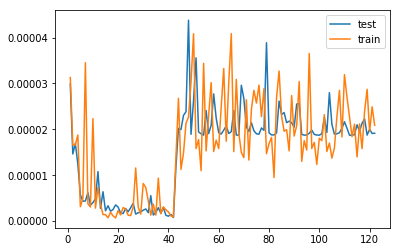

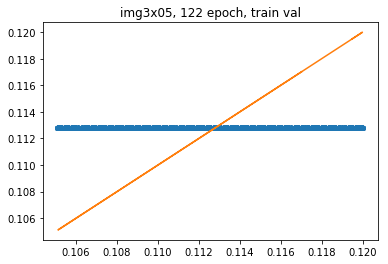

Train Epoch: 123 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.2488060747273266e-05
Train Epoch: 123 [100/2030 (5%)]	Loss: 0.000023	 mse: 2.58613199548563e-05
Train Epoch: 123 [200/2030 (10%)]	Loss: 0.000031	 mse: 2.2653857740806416e-05
Train Epoch: 123 [300/2030 (15%)]	Loss: 0.000014	 mse: 1.5546018403256312e-05
Train Epoch: 123 [400/2030 (20%)]	Loss: 0.000015	 mse: 1.6449697795906104e-05
Train Epoch: 123 [500/2030 (25%)]	Loss: 0.000017	 mse: 1.1167121556354687e-05
Train Epoch: 123 [600/2030 (30%)]	Loss: 0.000025	 mse: 1.624076503503602e-05
Train Epoch: 123 [700/2030 (34%)]	Loss: 0.000020	 mse: 1.9446995793259703e-05
Train Epoch: 123 [800/2030 (39%)]	Loss: 0.000018	 mse: 1.905763929244131e-05
Train Epoch: 123 [900/2030 (44%)]	Loss: 0.000011	 mse: 8.274128049379215e-06
Train Epoch: 123 [1000/2030 (49%)]	Loss: 0.000017	 mse: 1.8661899957805872e-05
Train Epoch: 123 [1100/2030 (54%)]	Loss: 0.000018	 mse: 1.9859420717693865e-05
Train Epoch: 123 [1200/2030 (59%)]	Loss: 0.000017	 mse: 1.8509052097215

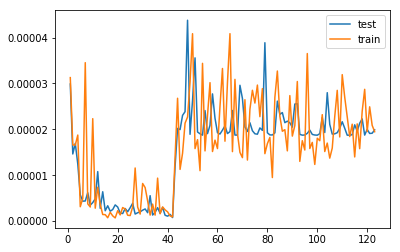

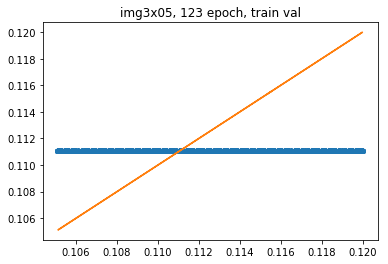

Train Epoch: 124 [0/2030 (0%)]	Loss: 0.000011	 mse: 1.1833051758003421e-05
Train Epoch: 124 [100/2030 (5%)]	Loss: 0.000021	 mse: 2.078585202980321e-05
Train Epoch: 124 [200/2030 (10%)]	Loss: 0.000014	 mse: 1.3549435607274063e-05
Train Epoch: 124 [300/2030 (15%)]	Loss: 0.000021	 mse: 1.9269609765615314e-05
Train Epoch: 124 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.1433888832689263e-05
Train Epoch: 124 [500/2030 (25%)]	Loss: 0.000025	 mse: 2.368247260164935e-05
Train Epoch: 124 [600/2030 (30%)]	Loss: 0.000010	 mse: 6.536819910252234e-06
Train Epoch: 124 [700/2030 (34%)]	Loss: 0.000024	 mse: 2.63085967162624e-05
Train Epoch: 124 [800/2030 (39%)]	Loss: 0.000017	 mse: 1.8298000213690102e-05
Train Epoch: 124 [900/2030 (44%)]	Loss: 0.000020	 mse: 1.8566081052995287e-05
Train Epoch: 124 [1000/2030 (49%)]	Loss: 0.000017	 mse: 1.800111203920096e-05
Train Epoch: 124 [1100/2030 (54%)]	Loss: 0.000012	 mse: 1.2293674444663338e-05
Train Epoch: 124 [1200/2030 (59%)]	Loss: 0.000023	 mse: 1.26178620121208

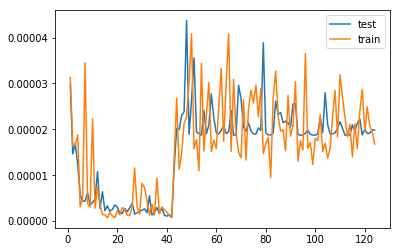

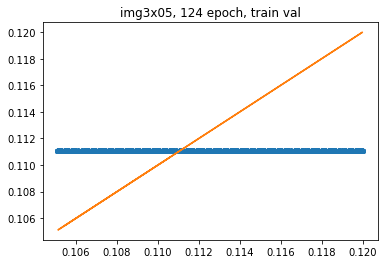

Train Epoch: 125 [0/2030 (0%)]	Loss: 0.000017	 mse: 1.559332486067433e-05
Train Epoch: 125 [100/2030 (5%)]	Loss: 0.000017	 mse: 1.8487529814592563e-05
Train Epoch: 125 [200/2030 (10%)]	Loss: 0.000018	 mse: 1.83601732715033e-05
Train Epoch: 125 [300/2030 (15%)]	Loss: 0.000013	 mse: 1.4688123883388471e-05
Train Epoch: 125 [400/2030 (20%)]	Loss: 0.000027	 mse: 2.6460233129910193e-05
Train Epoch: 125 [500/2030 (25%)]	Loss: 0.000025	 mse: 2.7838192181661725e-05
Train Epoch: 125 [600/2030 (30%)]	Loss: 0.000022	 mse: 2.430109634588007e-05
Train Epoch: 125 [700/2030 (34%)]	Loss: 0.000028	 mse: 2.985660103149712e-05
Train Epoch: 125 [800/2030 (39%)]	Loss: 0.000015	 mse: 1.688971315161325e-05
Train Epoch: 125 [900/2030 (44%)]	Loss: 0.000029	 mse: 2.7974348995485343e-05
Train Epoch: 125 [1000/2030 (49%)]	Loss: 0.000017	 mse: 1.7553222278365865e-05
Train Epoch: 125 [1100/2030 (54%)]	Loss: 0.000033	 mse: 3.601253411034122e-05
Train Epoch: 125 [1200/2030 (59%)]	Loss: 0.000032	 mse: 2.114975541189778

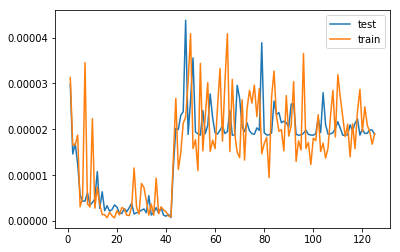

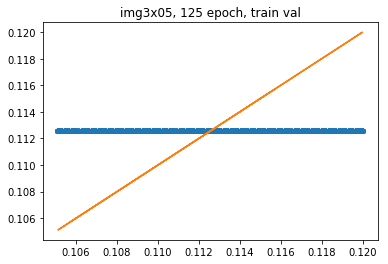

Train Epoch: 126 [0/2030 (0%)]	Loss: 0.000021	 mse: 2.0246368876541965e-05
Train Epoch: 126 [100/2030 (5%)]	Loss: 0.000026	 mse: 1.9932202121708542e-05
Train Epoch: 126 [200/2030 (10%)]	Loss: 0.000027	 mse: 2.480084185663145e-05
Train Epoch: 126 [300/2030 (15%)]	Loss: 0.000011	 mse: 1.0541214578552172e-05
Train Epoch: 126 [400/2030 (20%)]	Loss: 0.000024	 mse: 2.062694329652004e-05
Train Epoch: 126 [500/2030 (25%)]	Loss: 0.000019	 mse: 1.702313602436334e-05
Train Epoch: 126 [600/2030 (30%)]	Loss: 0.000013	 mse: 1.403431724611437e-05
Train Epoch: 126 [700/2030 (34%)]	Loss: 0.000016	 mse: 1.7706361177260987e-05
Train Epoch: 126 [800/2030 (39%)]	Loss: 0.000019	 mse: 2.0540814148262143e-05
Train Epoch: 126 [900/2030 (44%)]	Loss: 0.000023	 mse: 2.586222399258986e-05
Train Epoch: 126 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.70792372955475e-05
Train Epoch: 126 [1100/2030 (54%)]	Loss: 0.000018	 mse: 1.743100438034162e-05
Train Epoch: 126 [1200/2030 (59%)]	Loss: 0.000014	 mse: 9.316999239672441e

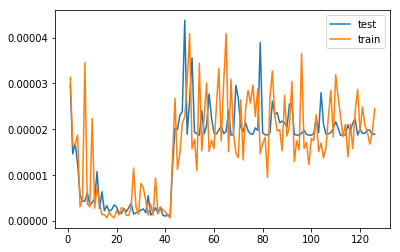

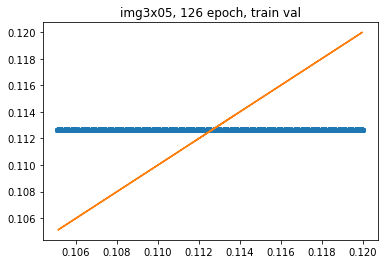

Train Epoch: 127 [0/2030 (0%)]	Loss: 0.000015	 mse: 1.3027842214796692e-05
Train Epoch: 127 [100/2030 (5%)]	Loss: 0.000024	 mse: 2.4565822968725115e-05
Train Epoch: 127 [200/2030 (10%)]	Loss: 0.000013	 mse: 1.3179472261981573e-05
Train Epoch: 127 [300/2030 (15%)]	Loss: 0.000019	 mse: 2.025091635005083e-05
Train Epoch: 127 [400/2030 (20%)]	Loss: 0.000021	 mse: 2.323761145817116e-05
Train Epoch: 127 [500/2030 (25%)]	Loss: 0.000014	 mse: 1.5823490684852004e-05
Train Epoch: 127 [600/2030 (30%)]	Loss: 0.000013	 mse: 1.192401941807475e-05
Train Epoch: 127 [700/2030 (34%)]	Loss: 0.000028	 mse: 1.945185795193538e-05
Train Epoch: 127 [800/2030 (39%)]	Loss: 0.000024	 mse: 1.53273758769501e-05
Train Epoch: 127 [900/2030 (44%)]	Loss: 0.000014	 mse: 1.4063428352528717e-05
Train Epoch: 127 [1000/2030 (49%)]	Loss: 0.000017	 mse: 1.7405238395440392e-05
Train Epoch: 127 [1100/2030 (54%)]	Loss: 0.000019	 mse: 1.9198336303816177e-05
Train Epoch: 127 [1200/2030 (59%)]	Loss: 0.000013	 mse: 1.22767050925176

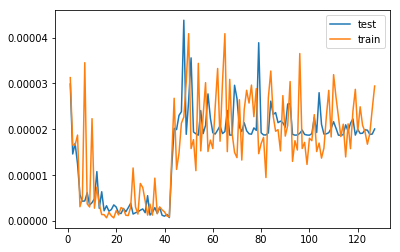

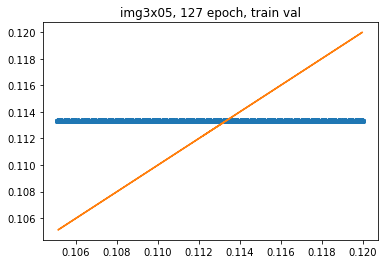

Train Epoch: 128 [0/2030 (0%)]	Loss: 0.000022	 mse: 2.4581602701800875e-05
Train Epoch: 128 [100/2030 (5%)]	Loss: 0.000024	 mse: 2.69530155492248e-05
Train Epoch: 128 [200/2030 (10%)]	Loss: 0.000020	 mse: 2.0731258700834587e-05
Train Epoch: 128 [300/2030 (15%)]	Loss: 0.000027	 mse: 2.8475009457906708e-05
Train Epoch: 128 [400/2030 (20%)]	Loss: 0.000018	 mse: 1.7831303921411745e-05
Train Epoch: 128 [500/2030 (25%)]	Loss: 0.000015	 mse: 1.4552579159499146e-05
Train Epoch: 128 [600/2030 (30%)]	Loss: 0.000015	 mse: 1.6134015822899528e-05
Train Epoch: 128 [700/2030 (34%)]	Loss: 0.000015	 mse: 1.6660756955388933e-05
Train Epoch: 128 [800/2030 (39%)]	Loss: 0.000013	 mse: 1.4020980415807571e-05
Train Epoch: 128 [900/2030 (44%)]	Loss: 0.000015	 mse: 1.5820156477275304e-05
Train Epoch: 128 [1000/2030 (49%)]	Loss: 0.000018	 mse: 1.8868098777602427e-05
Train Epoch: 128 [1100/2030 (54%)]	Loss: 0.000030	 mse: 2.5031324184965342e-05
Train Epoch: 128 [1200/2030 (59%)]	Loss: 0.000028	 mse: 3.0112531021

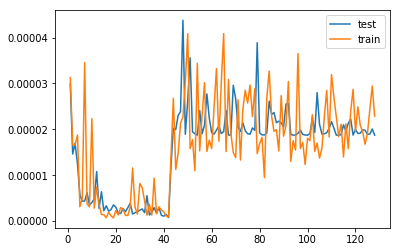

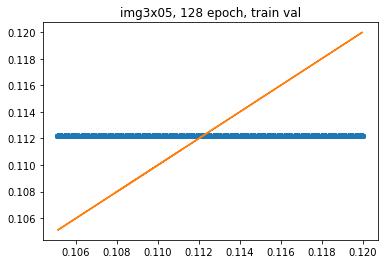

Train Epoch: 129 [0/2030 (0%)]	Loss: 0.000017	 mse: 1.9299923224025406e-05
Train Epoch: 129 [100/2030 (5%)]	Loss: 0.000023	 mse: 2.0631783627322875e-05
Train Epoch: 129 [200/2030 (10%)]	Loss: 0.000016	 mse: 1.7303345885011367e-05
Train Epoch: 129 [300/2030 (15%)]	Loss: 0.000018	 mse: 2.0263349142624065e-05
Train Epoch: 129 [400/2030 (20%)]	Loss: 0.000028	 mse: 2.8494718208094127e-05
Train Epoch: 129 [500/2030 (25%)]	Loss: 0.000025	 mse: 1.6887592209968716e-05
Train Epoch: 129 [600/2030 (30%)]	Loss: 0.000017	 mse: 1.8663111404748634e-05
Train Epoch: 129 [700/2030 (34%)]	Loss: 0.000025	 mse: 2.4443024813081138e-05
Train Epoch: 129 [800/2030 (39%)]	Loss: 0.000040	 mse: 3.7577294278889894e-05
Train Epoch: 129 [900/2030 (44%)]	Loss: 0.000035	 mse: 2.532152211642824e-05
Train Epoch: 129 [1000/2030 (49%)]	Loss: 0.000015	 mse: 1.2599655747180805e-05
Train Epoch: 129 [1100/2030 (54%)]	Loss: 0.000022	 mse: 2.3107817469281144e-05
Train Epoch: 129 [1200/2030 (59%)]	Loss: 0.000013	 mse: 1.449041155

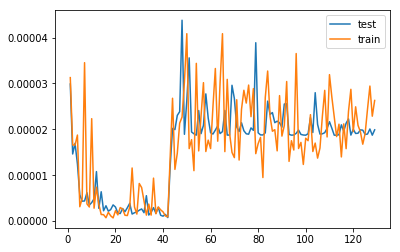

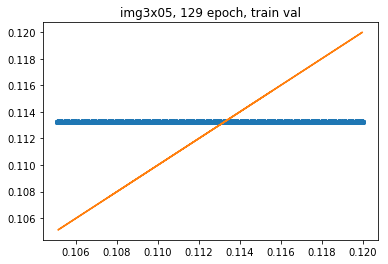

CPU times: user 1h 27min 7s, sys: 11min 55s, total: 1h 39min 2s
Wall time: 1h 36min 9s


In [28]:
%%time
# TODO: draw graph of train test loss
epochs = []
test_loss = []
train_loss = []
cor = []
for epoch in range(1, 130):
    los  = train( model, device, train_loader, optimizer, epoch)
    
    train_loss.append(los)
    
    los = test( model, device, test_loader)
    test_loss.append(los)
    epochs.append(epoch)
    plt.plot(epochs, test_loss, label = "test")
    plt.plot(epochs, train_loss, label = "train")
    plt.legend()
    plt.show()

    if True:
        y_np = np.array([])
        pred_np = np.array([])
        for x,y in test_loader:
            pred = model(x)
            pred_np = np.concatenate((pred_np,np.array(pred.reshape(-1).detach())))
            y_np =  np.concatenate((y_np, np.array(y).flatten()))
        plt.plot(y_np, pred_np, 'p')
        plt.plot(y_np, y_np)
        plt.title("img3х05, {} epoch, train val".format(epoch))
        plt.show()
        cor.append(np.corrcoef(y_np, pred_np)[0][1])
    

In [24]:
y_np

array([], dtype=float64)

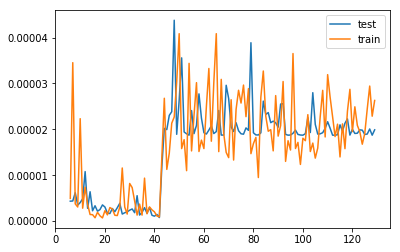

In [29]:
plt.plot(epochs[5:], test_loss[5:], label = "test")
plt.plot(epochs[5:], train_loss[5:], label = "train")
plt.legend()
plt.show()



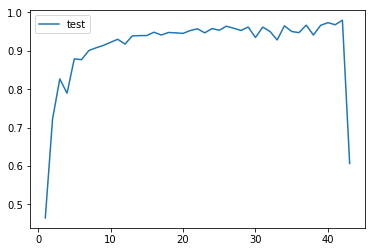

In [39]:
plt.plot(epochs[:43], cor[:43], label = "test")
plt.legend()
plt.show()

In [43]:
np.array(test_loss).min()

7.68190905528766e-07

In [42]:
np.array(cor)[:43].max()

0.9795913057751277

# Затраченное время

Датасет img2: ~50 мин (2.9к на train, 2.9k на test), test loss = 1.2E-5, epochs = 10

Датасет img3 resize0.5x: 20 мин (10к на train, 10k на test), test loss = 6.66E-5, epochs = 10

Датасет img3: 35 мин (10к на train, 10k на test), test loss = 5.4E-5, epochs = 3

Датасет img3: ~120 мин (10к на train, 10k на test), test loss = 6.3E-5, epochs = 10

Датасет img3, 0.3-0.8: ~30 мин (6.7к на train, 4k на test), test loss = 2.3E-5, epochs = 5

Датасет img3, 0.3-0.8: 12ч (6.7к на train, 4k на test), test loss = 3.6E-5, train loss=3E-6, epochs = 130

Датасет img3 0.3-0.8; resize0.5x: 4ч (6.7к на train, 4k на test), test loss = 3E-5, train loss=1E-6, epochs = 130



Ожидаемо время возрасло в 4 раза

In [13]:
for x,y in train_loader:
    break

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [14]:
x

tensor([[[[-0.2969, -0.2842, -0.2969,  ..., -0.2969, -0.2969, -0.2969],
          [-0.3097, -0.3224, -0.2969,  ..., -0.3097, -0.3097, -0.3224],
          [-0.3097, -0.3224, -0.2969,  ..., -0.3097, -0.3224, -0.3224],
          ...,
          [-0.3224, -0.3097, -0.3097,  ..., -0.3097, -0.3097, -0.3097],
          [-0.3097, -0.3097, -0.3097,  ..., -0.3224, -0.3097, -0.3097],
          [-0.3224, -0.3097, -0.2969,  ..., -0.3097, -0.3097, -0.2969]],

         [[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]],

         [[-0.3351, -0.3478, -0.3224,  ..., -0.3351, -0.3224, -0.2969],
          [-0.2842, -0.3097, -

In [15]:
pred = model(x)

In [16]:
pred_np = np.array(pred.reshape(-1).detach())
y_np =  np.array(y).flatten()

In [17]:
import matplotlib.pyplot as plt
np.corrcoef(y_np, pred_np)

/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

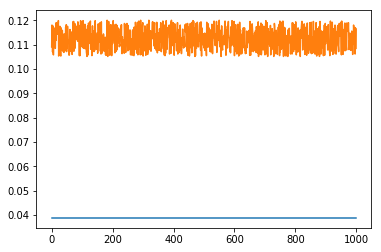

In [18]:
plt.plot(pred_np)
plt.plot(y_np)
plt.show()

Text(0.5,1,'img3х05, 130epoch, train val')

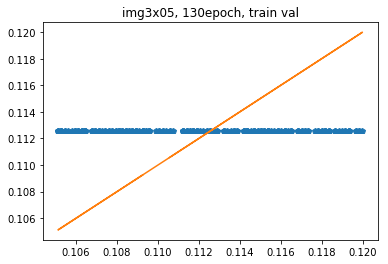

In [28]:

plt.plot(y_np, pred_np, 'p')
plt.plot(y_np, y_np)
plt.title("img3х05, 130epoch, train val")

In [60]:
type(pred)

torch.Tensor

In [3]:
valid_data = FolderImageDataset(path)

In [4]:
intensity = np.zeros(len(valid_data))
phases = np.zeros(len(valid_data))

In [5]:
for i in range(len(valid_data)):
    intensity[i] = valid_data[i][0].mean()
    phases[i] = valid_data[i][1] 

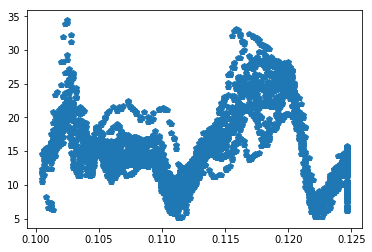

In [8]:
plt.plot(phases, intensity, 'p')

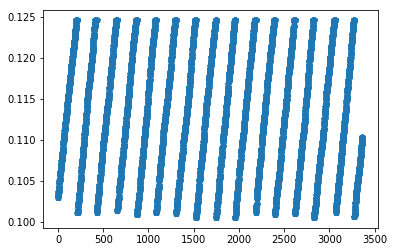

In [9]:
plt.plot(phases, 'p')

In [12]:
a = os.listdir(path)
print(len(a))


6734


In [21]:
for i in range(len(a)):
    if ".png" not in a[i]:
        print(a[i])
        print(i)
        print("\n")

In [15]:
a[".png" in a]

'1476_0.11123386680433661_2.png'

In [18]:
a = filter(cond, a)

In [17]:
def cond(s):
    ans = ".png" in s
    return ans

In [22]:
a = list(a)
len(a)

6733

In [185]:
".png" in a[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [3]:
import skimage.transform
a = [5, 6, 7]

In [4]:
skimage.transform.resize(a)

TypeError: resize() missing 1 required positional argument: 'output_shape'

In [18]:
y_np = np.array([1])
pred_np = np.array([1])
for x,y in test_loader:
    pred = model(x)
    print(type(np.array(pred.reshape(-1).detach())))
    pred_np = np.concatenate(pred_np,np.array(pred.reshape(-1).detach()))
    y_np =  np.concatenate(y_np, np.array(y))
plt.plot(y_np, pred_np, 'p')
plt.plot(y_np, y_np)
plt.title("img3х05, {} epoch, train val".format(epoch))
plt.show()
cor.append()

<class 'numpy.ndarray'>


/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


TypeError: only integer scalar arrays can be converted to a scalar index

In [44]:
a = np.array([])
b = np.array([6.01, 7.03, 8.06])

In [26]:
np.concatenate((a,b))

array([6.01, 7.03, 8.06])

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


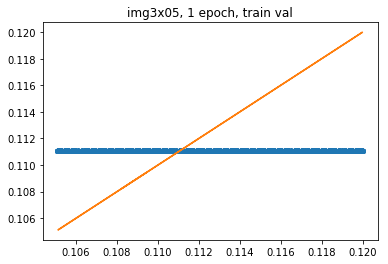

/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [35]:
y_np = np.array([])
pred_np = np.array([])
for x,y in test_loader:
    pred = model(x)
    pred_np = np.concatenate((pred_np,np.array(pred.reshape(-1).detach())))
    y_np =  np.concatenate((y_np, np.array(y).flatten()))
plt.plot(y_np, pred_np, 'p')
plt.plot(y_np, y_np)
plt.title("img3х05, {} epoch, train val".format(epoch))
plt.show()
cor.append(np.corrcoef(y_np, pred_np)[0][1])


# Train_test_split and PCA

In [1]:
from ImageDataset import train_test_split
import os
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
import imageio
from ImageDataset import FolderImageDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

N_COMPONENTS = 20
pca = PCA(N_COMPONENTS)

In [3]:
BATCH=10
# path = r'C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\img'
# path2 = r"C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\img3_stripes"
path = Path("img4_stripes")

# TODO: random sample test data instead of from the end
import skimage
from skimage.transform import resize
class Resize:
    def __init__(self, size):
        if isinstance(size, int):
            self._size = (size, size)
        else:
            self._size = size

    def __call__(self, img: np.ndarray):
        resize_image = resize(img, self._size)
        # the resize will return a float64 array
        return skimage.util.img_as_ubyte(resize_image)
    
    
    
def condition(a):
    # based on dataset inspection plots
    return (0.120 > a) & (a > 0.105)

In [20]:


class Net_pca(nn.Module):
    def __init__(self):
        super(Net_pca, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #self.conv3 = nn.Conv2d(50, 60, 5, 1)

        self.fc1 = nn.Linear(14*19*50, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        #x = F.relu(self.conv3(x))
        print(x.shape)

        #x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 14*19*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t mse: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss, target.std()**2))
    return train_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.7f}\n'.format(
        test_loss))
    return test_loss



In [9]:
train_test = train_test_split(path, filtered=condition, pca = pca)

In [6]:
train_dataset, test_dataset = train_test.get(start = 0.3, end = 1, shuffle = False, test_size = 0.2)

In [21]:
%%time

train_loader = torch.utils.data.DataLoader(
        train_dataset,
     batch_size=BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        test_dataset,
batch_size=BATCH, shuffle=True)






model = Net_pca()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
optimizer = optim.Adam(model.parameters(), lr=0.002)

path_to_save = "cross_validation/"
if not os.path.exists(path_to_save+"{}".format(BATCH)):
    os.makedirs(path_to_save+"{}".format(BATCH))
    
if not os.path.exists(path_to_save+"{}".format(BATCH)+"/pred_real"):
    os.makedirs(path_to_save+"{}".format(BATCH)+"/pred_real")
    
if not os.path.exists(path_to_save+"{}".format(BATCH)+"/cor_coeff"):
    os.makedirs(path_to_save+"{}".format(BATCH)+"/cor_coeff")
    
if not os.path.exists(path_to_save+"{}".format(BATCH)+"/mse"):
    os.makedirs(path_to_save+"{}".format(BATCH)+"/mse")
# TODO: draw graph of train test loss


epochs = []
test_loss = []
train_loss = []
cor = []
for epoch in range(1, 130):
    los  = train( model, device, train_loader, optimizer, epoch)
    
    train_loss.append(los)
    
    los = test( model, device, test_loader)
    test_loss.append(los)
    epochs.append(epoch)
    plt.plot(epochs, test_loss, label = "test")
    plt.plot(epochs, train_loss, label = "train")
    plt.legend()
    plt.show()

    if True:
        y_np = np.array([])
        pred_np = np.array([])
        for x,y in test_loader:
            pred = model(x)
            pred_np = np.concatenate((pred_np,np.array(pred.reshape(-1).detach())))
            y_np =  np.concatenate((y_np, np.array(y).flatten()))
        fig = plt.figure(figsize = (15, 10))
        plt.plot(y_np, pred_np, 'p')
        plt.plot(y_np, y_np)
        plt.title("img3х05, {} epoch, test val".format(epoch))
        fig.savefig(path_to_save+"{}".format(BATCH)+"/pred_real/"+"{epoch}"+'.png')
        plt.show()
        cor.append(np.corrcoef(y_np, pred_np)[0][1])

        
        
fig = plt.figure(figsize = (15, 10))   
plt.plot(epochs[5:], test_loss[5:], label = "test")
plt.plot(epochs[5:], train_loss[5:], label = "train")
plt.legend()
fig.savefig(path_to_save+"{}".format(BATCH)+"/mse/"+"{epoch}"+'.png')
plt.show()

fig = plt.figure(figsize = (15, 10))   
plt.plot(epochs, cor, label = "cor")
plt.legend()
fig.savefig(path_to_save+"{}".format(BATCH)+"/cor_coeff/"+"{epoch}"+'.png')
plt.show()

RuntimeError: Expected 3-dimensional input for 3-dimensional weight 5 20, but got 2-dimensional input of size [10, 20] instead